# Pairs/Basket Trading



## 1. **Introduction: Foundations of Pairs Trading**

Pairs trading is a widely used **market-neutral** strategy that falls under the broader category of **statistical arbitrage**. Its popularity stems from its simplicity and versatility, making it applicable across asset classes such as equities, commodities, and fixed income. By capitalizing on temporary mispricings between related assets, pairs trading seeks to generate consistent returns with reduced exposure to market-wide risks.

The strategy relies on forming a spread, a linear combination of two assets. While the individual assets may be non-stationary, the spread is designed to exhibit stationarity—a statistical property indicating that a time series has a consistent mean and variance over time. Stationary processes often display mean-reversion, meaning the spread tends to return to its average after deviations.

This mean-reverting behavior provides a predictive edge: when the spread moves above its mean, it is expected to decrease, and when it falls below the mean, it is likely to increase. This principle forms the foundation for constructing trading signals and managing positions in pairs trading.


---

## Table of Contents

1. Introduction

2. The Strategy: Z-Score
    - 2.1. Fixed Z-Score
    - 2.2. Rolling Z-Score

3. Backtesting
    - 3.1. Walk-Forward Testing
    - 3.2. Performance Evaluation
    - 3.3. Hegde Ratio Model
    - 3.4. Trading Strategy
    - 3.5. Cross-Validation
    - 3.6. Practical Constraints for Live Trading

In [77]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.io as pio
from tqdm import tqdm

from pairs_trading.backtesting import Backtester, PerformanceAnalyzer
from pairs_trading.strategy import *
from pairs_trading.hedge_ratio import OLSHedgeRatio, DoubleExponentialSmoothingHedgeRatio, KalmanFilterHedgeRatio, JohansenHedgeRatio
from pairs_trading.utility import KalmanFilterModel

from utility.data_processor_helpers import fetch_data, compute_spread
from utility.statistics_helpers import get_beta_ols
import utility.plot_helpers as ph

from config import *

pio.renderers.default = "notebook+pdf"
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
crack_pairs = fetch_data(tickers=crack_tickers, start=start_insample, end=end_outsample)
crack_pairs_tickers = crack_pairs.columns

crack_pairs_insample = crack_pairs.loc[start_insample:end_insample].dropna().copy()
crack_pairs_insample

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker           BZ=F    RB=F
Date                         
2010-01-04  80.120003  2.1044
2010-01-05  80.589996  2.1250
2010-01-06  81.889999  2.1366
2010-01-07  81.510002  2.1349
2010-01-08  81.370003  2.1553
...               ...     ...
2019-12-16  65.339996  1.6627
2019-12-17  66.099998  1.6857
2019-12-18  66.169998  1.6838
2019-12-19  66.540001  1.7068
2019-12-20  66.139999  1.7058

[2475 rows x 2 columns]

## 2. **The Strategy: Z-Score**

A simple and effective pairs trading strategy uses the z-score of the spread to generate entry and exit signals based on deviations from its mean. The z-score is calculated as:

$$
Z_t = \frac{S_t - \mu(t)}{\sigma(t)}
$$

where:
- $S_t$: Current spread at time $t$,
- $\mu(t)$: Mean of the spread, which can be time-dependent or static,
- $\sigma(t)$: Standard deviation of the spread, which can also vary over time.

Deviations beyond ±2 standard deviations are rare and often signal temporary anomalies, making them useful thresholds for trading decisions. The trading rules are straightforward:

- **Go Long**: Enter a long position when: $z_t < z_{\text{enter long}}$
- **Exit Long**: Close the long position when: $z_t > z_{\text{exit long}}$
- **Go Short**: Enter a short position when: $z_t > z_{\text{enter short}}$
- **Exit Short**: Close the short position when: $z_t < z_{\text{exit short}}$

To reduce the number of free parameters in the model, traders often use a single entry and exit threshold for both long and short trades. This approach minimizes the risk of overfitting, especially when optimizing other critical trading parameters. Some traders simplify further by using heuristic values, such as ±2 for entry and 0.5 for exit, which have proven to be effective across various markets and timeframes.

In [368]:
def z_score_strategy(spread, entry_threshold=2, exit_threshold=0.5, rolling=False, window=20):
    """
    Simulates a z-score-based pairs trading strategy with position management.

    Args:
        spread (pd.Series): The spread between two assets.
        entry_threshold (float): Z-score threshold to enter a trade.
        exit_threshold (float): Z-score threshold to exit a trade.
        rolling (bool): Whether to use rolling mean and std for z-score calculation.
        window (int): Rolling window size for rolling z-score calculation.

    Returns:
        pd.DataFrame: DataFrame containing the z-score, trade signals, and position.
    """
    if rolling:
        mean = spread.rolling(window, min_periods=window).mean()
        std = spread.rolling(window, min_periods=window).std()
    else:
        mean = spread.mean()
        std = spread.std()

    z_score = (spread - mean) / std
    z_score = z_score.iloc[:, 0]
    
    signals = pd.DataFrame(index=z_score.index)
    signals["long"] = False
    signals["short"] = False
    signals["exit"] = False
    signals["position"] = 0

    position = 0  # Current position (1 = long, -1 = short, 0 = no position)
    for i in range(len(z_score)):
        if pd.isna(z_score.iloc[i]):  # Skip NaN values for rolling
            continue

        if position == 0: 
            # Enter long position
            if z_score.iloc[i] < -entry_threshold:
                signals.at[z_score.index[i], "long"] = True
                position = 1  
            # Enter short position
            elif z_score.iloc[i] > entry_threshold:
                signals.at[z_score.index[i], "short"] = True
                position = -1 

        elif position == 1: 
            # Exit long position
            if z_score.iloc[i] >= exit_threshold:
                signals.at[z_score.index[i], "exit"] = True
                position = 0  

        elif position == -1:
            # Exit short position
            if z_score.iloc[i] <= -exit_threshold:
                signals.at[z_score.index[i], "exit"] = True
                position = 0  

        signals.loc[z_score.index[i], "position"] = position

    return signals, z_score

### 2.1. **Fixed Z-Score Strategy**

The fixed z-score threshold strategy assumes that the mean ($\mu$) and standard deviation ($\sigma$) of the spread are constant over time. This simplifies the z-score calculation to:

$$
Z_t = \frac{S_t - \bar{\mu}}{\bar{\sigma}}
$$

where $\bar{\mu}$ and $\bar{\sigma}$ are fixed values computed from the entire historical dataset or a predefined period.

The fixed z-score threshold method provides a solid baseline for pairs trading, especially in relatively stable markets where the spread dynamics are consistent. However, it may require adjustments in volatile or shifting market environments.

#### **Default conservative thresholds: $z_{enter} = 2.0 ,\  z_{exit} = 0.5$**

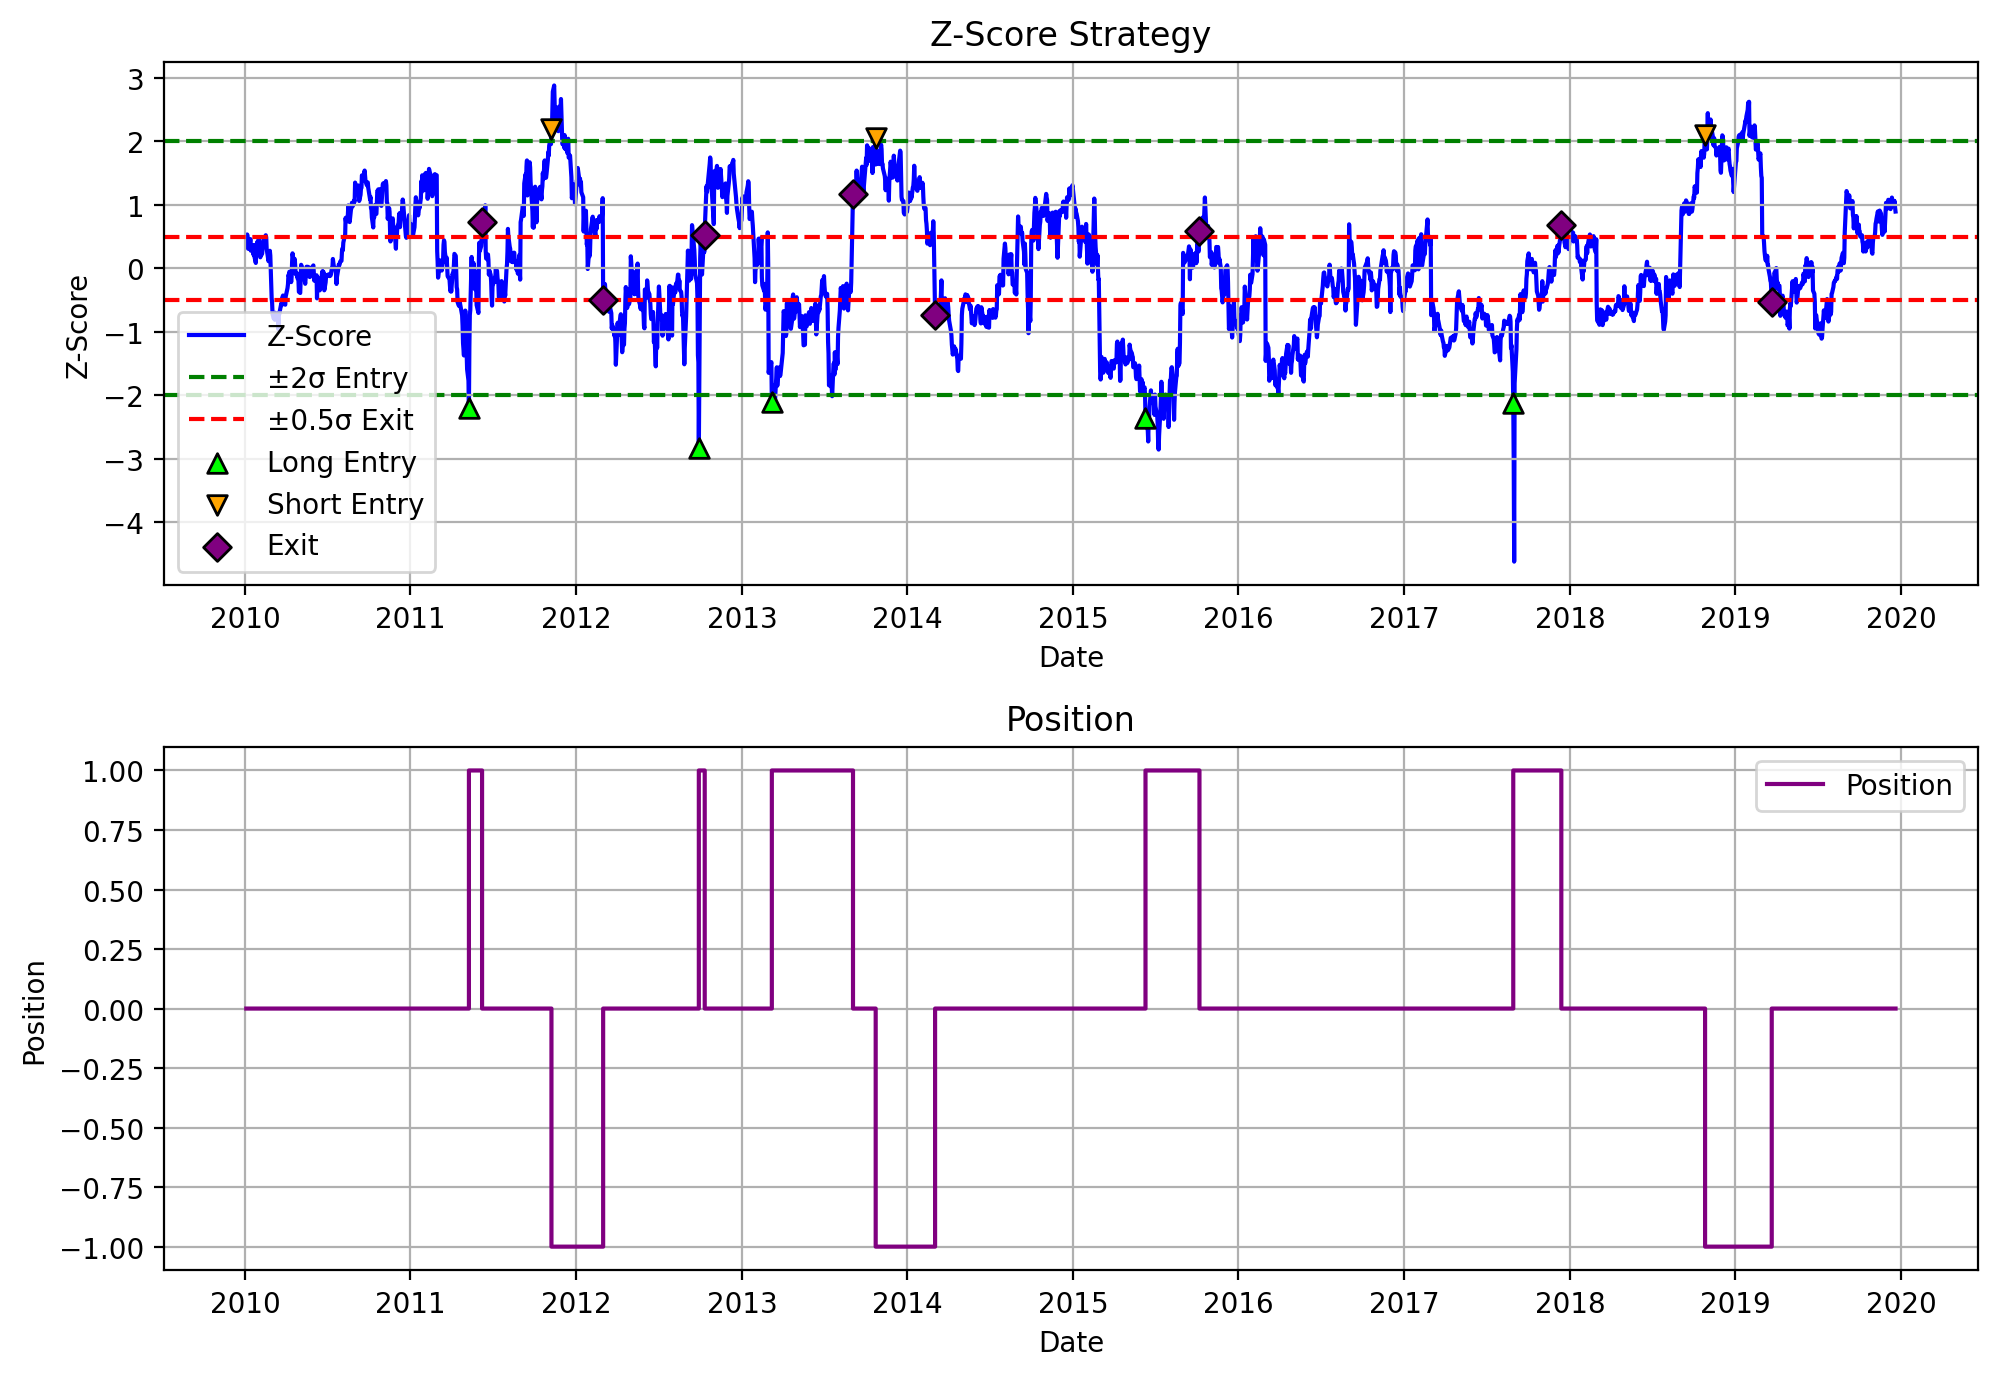

In [192]:
crack_beta = get_beta_ols(crack_pairs_insample, crack_pairs_tickers)
crack_hr = [1, -crack_beta]
crack_spread = compute_spread(crack_pairs_insample, crack_pairs_tickers, crack_hr)

crack_signals, z_zcore = z_score_strategy(crack_spread)
ph.plot_fixed_zscore(z_zcore, crack_signals)

Using heuristic values for the thresholds, thestrategy generates satisfactory signals with minimal false positives. However, a notable exception occurs in late 2017, where a long position results in a significant temporary loss before eventually reverting to profitability.

This highlights a key characteristic of pairs trading: while the strategy often yields a high frequency of small, profitable trades, it remains vulnerable to occasional large drawdowns. These outlier events underscore the importance of incorporating robust risk management measures, such as position sizing and stop-loss limits, to mitigate the impact of extreme losses on overall performance.

####  **Aggresive entry threshold: $z_{enter} = 1.0 ,\  z_{exit} = 0.5$**

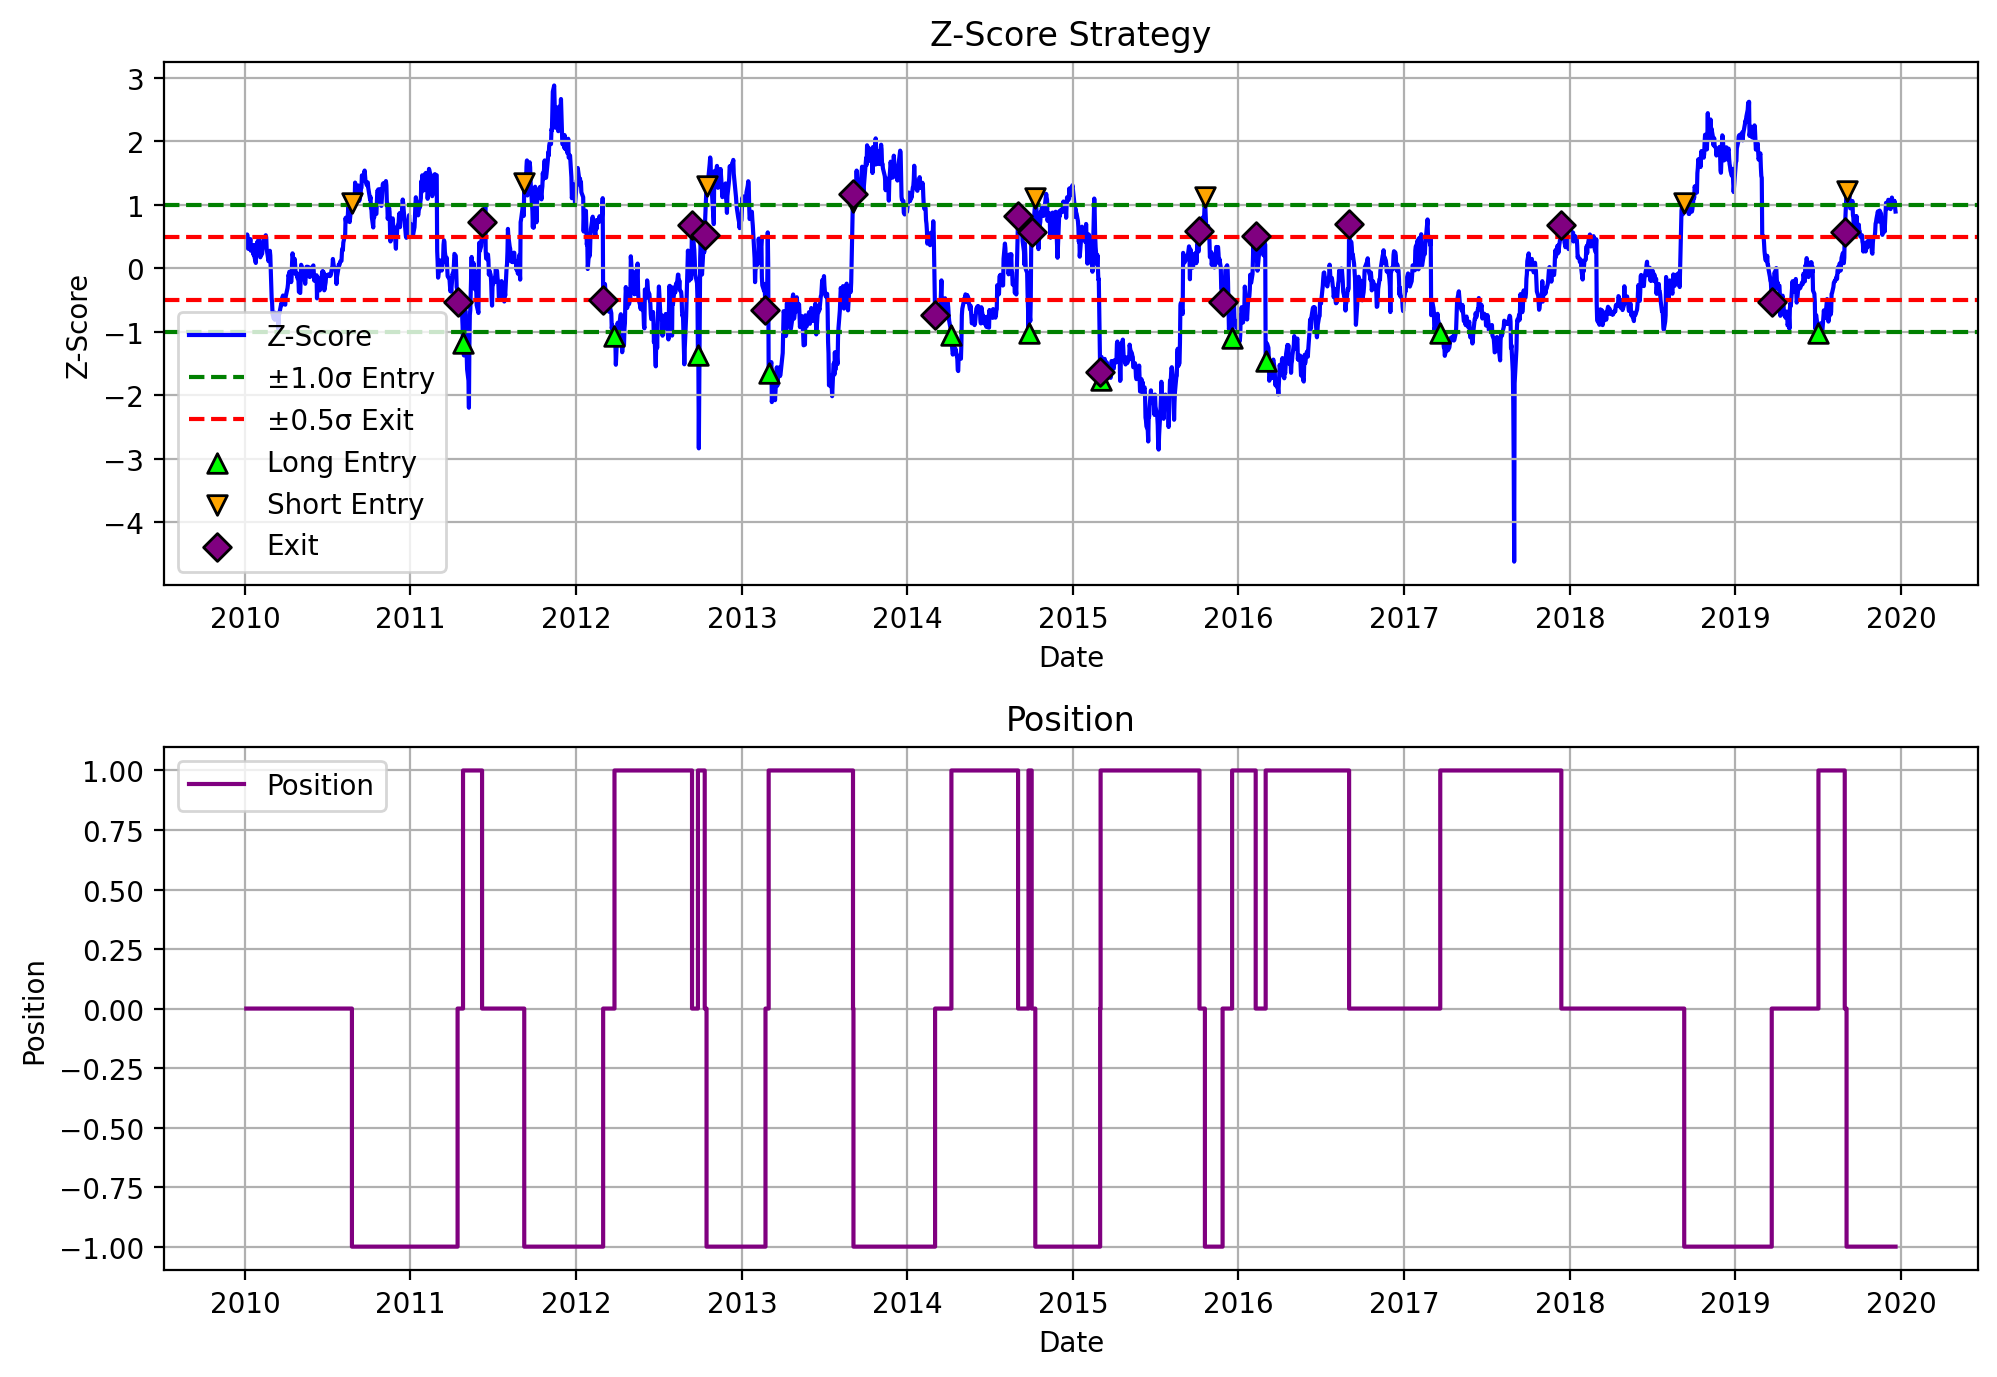

In [191]:
crack_signals, zcore = z_score_strategy(crack_spread, entry_threshold=1.0)
ph.plot_fixed_zscore(zcore, crack_signals, entry_threshold=1.0)

The reduced thresholds result in a higher frequency of trades, as the strategy triggers entries more frequently when the z-score crosses the ±1 levels. While this creates more trading opportunities, it also increases the likelihood of entering positions prematurely, at times when the spread continues to diverge further. In real-time trading, such divergence can trigger stop losses, ultimately leading to realized losses.

### 2.2. **Rolling Z-Score Strategy**

The Rolling Z-Score is a dynamic variation of the fixed z-score strategy. Instead of relying on fixed historical averages and standard deviations, the rolling z-score recalculates the mean $\mu_t$ and standard deviation $\sigma_t$ over a moving window of recent data points. This approach allows the strategy to adapt to changing market conditions and capture shifts in the behavior of the spread over time.

The rolling z-score is calculated as:

$$
Z_t = \frac{S_t - \mu_t}{\sigma_t}
$$

where:
- $\mu_t$ : Rolling mean over a specified window size.
- $\sigma_t$ : Rolling standard deviation over the same window.

In this strategy, entry and exit thresholds are dynamically determined as the rolling mean ± multiples of the rolling standard deviation. A particular case of the rolling z-score strategy occurs when the exit threshold $z_{\text{exit}}$ is set to 0, aligning with the rolling mean. This specific variation corresponds to the well-known **Bollinger Bands** technical indicator, where trades are exited when the spread reverts to the mean.

The adaptability of the rolling z-score strategy makes it especially effective in capturing shifts between periods of low and high volatility, which are characteristic of financial markets.

##### **Bollinger Bands: $z_{enter} = 2.0 ,\  z_{exit} = 0.0$**

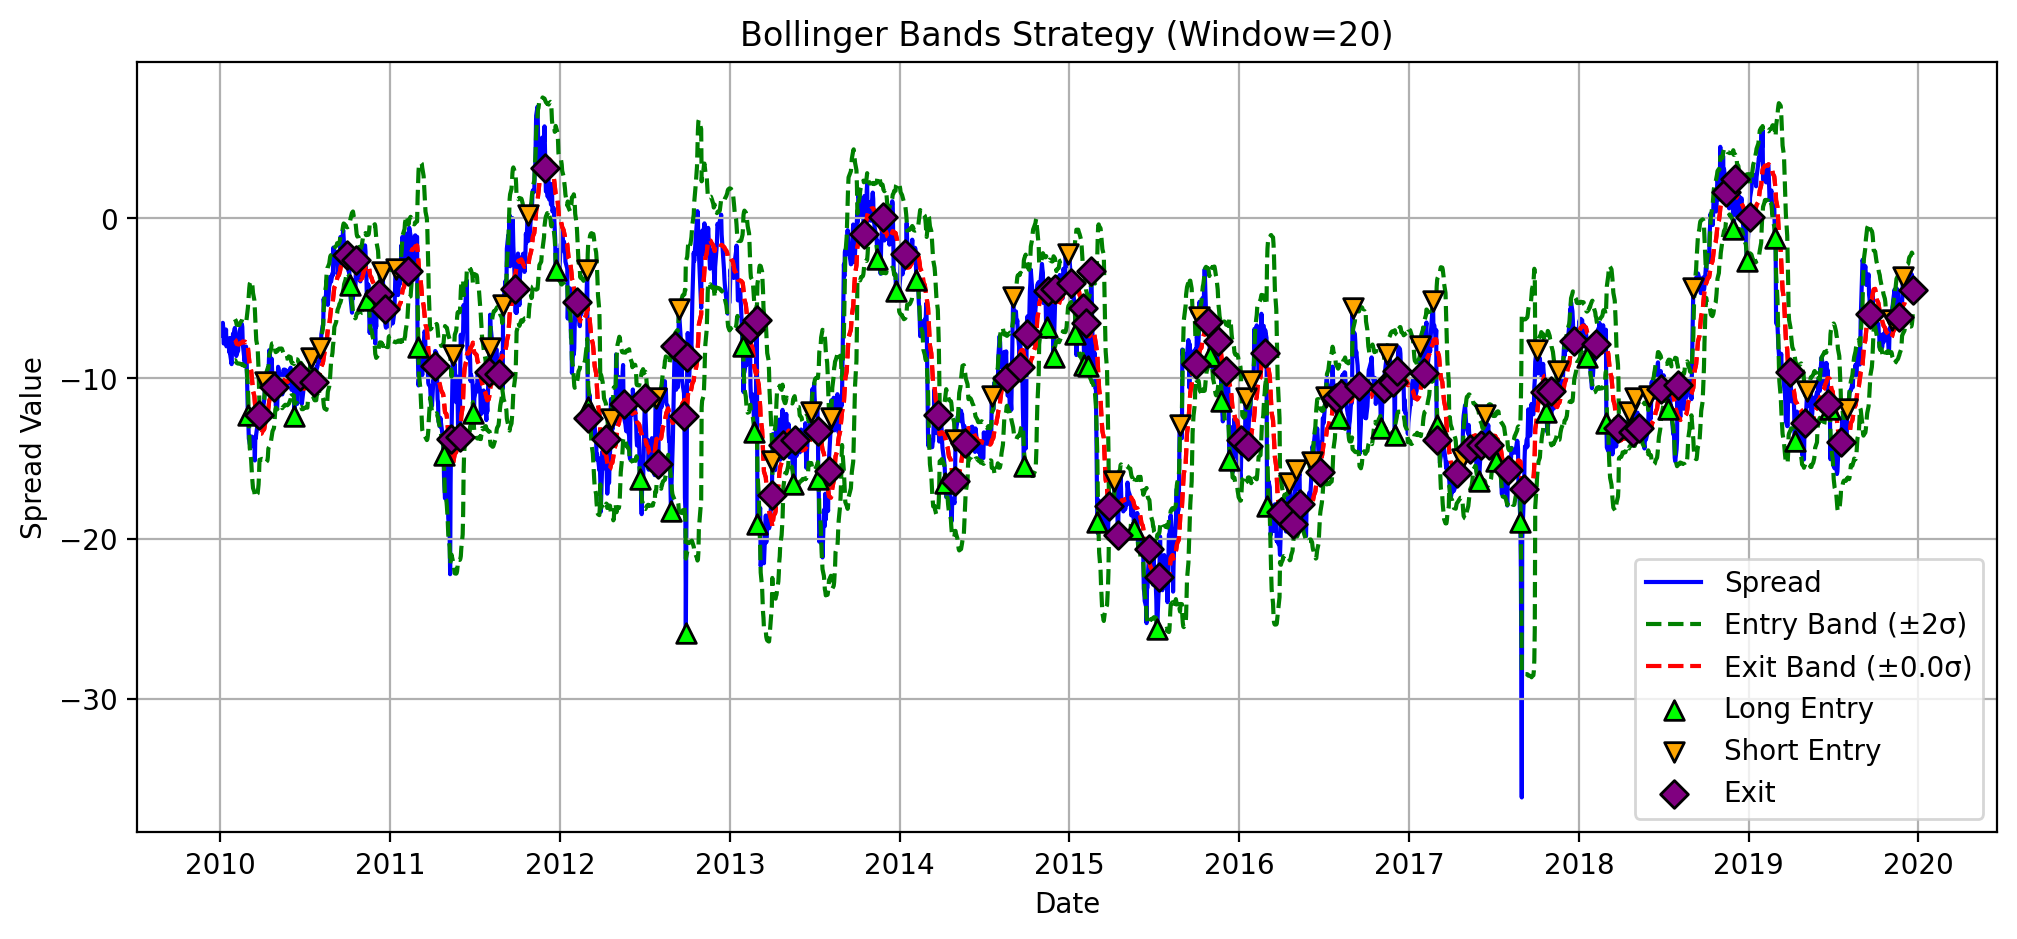

In [188]:
crack_signals, _ = z_score_strategy(crack_spread, rolling=True, exit_threshold=0.0)
ph.plot_rolling_zscore(crack_spread, crack_signals, exit_threshold=0.0)

Here we can clearly see the dynamic nature of the rolling z-score strategy, where the thresholds adjust dynamically with changes in the spread’s rolling mean and standard deviation. This adaptability leads to a high frequency of trades, especially in periods of increased volatility.

 While this provides more opportunities to capitalize on mean-reversion, it also increases the risk of overtrading and potential transaction costs, particularly in markets with low liquidity or high execution fees. 

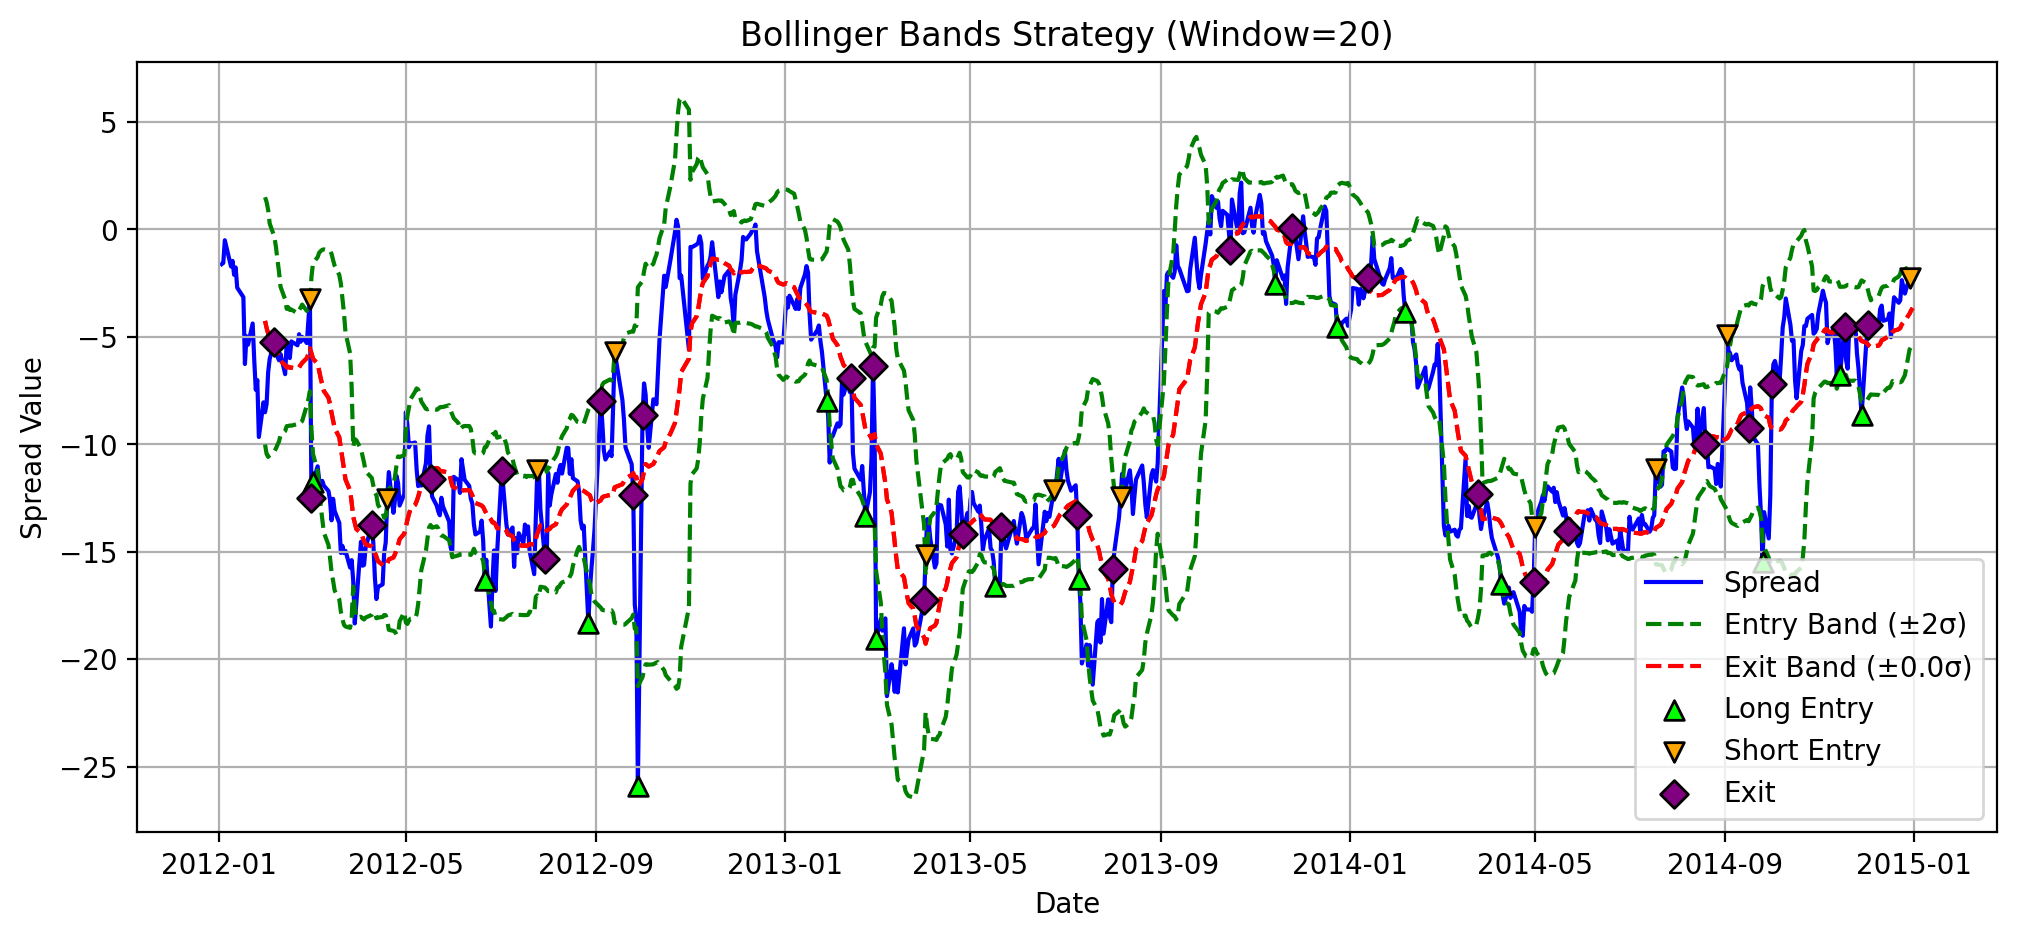

In [189]:
ph.plot_rolling_zscore(crack_spread.loc["2012":"2014"], crack_signals.loc["2012":"2014"], exit_threshold=0.0)

This plot highlights how the rolling z-score strategy generates signals in a shorter time frame. Signals are triggered as the spread touches the dashed green lines (entry thresholds), with exits occurring when the spread reverts and crosses the dashed red lines (exit thresholds). 


--- 

## 3. **Backtesting**

Previously, the strategy was evaluated in-sample using the entire dataset to understand its mechanics. However, in-sample analysis alone cannot simulate real-world trading. Backtesting addresses this by testing the strategy on historical data to evaluate **out-of-sample performance**, ensuring robustness and avoiding overfitting.

This section introduces the Backtester class for pairs and basket trading using default configurations, explores the risks of overfitting with cross-validation, and highlights the importance of risk management constraints like drawdown limits and half-life. This shift ensures the strategy is rigorously tested under realistic trading conditions aiming at maximizing profit while minimizing risks. For that we keep thr crack spread as a banchmark for epxlaining the backtest procedure and after we will apply the bakctest to all pairs selected

### 3.1. **Walk-Forward Testing with the Backtester Class**

Walk-forward testing is the most popular and commonly used backtesting method designed to simulate live trading more accurately by accounting for the evolving nature of financial markets. Unlike static in-sample testing, where the entire dataset is used to derive parameters, walk-forward testing divides the data into multiple sequential segments, each consisting of a **training window** (used to calculate strategy parameters) and a subsequent **testing window** (used to evaluate performance).

The process is as follows:
- **Training Window:** Parameters such as the mean and standard deviation for the z-score calculation are estimated using only the data within the training period.

- **Testing Window:** The strategy is applied to the testing period using the parameters derived from the preceding training window.

- **Rolling Forward:** The training window shifts forward in time, incorporating new data while dropping the oldest, ensuring the model remains adaptive. 

<img src="images/walk_forward_testing.png" style="width: 700px;" />

This rolling framework ensures that all decisions during backtesting are made using only past information, thereby eliminating **look-ahead bias** which is common in pairs trading. 

#### **Backtest Example: Double Exponential Smoother hedge ratio with Ornstein-Uhlenbeck strategy using default settings**

A simple strategy with default parameters can be shown, for that we need an concrete instance of a subclass of the **Strategy** and the **HedgeRatio** abstract classes. To run the backtest, we call the **run_backtest()** public method that performs the above procedure given the configurations given in the instance of **Backtester**.

In [90]:
crack_pairs_outsample = crack_pairs.loc[start_outsample:end_outsample]

strategy = BollingerBandsStrategy()
hedge_ratio_ols = OLSHedgeRatio(window=7)

backtester_ols = Backtester(crack_pairs_outsample, strategy, hedge_ratio_ols)
backtester_ols.run_backtest()


---

### 3.2. **Performance Metrics: Evaluating the Results**

This section evaluates the performance of the trading strategy using two complementary approaches: visual analysis of cumulative returns, drawdowns, and rolling Sharpe ratios, and quantitative analysis using performance metrics. The goal is to assess both the profitability and risk characteristics of the strategy.

- **Visual Analysis**: Examining cumulative returns, drawdown profiles, and rolling Sharpe ratios to understand the temporal dynamics of strategy performance and identify trends, drawdown severity, and risk-adjusted returns over time.

- **Quantitative Analysis**: Leveraging key performance metrics such as Sharpe ratio, Sortino ratio, drawdown statistics, win rate, profit factor, and more to compare strategies objectively and make data-driven decisions.

The section emphasizes the importance of balancing profitability with risk management when interpreting these results.

The **PerformanceAnalyzer** class provides all necessary performance metrics and plot to assess the profitability and risk of the strategy.

In [91]:
from pairs_trading.backtesting import PerformanceAnalyzer
backtest_results = [("Rolling OLS", backtester_ols)]
perf = PerformanceAnalyzer(backtest_results)

#### 3.2.1. **Visual Analysis**

Visual analysis provides an intuitive way to evaluate a trading strategy by examining key plots: cumulative returns, drawdowns, and rolling Sharpe ratios. These visualizations reveal critical insights into the strategy’s performance, risk profile, and robustness over time.

- **Equity Curve:** It displays the growth of $1 invested in the strategy across the backtest period, highlighting overall profitability. However, over long backtest periods, prolonged drawdowns or losses may become less apparent due to the compounding effect and scaling of the equity curve.

- **Underwater Curve:** It highlights the percentage decline from the portfolio’s peak. This plot is especially valuable for highlighting the severity and duration of losses, which might not be immediately obvious in the equity curve.

- **Rolling Sharpe ratio:** It helps to identify **strategy decay** which is pervasive in quantitative trading where arbitrage opportunities erode over time as markets become more efficient. If the rolling Sharpe ratio exhibits a declining trend, it may indicate that the strategy’s edge has been arbitraged away. 

By combining these plots, we achieve a comprehensive visualization of both the return potential and the risks associated with the strategy.


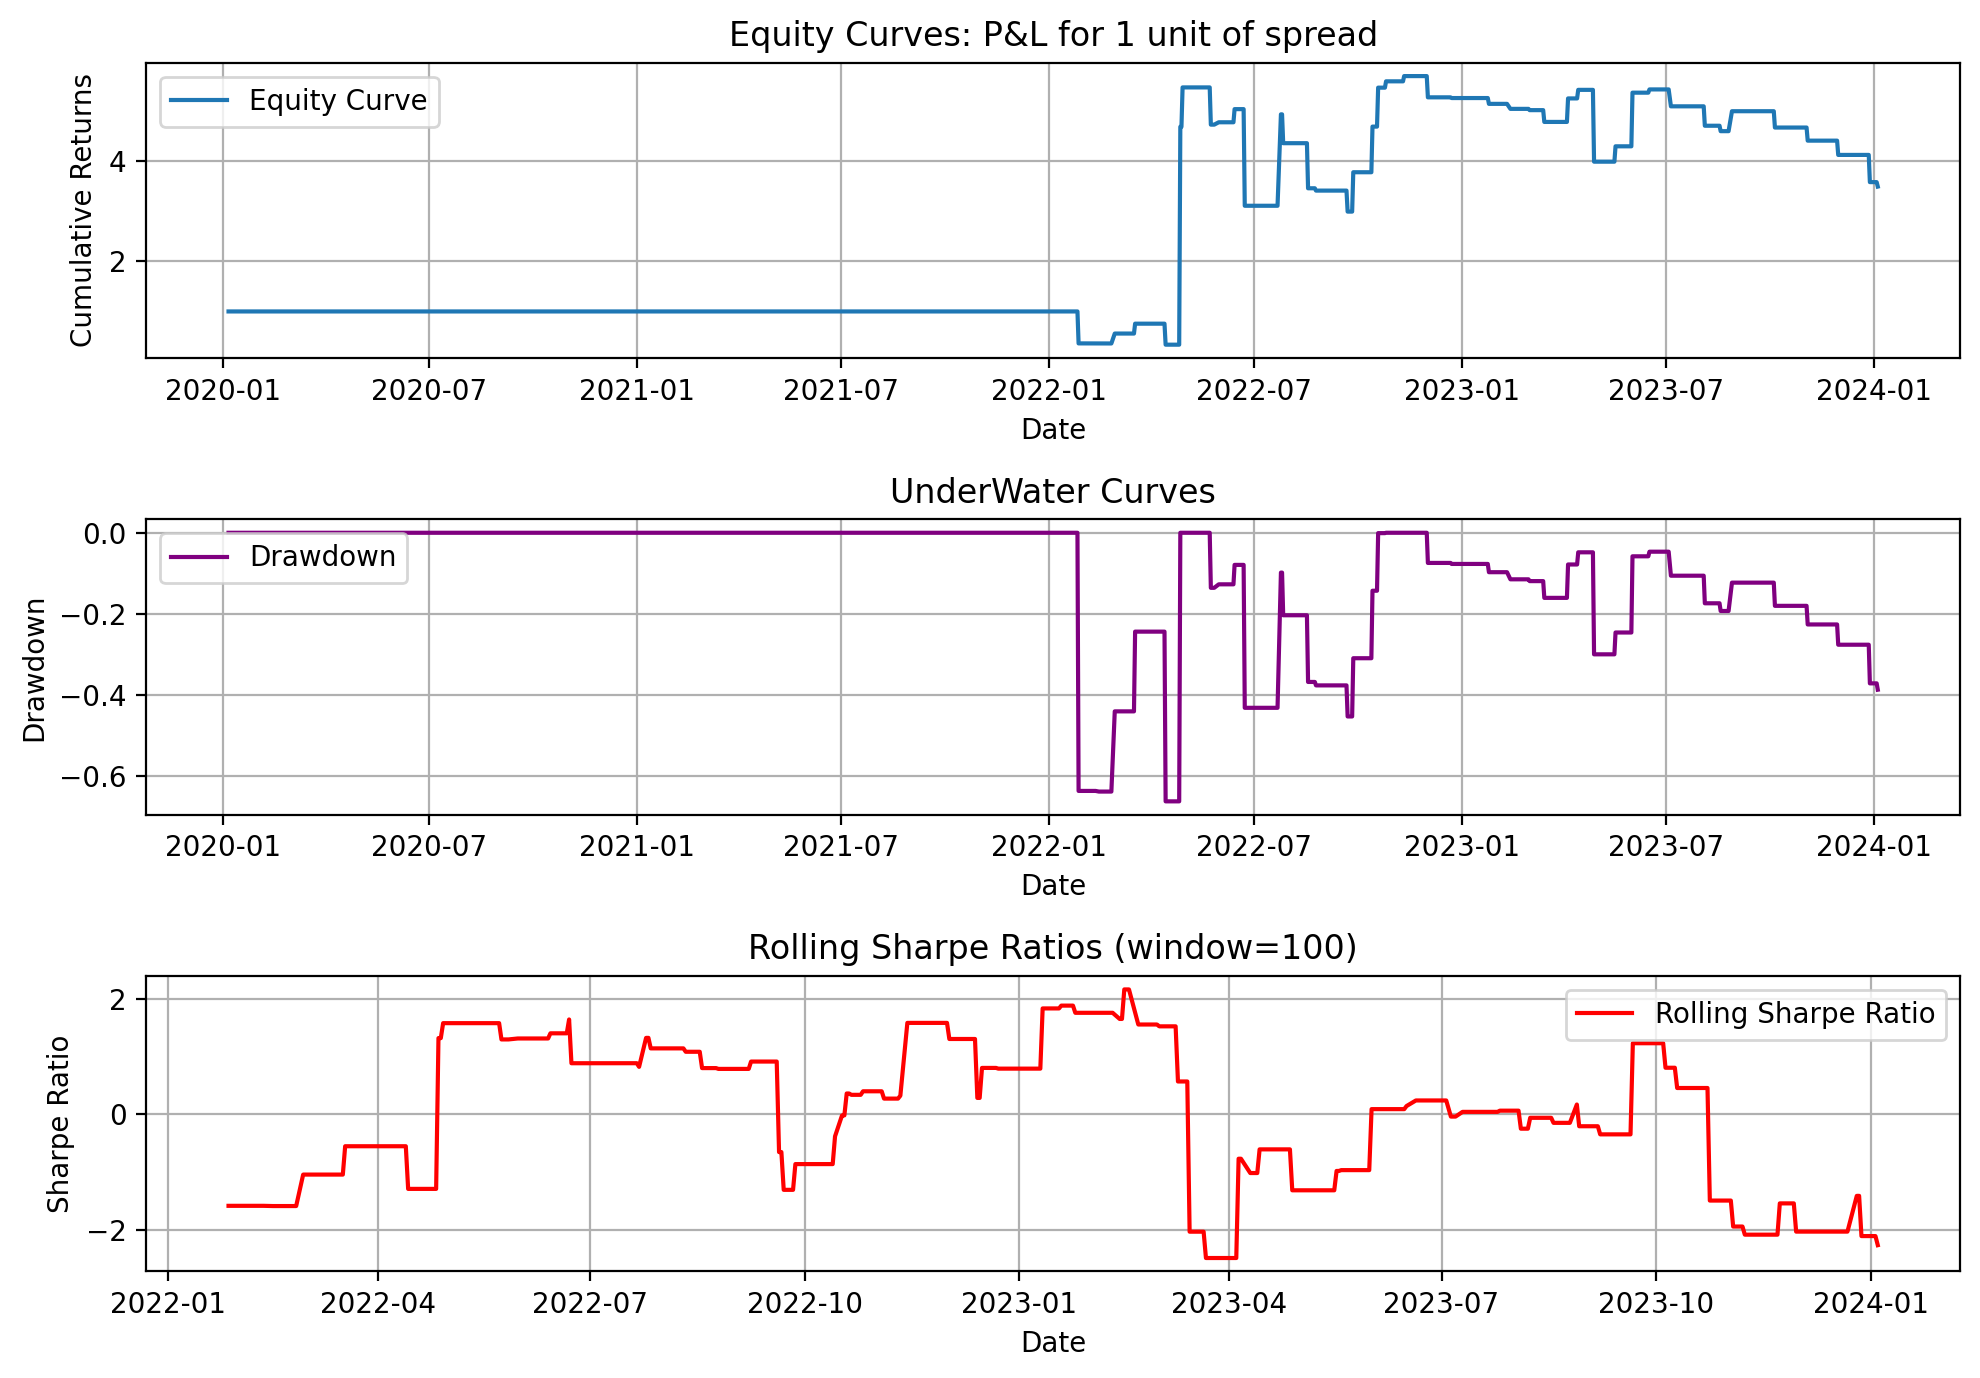

In [88]:
perf.plot_results()

The strategy experiences its largest drawdown during the COVID-19 crash, with a **maximum drawdown of 25%**. It recovers by **July 2020** and performs strongly until **February 2022**, maintaining an average rolling Sharpe ratio of 2 and minimal drawdowns under 5%. Post-February 2022, signs of strategy decay emerge, with performance stabilizing briefly before a period of deep drawdowns begins in **March 2023**, leading to a prolonged underwater phase lasting until the end of the backtest. The max drawdown duration spans approximately a year.

#### 3.2.2. **Quantitative Analysis**

This section evaluates the trading strategy through three complementary dimensions, each offering unique insights into its performance and reliability:

- **Risk-adjusted performance measures:** These metrics quantify the returns achieved per unit of risk. The **Sharpe Ratio**, the most commonly used measure, assesses overall risk-adjusted returns using volatility as the risk metric. The **Sortino Ratio** enhances this by focusing exclusively on downside risk, while the **Calmar Ratio** evaluates returns relative to the maximum drawdown.

- **Drawdown risk metrics:** These measures focus on cumulative losses, which are critical in understanding the strategy’s risk profile. **Maximum drawdown** captures the deepest decline in the equity curve, while **maximum drawdown duration** measures the longest recovery period. The **Ulcer Index** combines both depth and duration, offering a comprehensive view of drawdown severity.

- **Trading metrics:** This dimension focuses on individual trade performance, analyzing metrics like **Win Rate**, **Average Win**, **Average Loss**, and **Profit Factor**. These metrics provide granular insights into the consistency and profitability of trades, complementing the broader risk-return analysis.

Together, these categories offer a balanced and detailed assessment of the strategy, from overall risk-return efficiency to trade-level execution performance.

In [26]:
perf.get_metrics()

Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max Drawdown  \
Rolling OLS      0.207406       0.085447      0.003727      0.662212   

             Max Drawdown Duration  Ulcer Index  Average Win  Average Loss  \
Rolling OLS                    274       0.1834     0.712625     -0.430808   

             Profit Factor  
Rolling OLS       1.240618

For briefty we comment the results for the 3 most importnat metrics, namelt the annualized sharpe ratio, and the maximum drawdown and drawdown duration.

- The results indicate that the strategy has a Sharpe Ratio of 0.87, which falls below the commonly accepted threshold of 1, suggesting modest risk-adjusted returns with room for improvement.

- Additionally, a Maximum Drawdown is 27.2% is usually considered high espeically in institutionla settings where values less than 15% are targeted but for retail setting it may be acceptable.

- Lastly, a Maximum Drawdown Duration is 283 days, which is notably high, far exceeding the typical acceptable range of 3 to 6 months, indicating prolonged recovery periods that may be impractical for most trading strategies.

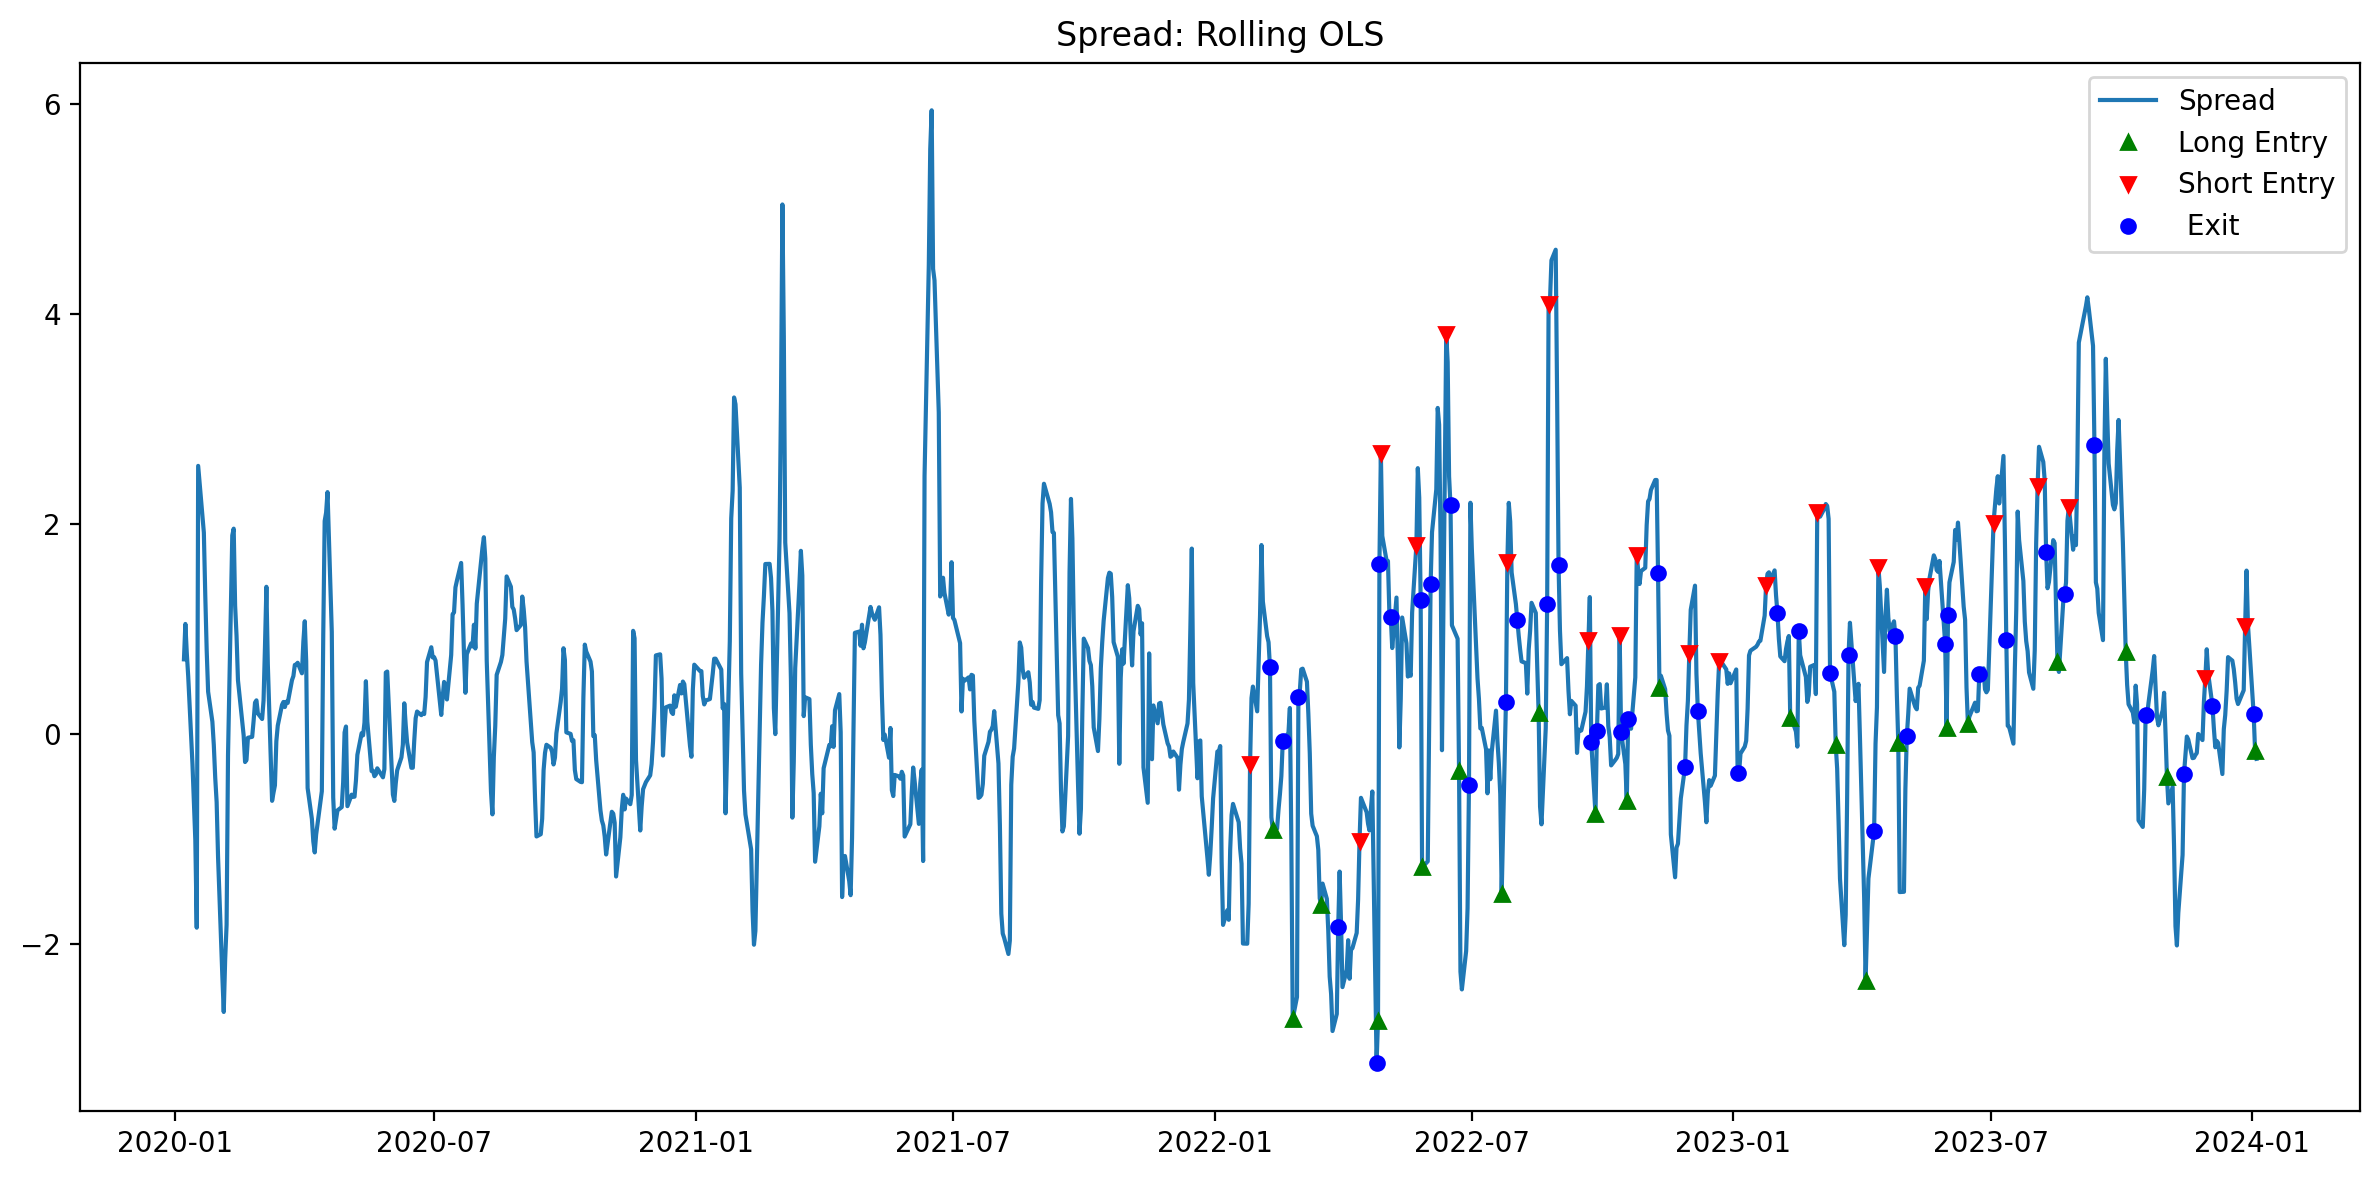

In [27]:
perf.plot_signals()

As you can see the current appraoch is not very profitable with a high amount of risk for so little return. In the next sections, we epxlore different hedge ratio models as well as other trading strategies than the Bollinger Bands.


---

### 3.3. **Hedge Ratio Models: Beyond Rolling OLS**

As shown in the previous section, rolling OLS provides a simple yet effective way to implement dynamic hedge ratios by recalculating the relationship between assets over a moving window. While rolling OLS serves as a foundational model, it may struggle to fully capture non-linear or evolving relationships in more complex markets.

This section explores advanced dynamic hedge ratio models:
- **Double Exponential Smoother (Holt-Winters Method)**: A time-series smoothing technique that adjusts hedge ratios dynamically.

- **Kalman Filter**: Adaptive methods that dynamically estimate hedge ratios in real time using Bayesian updating.

While both approaches aim to adapt to changing market conditions, they differ significantly in their underlying modeling procedures.


#### **Double Exponential Smoother**

The **Double Exponential Smoother** is a time-series technique which belongs to the Hill-Winter method, and is used in pairs trading to estimate a dynamic hedge ratio by modeling both the level and trend. This method assigns exponentially decreasing weights to past data, ensuring that more recent observations have a stronger influence.

The Double Exponential Smoother operates through two key components:

1. **Level Equation**: Captures the smoothed value of the relationship at time $t$:
$$
L_t = \alpha Y_t + (1 - \alpha)(L_{t-1} + T_{t-1})
$$
Here, $L_t$ is the smoothed level, $Y_t$ is the observed value, $\alpha$ is the smoothing parameter, and $T_{t-1}$ is the trend from the previous time step.

2. **Trend Equation**: Accounts for the rate of change in the relationship:
$$
T_t = \beta (L_t - L_{t-1}) + (1 - \beta)T_{t-1}
$$
Where $T_t$ is the updated trend, and $\beta$ is the smoothing parameter for the trend.

3. **Forecasting Equation**: Combines the level and trend to produce a dynamic hedge ratio:
$$
\hat{Y}_{t+h} = L_t + hT_t
$$
Where $h$ is the forecast horizon which in our case we assume $h=1$

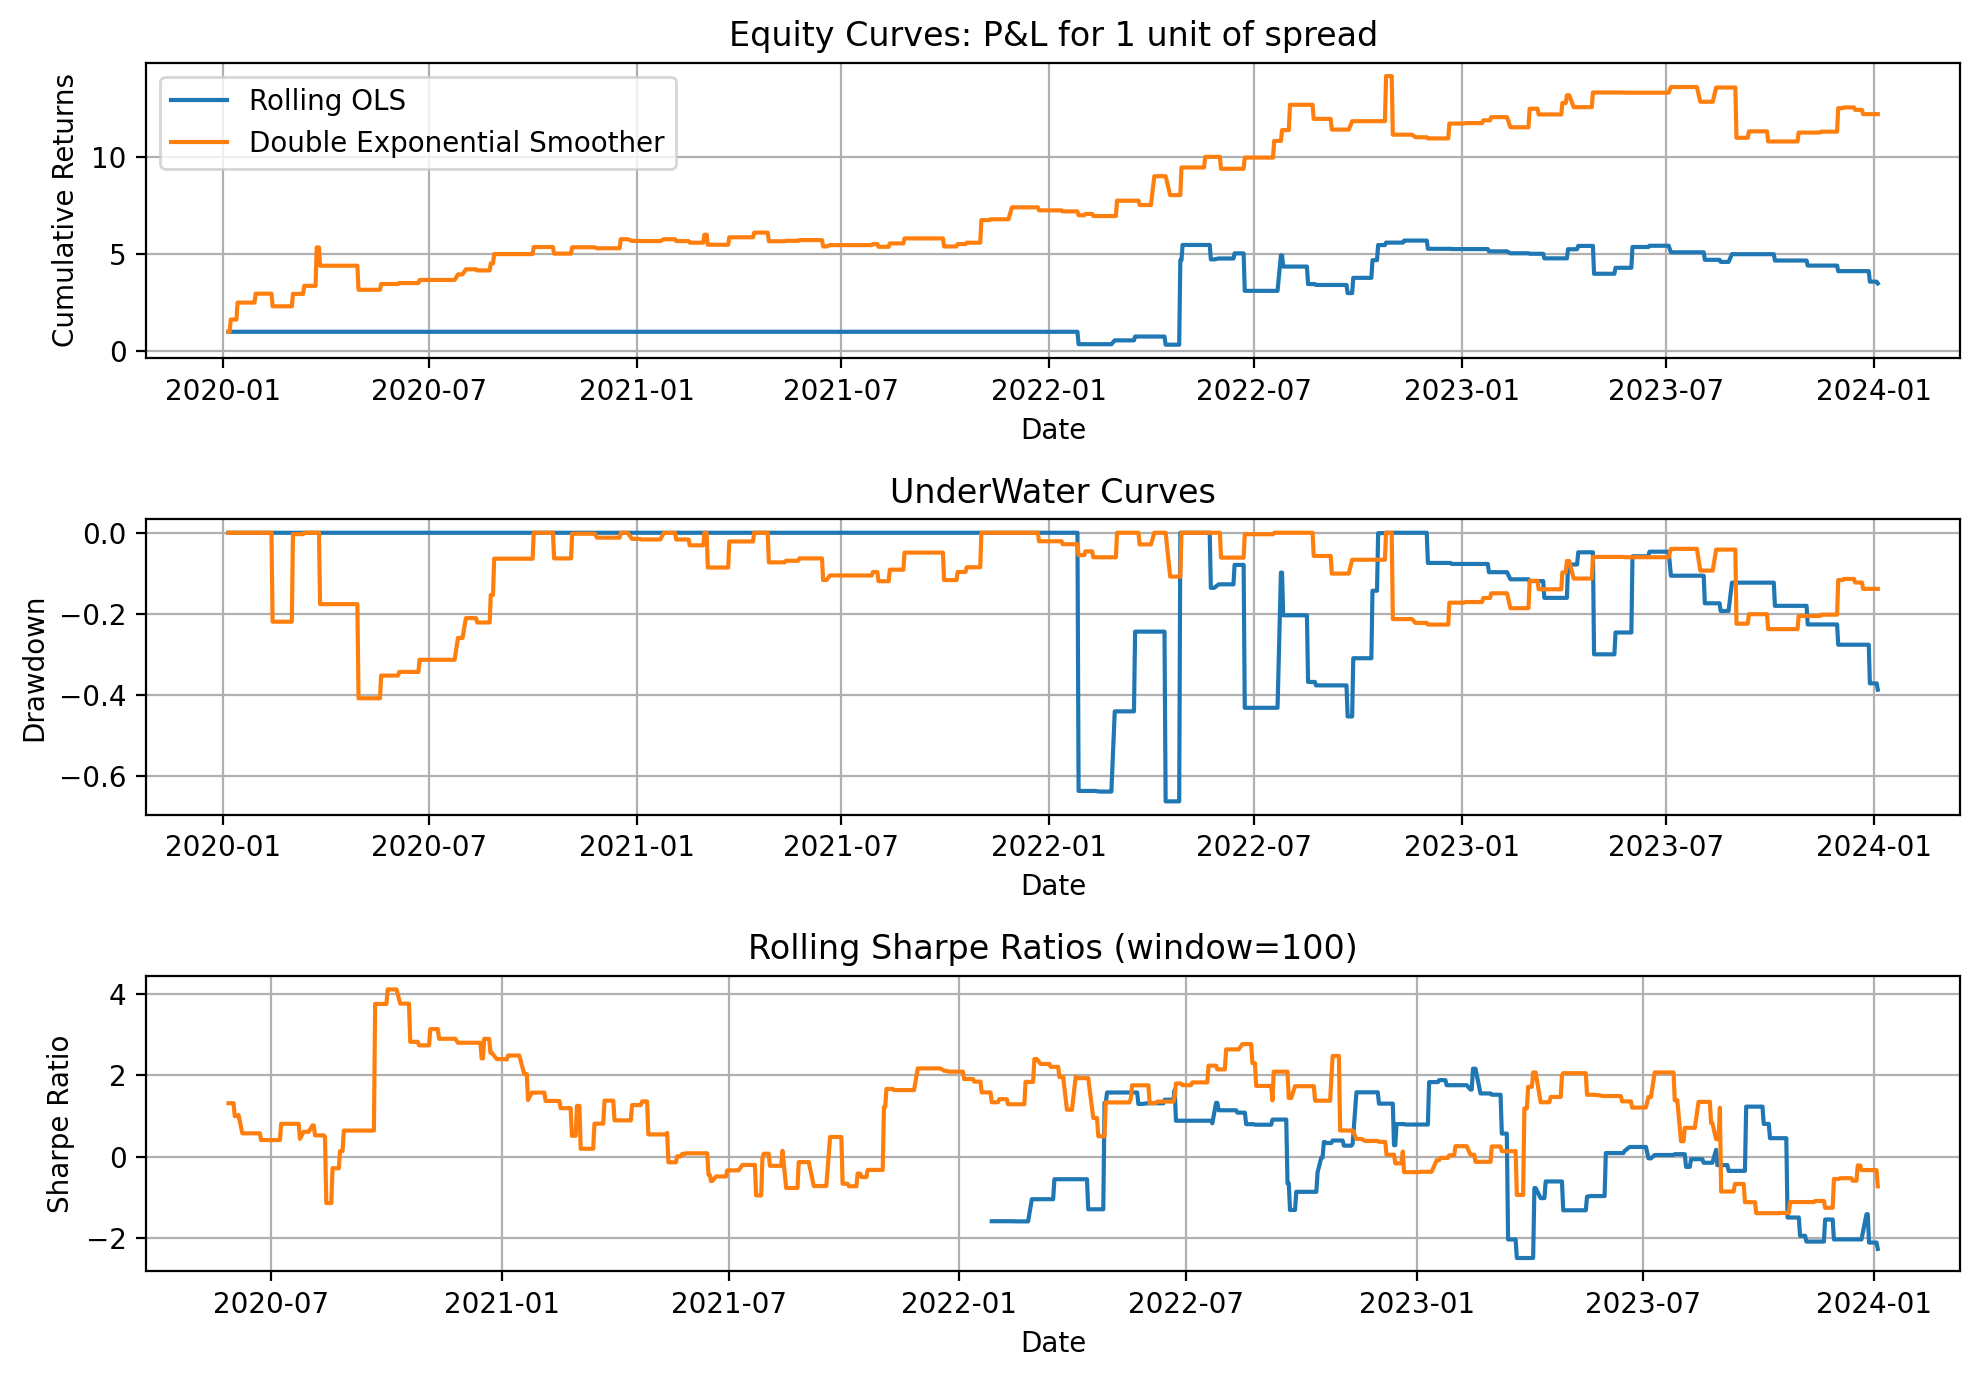

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Rolling OLS                      0.207406       0.085447      0.003727   
Double Exponential Smoother      0.781207       0.272887      0.027202   

                             Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Rolling OLS                      0.662212                    274     0.183400   
Double Exponential Smoother      0.408061                    296     0.136431   

                             Average Win  Average Loss  Profit Factor  
Rolling OLS                     0.712625     -0.430808       1.240618  
Double Exponential Smoother     0.509068     -0.495226       1.627589

In [28]:
hedge_ratio_des= DoubleExponentialSmoothingHedgeRatio()

backtester_des = Backtester(crack_pairs_outsample, strategy, hedge_ratio_des)
backtester_des.run_backtest()

backtest_ols = {"Double Exponential Smoother": backtester_des}
perf.add_backtests(backtest_ols)
perf.plot_results()
perf.get_metrics()

#### **Kalman Filter**

The **Kalman Filter** is a powerful adaptive model that estimates hedge ratios dynamically by treating them as a latent variable in a state-space framework. It excels in capturing time-varying relationships and is particularly effective in noisy or fast-changing market conditions.

The Kalman Filter operates through two core components:

1. **State Equation**: Models the evolution of the hedge ratio over time:
$$
\theta_t = \theta_{t-1} + w_t
$$
Here, $\theta_t$ is the hedge ratio at time $t$, and $w_t \sim N(0, Q_t)$ is the process noise, capturing random fluctuations in the hedge ratio.

2. **Observation Equation**: Links the observed spread $(y_t)$ to the hedge ratio:
$$
y_t = X_t \theta_t + v_t
$$
Where $y_t$ is the observed spread, $X_t$ represents the features (e.g., asset prices), and $v_t \sim N(0, R_t)$ is the observation noise. <br>

The Kalman Filter can be fitted using bayesian update rule where at eaach time step we make prediction and we update the state parameetrs $\theta_t$ based on the forecast eror and the Kalman gain.

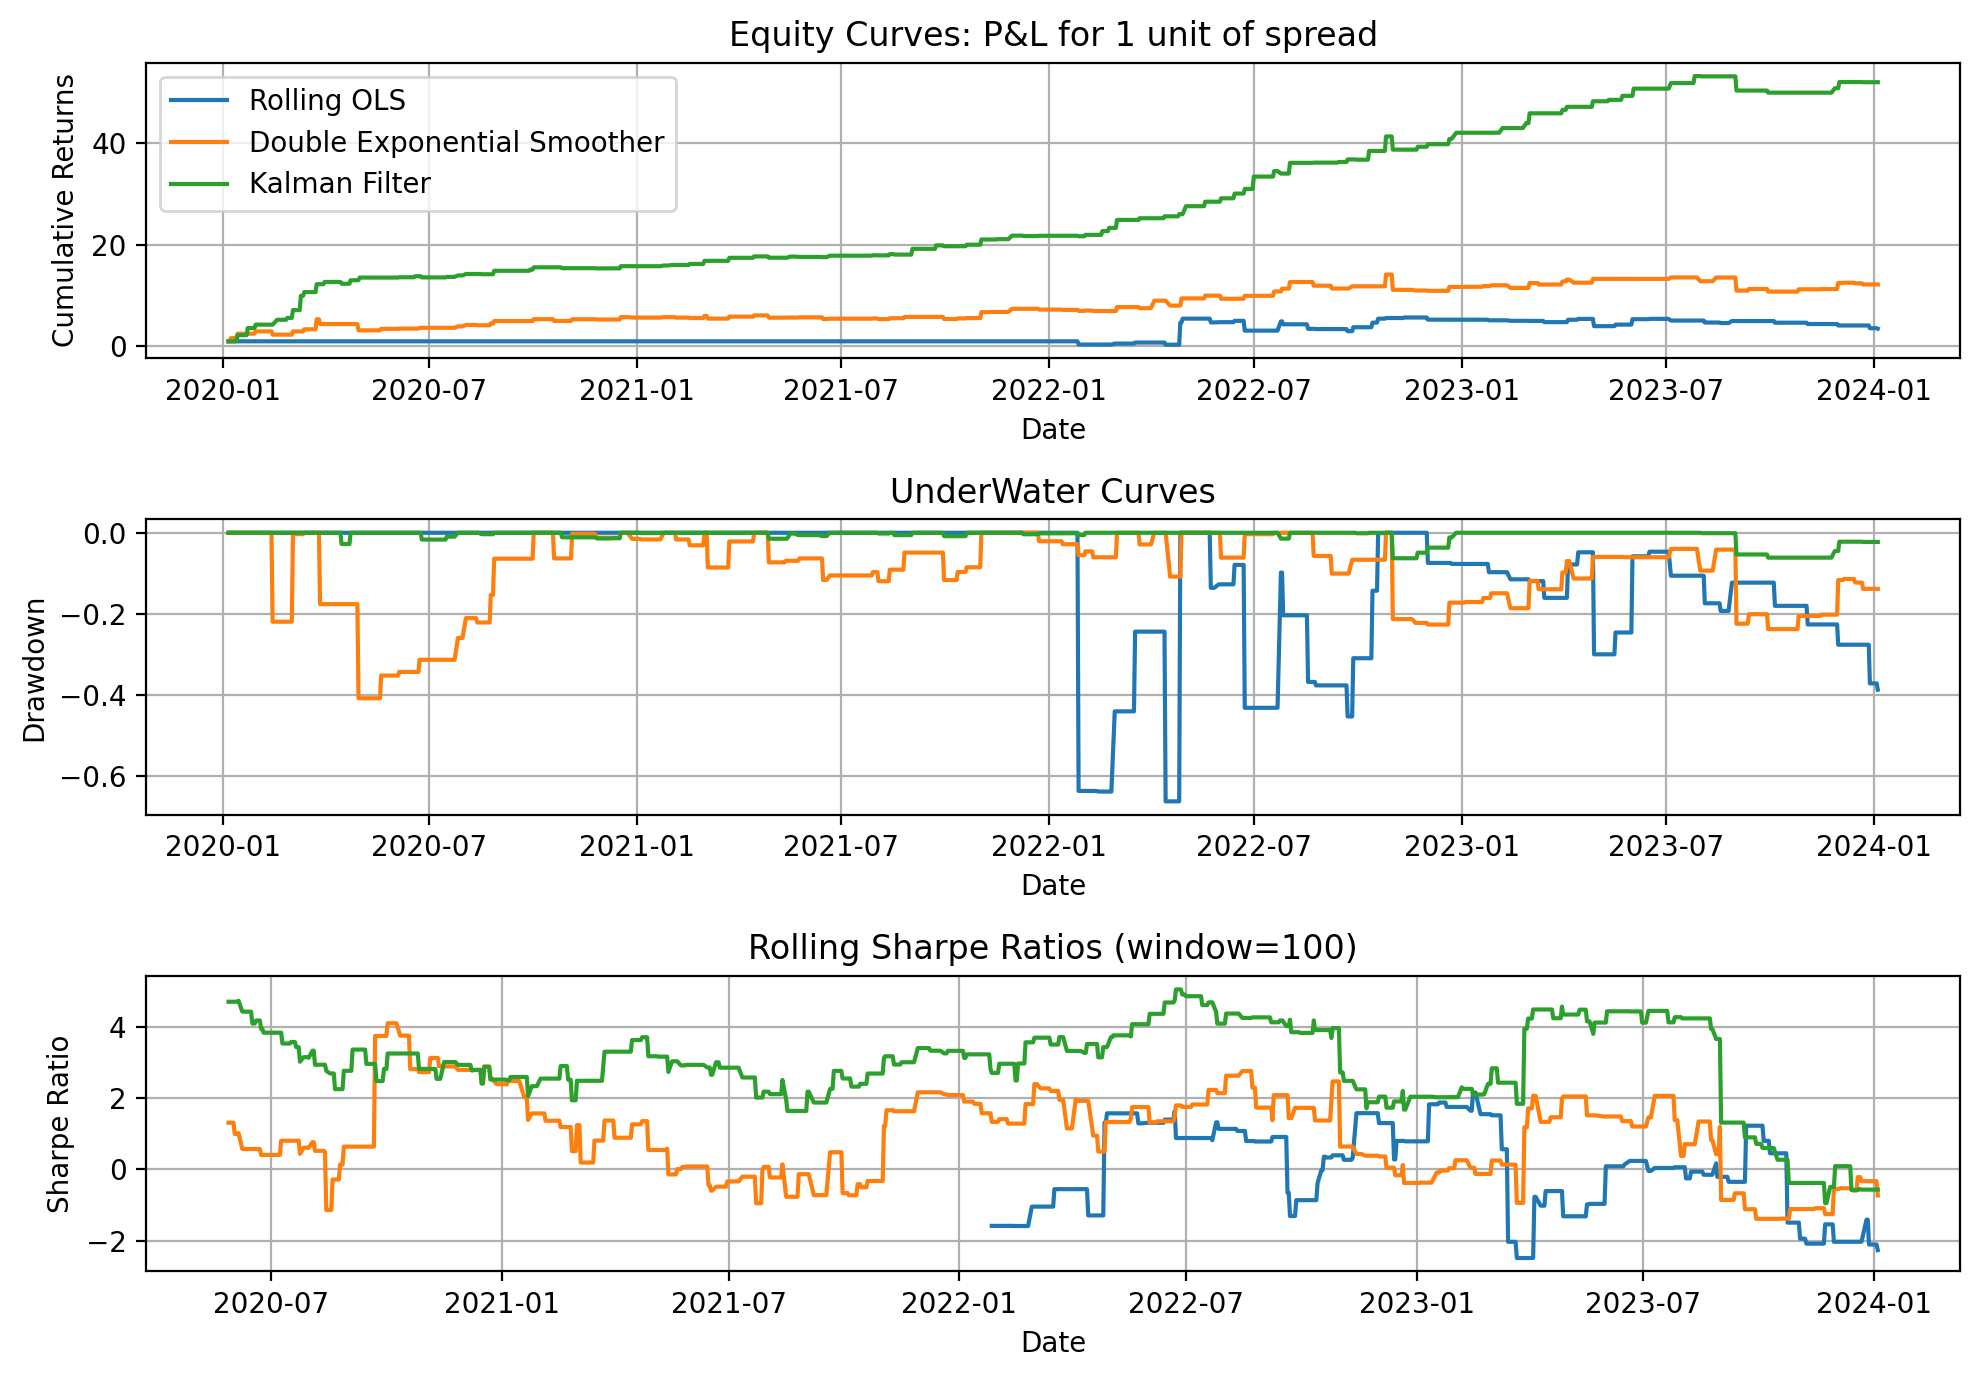

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Rolling OLS                      0.207406       0.085447      0.003727   
Double Exponential Smoother      0.781207       0.272887      0.027202   
Kalman Filter                    2.712452       1.030286      0.805290   

                             Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Rolling OLS                      0.662212                    274     0.183400   
Double Exponential Smoother      0.408061                    296     0.136431   
Kalman Filter                    0.062843                    110     0.018514   

                             Average Win  Average Loss  Profit Factor  
Rolling OLS                     0.712625     -0.430808       1.240618  
Double Exponential Smoother     0.509068     -0.495226       1.627589  
Kalman Filter                   0.758472     -0.388036       7.260100

In [29]:
kf = KalmanFilterModel(crack_pairs.dropna(), delta=1e-1)
hedge_ratio_kf = KalmanFilterHedgeRatio(kf)

backtester_kf = Backtester(crack_pairs_outsample, strategy, hedge_ratio_kf)
backtester_kf.run_backtest()

backtest_kf = {"Kalman Filter": backtester_kf}
perf.add_backtests(backtest_kf)
perf.plot_results()
perf.get_metrics()

Text(0.5, 1.0, 'Hegde Ratio Kalman Filter vs Double Exponential Smoother')

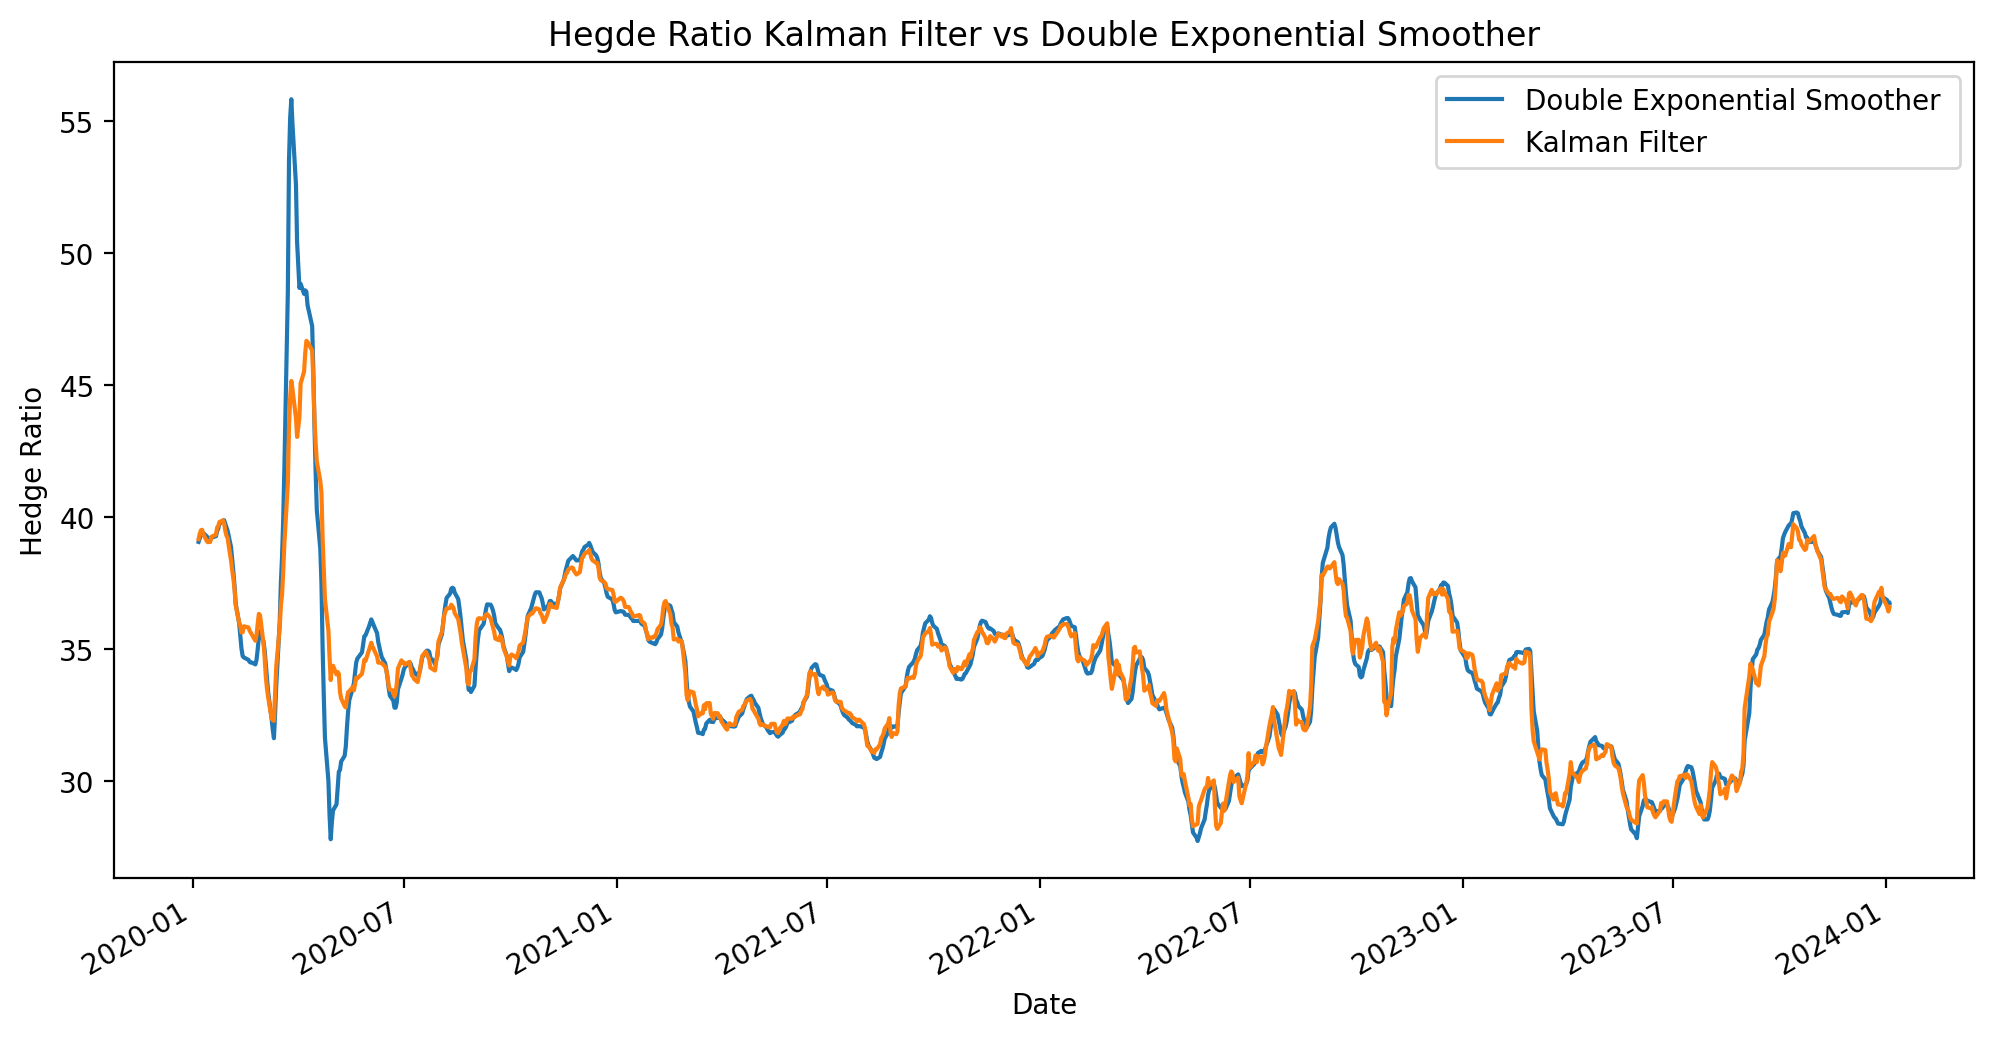

In [31]:
(-backtester_des.hedge_ratio_history["RB=F"]).plot(figsize=(12, 6), label="Double Exponential Smoother ")
(-backtester_kf.hedge_ratio_history["RB=F"]).plot(figsize=(12, 6), label="Kalman Filter")
plt.legend()
plt.ylabel("Hedge Ratio")
plt.title("Hegde Ratio Kalman Filter vs Double Exponential Smoother")


---

### 3.4. **Trading Strategy: Technical Indicators vs Statistical Models**

Pairs and basket **trading strategies** rely on a variety of tools to identify entry and exit signals. **Technical indicators** such as **Moving Averages (MA)**, **Bollinger Bands**, and **Relative Strength Index (RSI)** are widely used for their simplicity and ease of implementation. However, these methods may struggle to fully account for the complex dynamics of spreads, particularly in volatile or highly correlated markets.

To overcome these challenges, this section explores mathematical and **statistical models** like **Hidden Markov Models (HMM)**, **Ornstein-Uhlenbeck (OU) processes**, and **Kalman Filters**, which can provide a more nuanced and adaptive framework for signal generation. The goal is to assess whether these advanced models outperform traditional technical indicators or if simpler strategies are sufficient for robust trading.

Since the Kalman Filter hedge ratio model showed the best performance, we are going to use it in this section.

#### 3.4.1. **Technical Indicators**

#### **Moving Averages**

Moving Averages (MA) are used to smooth noise in price or spread data, helping to identify trend direction. The **Moving Average Crossover** strategy is a simple yet effective method to identify trends in spreads. It involves calculating two moving averages:

1. **Short-Term Moving Average (MA)**: Tracks recent price movements and is more sensitive to changes.

2. **Long-Term Moving Average (MA)**: Tracks broader trends and smooths out noise.

**Signal Generation**:
- **Buy Signal**: When the short-term MA crosses above the long-term MA, indicating a potential upward trend in the spread.

- **Sell Signal**: When the short-term MA crosses below the long-term MA, indicating a potential downward trend.

Even though this strategy does not make particular sense for pairs trading as it is more relevent for assets with trends, we still present the results.

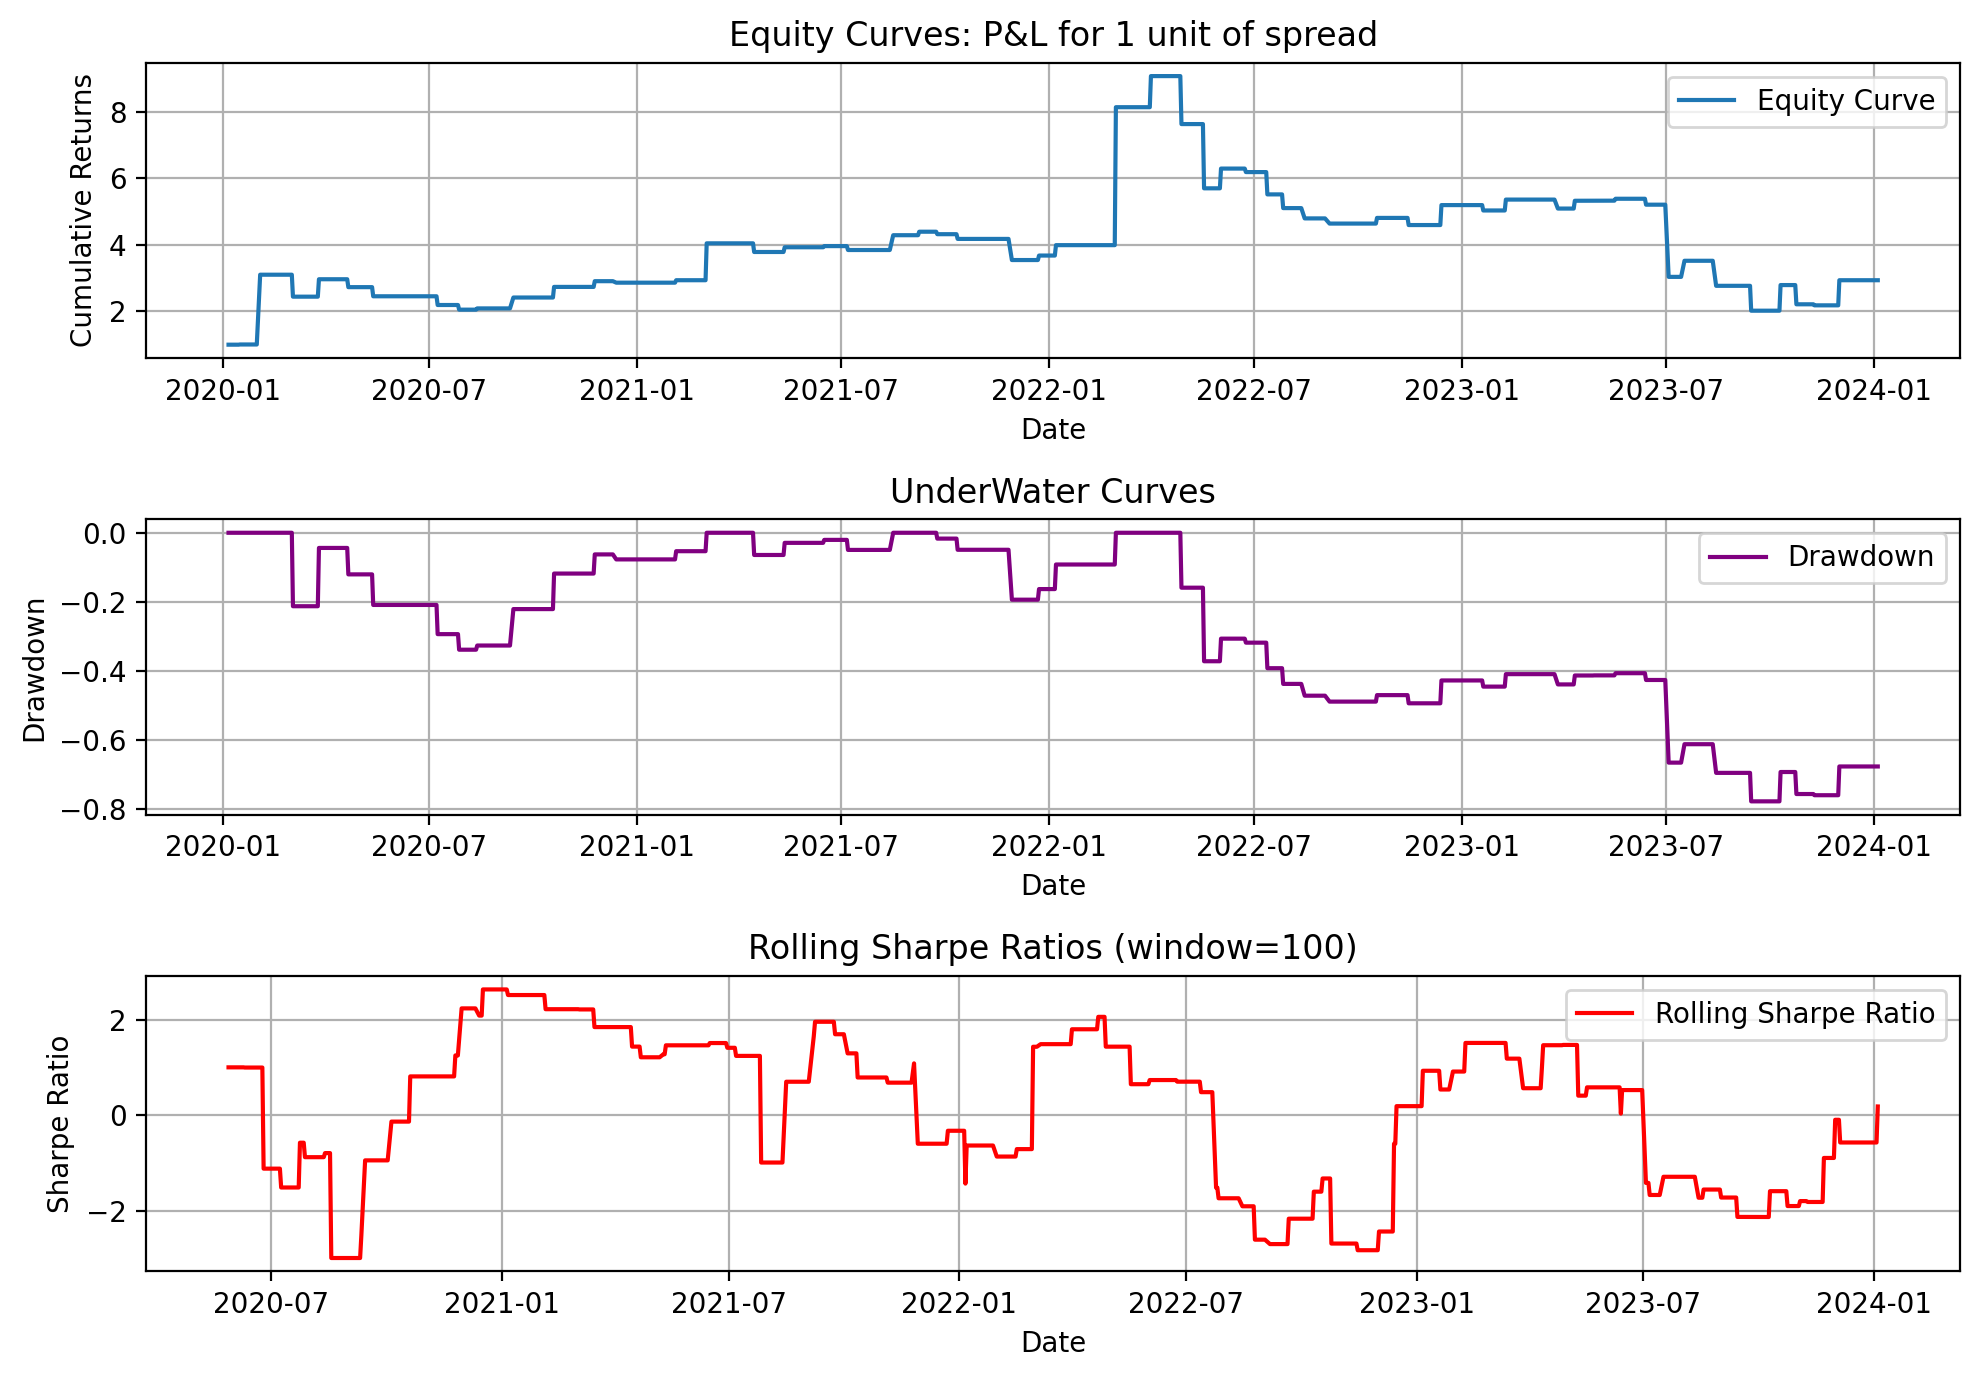

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Moving Average Crossover      0.151333       0.055582      0.002471   

                          Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Moving Average Crossover      0.777084                    425     0.355539   

                          Average Win  Average Loss  Profit Factor  
Moving Average Crossover     0.551791     -0.480115       1.149288

In [58]:
strategy_ma = MovingAverageCrossoverStrategy(short_window=7, long_window=13)
backtester_ma = Backtester(crack_pairs_outsample, strategy_ma, hedge_ratio_des)
backtester_ma.run_backtest()

backtest_ma = {"Moving Average Crossover": backtester_ma}
perf_strat = PerformanceAnalyzer(backtest_ma)
perf_strat.plot_results()
perf_strat.get_metrics()

#### **Relative Strength Index (RSI)**

The **Relative Strength Index (RSI)** is a momentum oscillator that measures the speed and magnitude of recent price changes. It generates values between 0 and 100, providing insights into overbought or oversold conditions in the spread.

**Formula**:
The RSI is calculated as:
$$
RSI = 100 - \frac{100}{1 + RS}
$$

Where:
- $RS = \frac{\text{Average Gain over } n \text{ periods}}{\text{Average Loss over } n \text{ periods}}$

**Signal Generation**:
- **Buy Signal**: When the RSI drops below 30, indicating the spread is oversold and may rebound.

- **Sell Signal**: When the RSI rises above 70, indicating the spread is overbought and may decline.

- Close the position when it goes back near the level of 50.

RSI is particularly effective for timing reversals in the spread but can produce false signals in trending markets. To create robust signals, RSI is often combined with other indicators, which is outside the scope of this notebook.

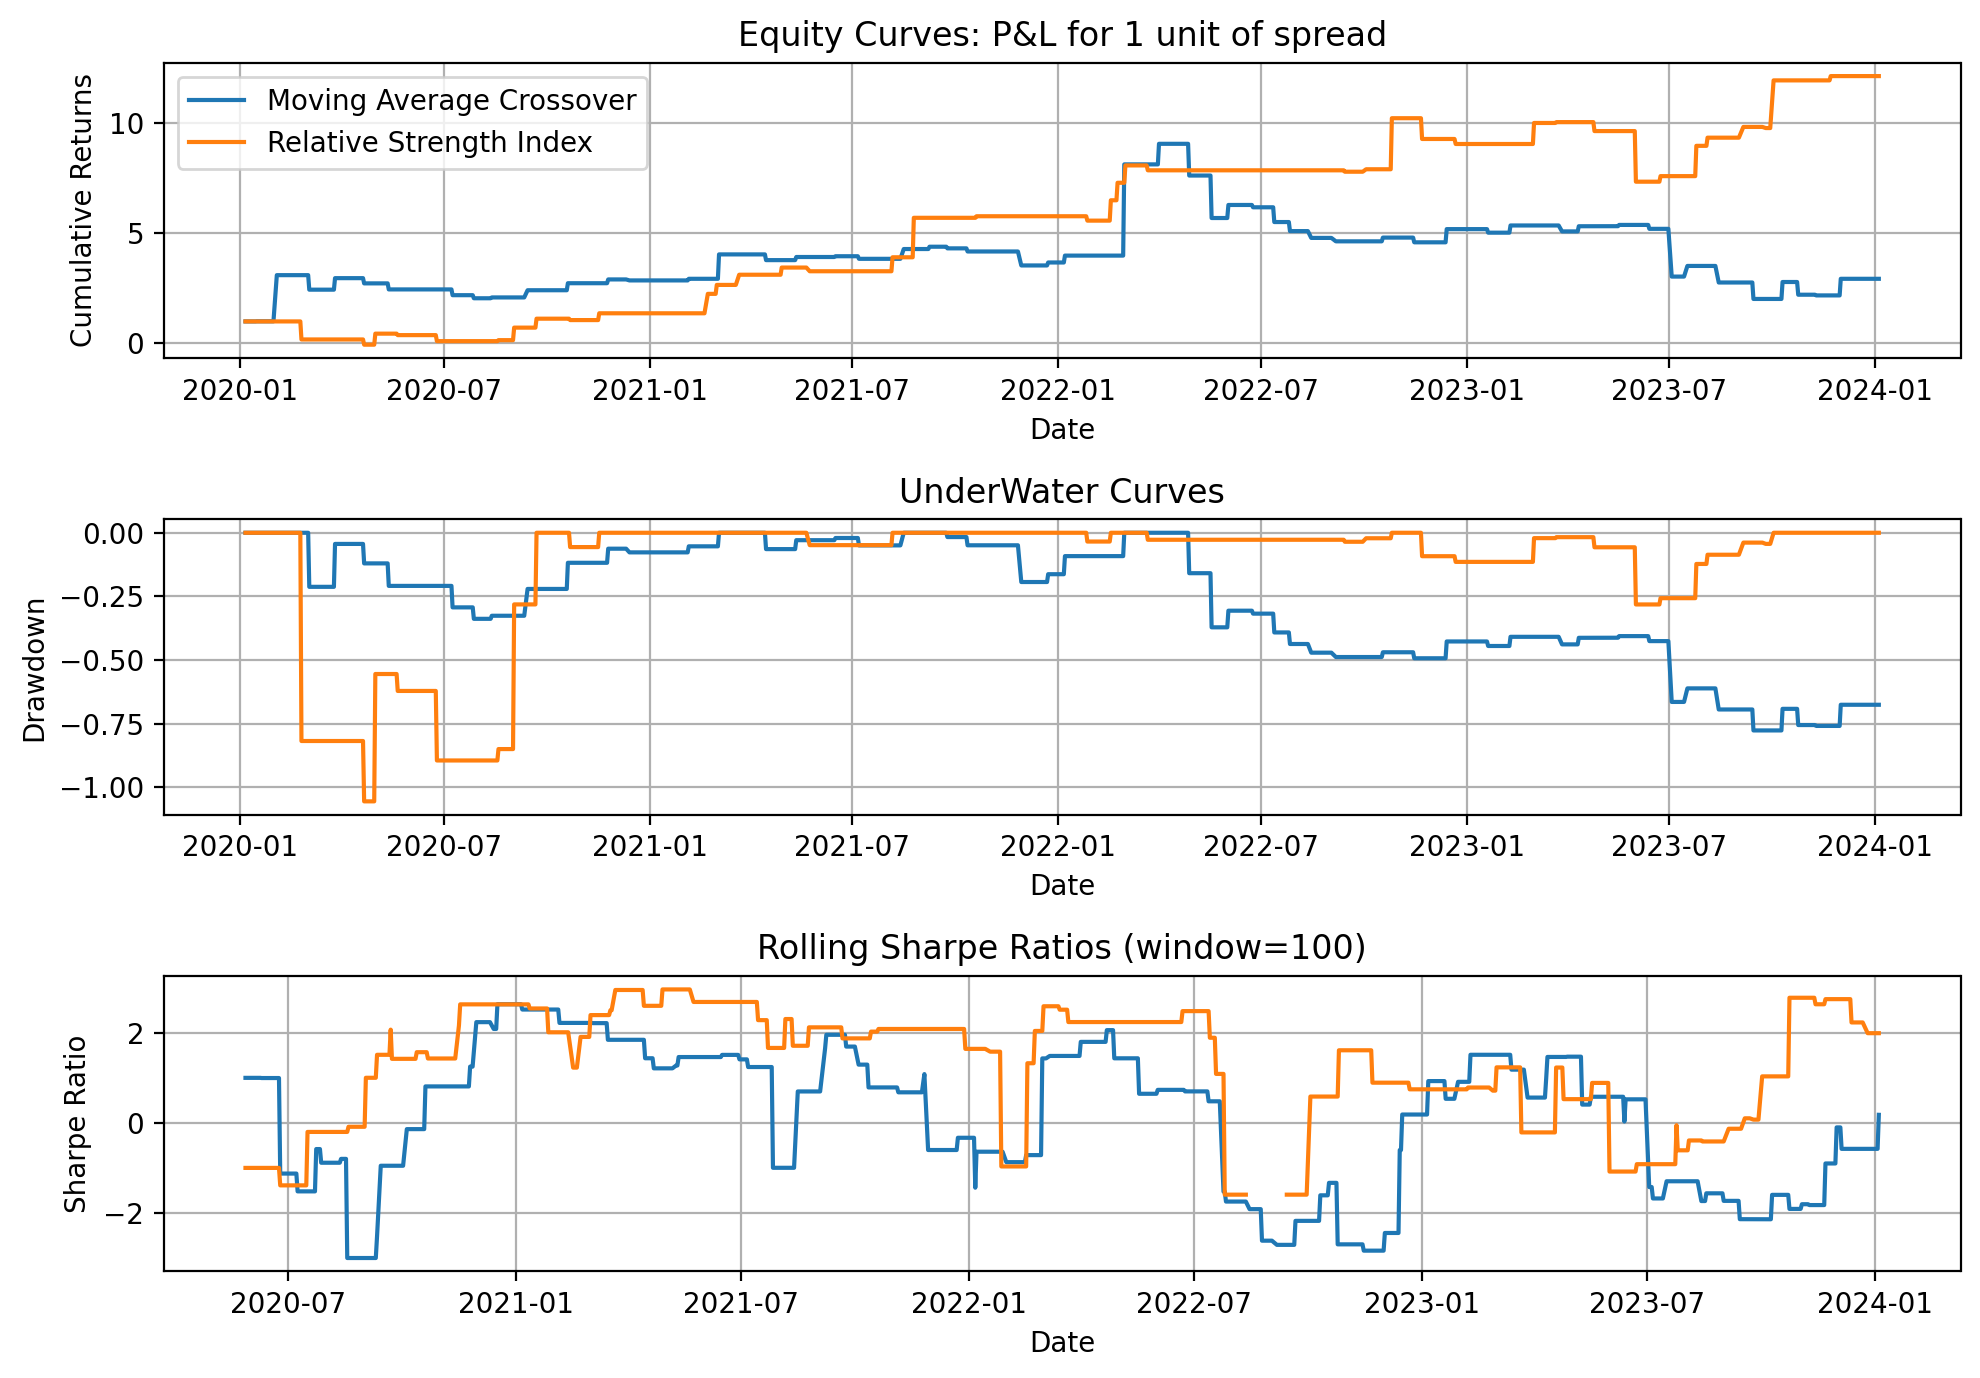

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Moving Average Crossover      0.151333       0.055582      0.002471   
Relative Strength Index       1.044966       0.291239      0.010465   

                          Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Moving Average Crossover      0.777084                    425     0.355539   
Relative Strength Index       1.055856                    214     0.301201   

                          Average Win  Average Loss  Profit Factor  
Moving Average Crossover     0.551791     -0.480115       1.149288  
Relative Strength Index      0.687105     -0.431374       2.844337

In [59]:
strategy_rsi = RelativeStrengthIndexStrategy()
backtester_rsi = Backtester(crack_pairs_outsample, strategy_rsi, hedge_ratio_des)
backtester_rsi.run_backtest()

backtest_rsi = {"Relative Strength Index": backtester_rsi}
perf_strat.add_backtests(backtest_rsi)
perf_strat.plot_results()
perf_strat.get_metrics()

#### **Bollinger Bands**

**Bollinger Bands** are a technical indicator used to measure volatility and identify mean-reversion opportunities in the spread. They consist of three lines:

1. **Moving Average (MA)**: The central line, typically a simple moving average (SMA) of the spread over a specified period.

2. **Upper Band**: $\text{MA} + k \cdot \sigma$, where $\sigma$ is the standard deviation of the spread, and $k$ is a user-defined multiplier (commonly 2).

3. **Lower Band**: $\text{MA} - k \cdot \sigma$.

**Signal Generation**:
- **Buy Signal**: When the spread breaches the lower band, indicating it is oversold and may revert to the mean.

- **Sell Signal**: When the spread breaches the upper band, indicating it is overbought and may revert to the mean.

- Close positions when the spread returns to the moving average.

Bollinger Bands are particularly effective for pairs trading because they provide dynamic thresholds for the spread's range, making them ideal for timing entry and exit points.

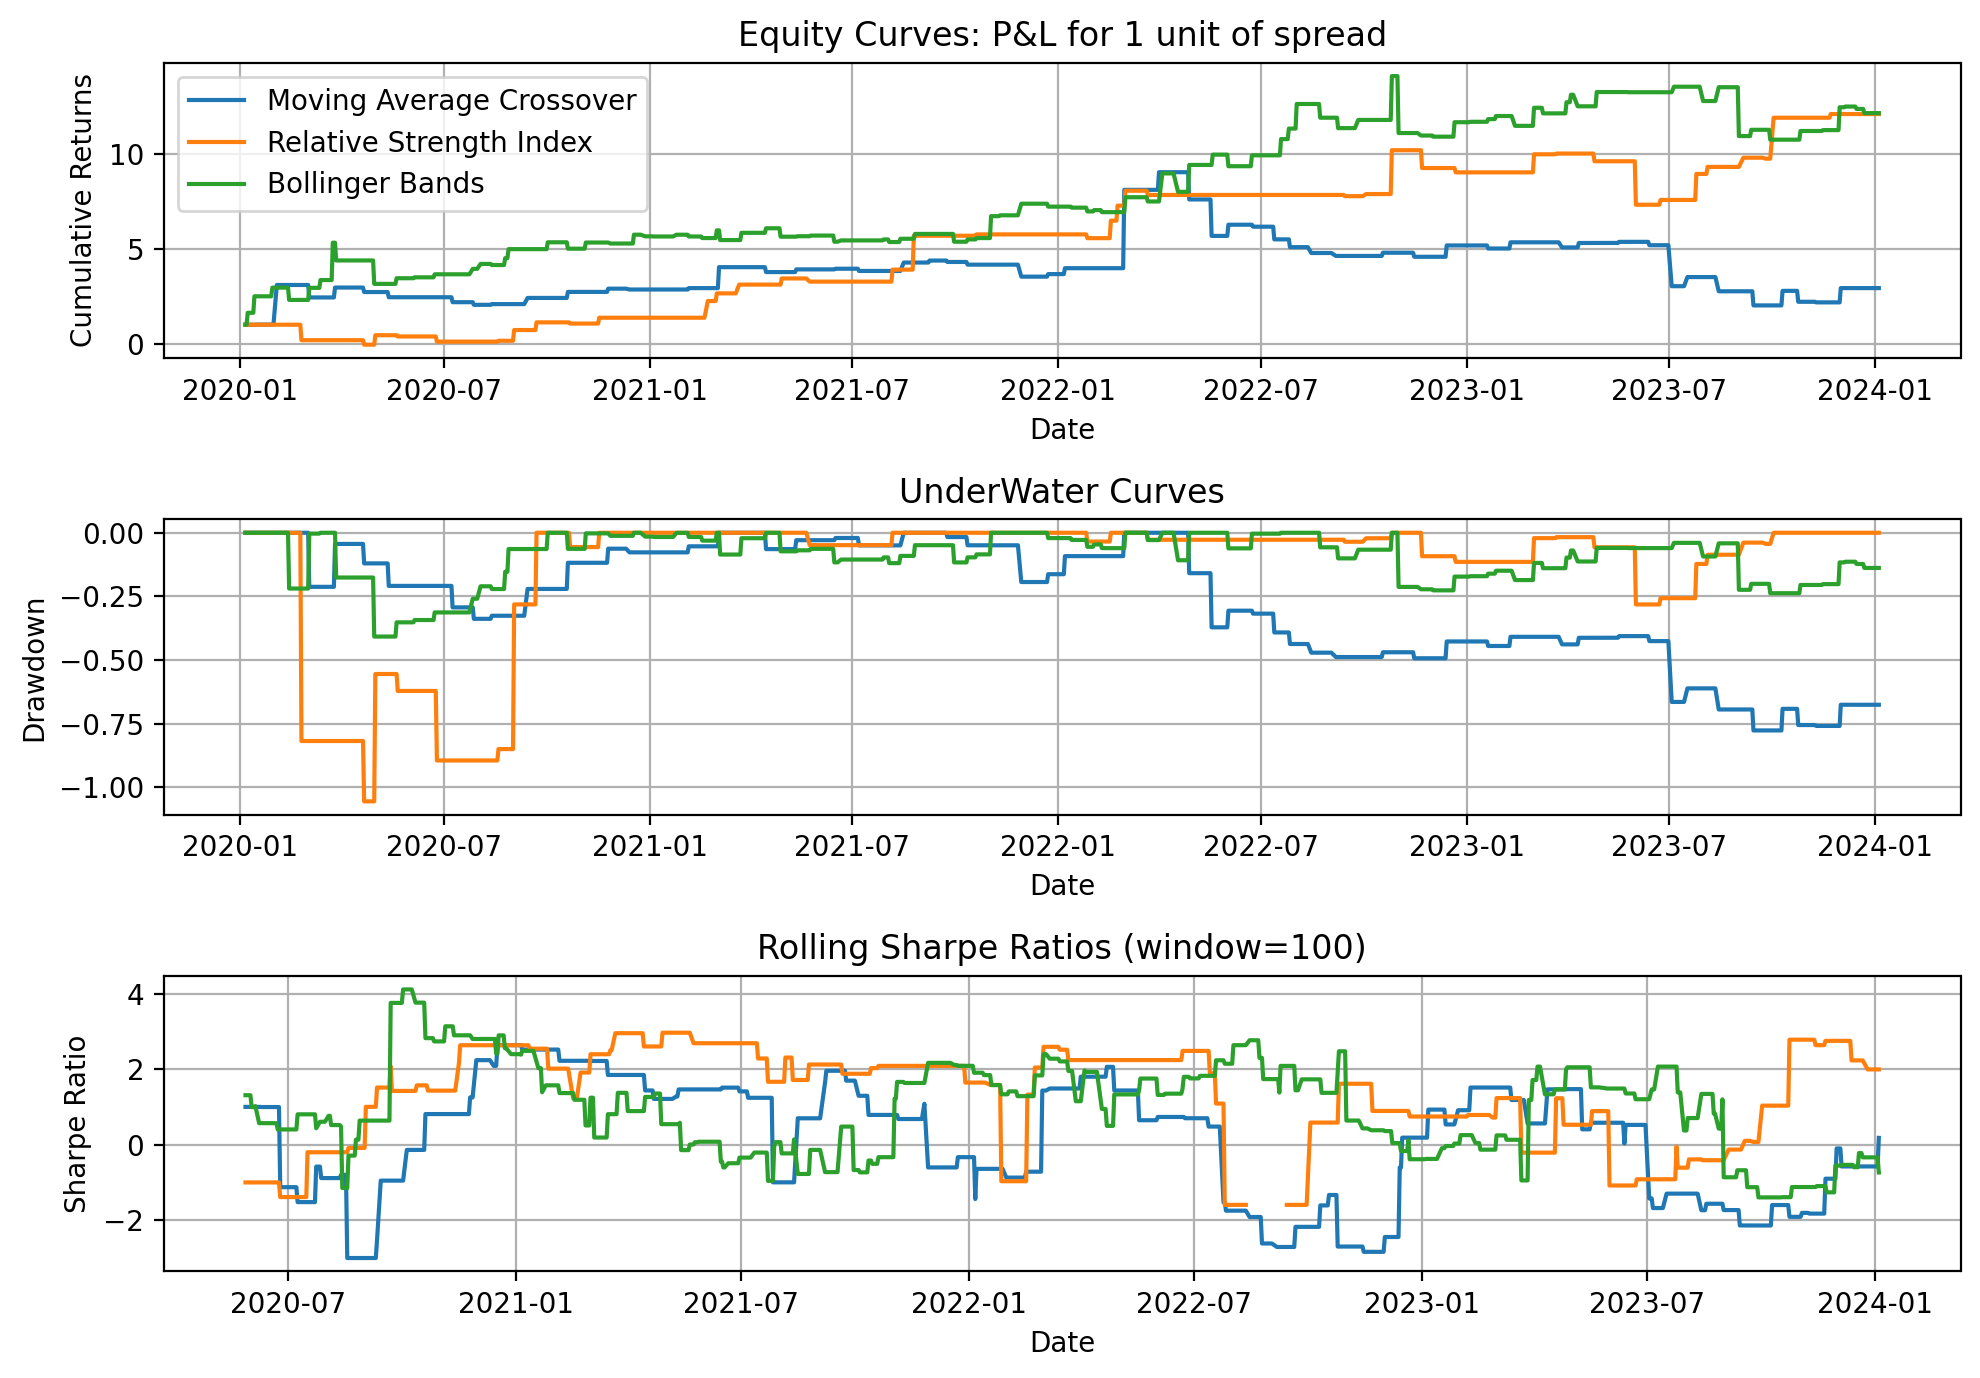

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Moving Average Crossover      0.151333       0.055582      0.002471   
Relative Strength Index       1.044966       0.291239      0.010465   
Bollinger Bands               0.781207       0.272887      0.027202   

                          Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Moving Average Crossover      0.777084                    425     0.355539   
Relative Strength Index       1.055856                    214     0.301201   
Bollinger Bands               0.408061                    296     0.136431   

                          Average Win  Average Loss  Profit Factor  
Moving Average Crossover     0.551791     -0.480115       1.149288  
Relative Strength Index      0.687105     -0.431374       2.844337  
Bollinger Bands              0.509068     -0.495226       1.627589

In [60]:
strategy_bb = BollingerBandsStrategy()
backtester_bb = Backtester(crack_pairs_outsample, strategy_bb, hedge_ratio_des)
backtester_bb.run_backtest()

backtest_bb = {"Bollinger Bands": backtester_bb}
perf_strat.add_backtests(backtest_bb)
perf_strat.plot_results()
perf_strat.get_metrics()

#### 3.4.1. **Statistical Models**

#### **Kalman Filter**

While its main application is mostly known for the estimation of a dynamic hedge ratio, it can also be used to generate trading signals. 
The strategy uses the residual $e_t = \hat{y_t} - y_t$ between the forecast and the true value of the first leg $y_t$, and the standard deviation of the prediction $\sqrt{Q_t}$ to define trading signals:

- **Long Signal**:
  $$
  e_t < -k \sqrt{Q_t}
  $$
  Enter a long position when the residual is significantly below the predicted value (e.g., spread is undervalued).

- **Short Signal**:
  $$
  e_t > k \sqrt{Q_t}
  $$
  Enter a short position when the residual is significantly above the predicted value (e.g., spread is overvalued).

- **Close Position**:
  Close the position when:
  $$
  |e_t| \leq k \sqrt{Q_t}
  $$
  indicating the residual has reverted within the acceptable threshold.

Here, $k$ is a user-defined threshold (commonly $k=1$), controlling the sensitivity of the signals.

This method is inherently **forward-looking** compared to the technical indicators discussed earlier, which rely on historical data to generate signals.

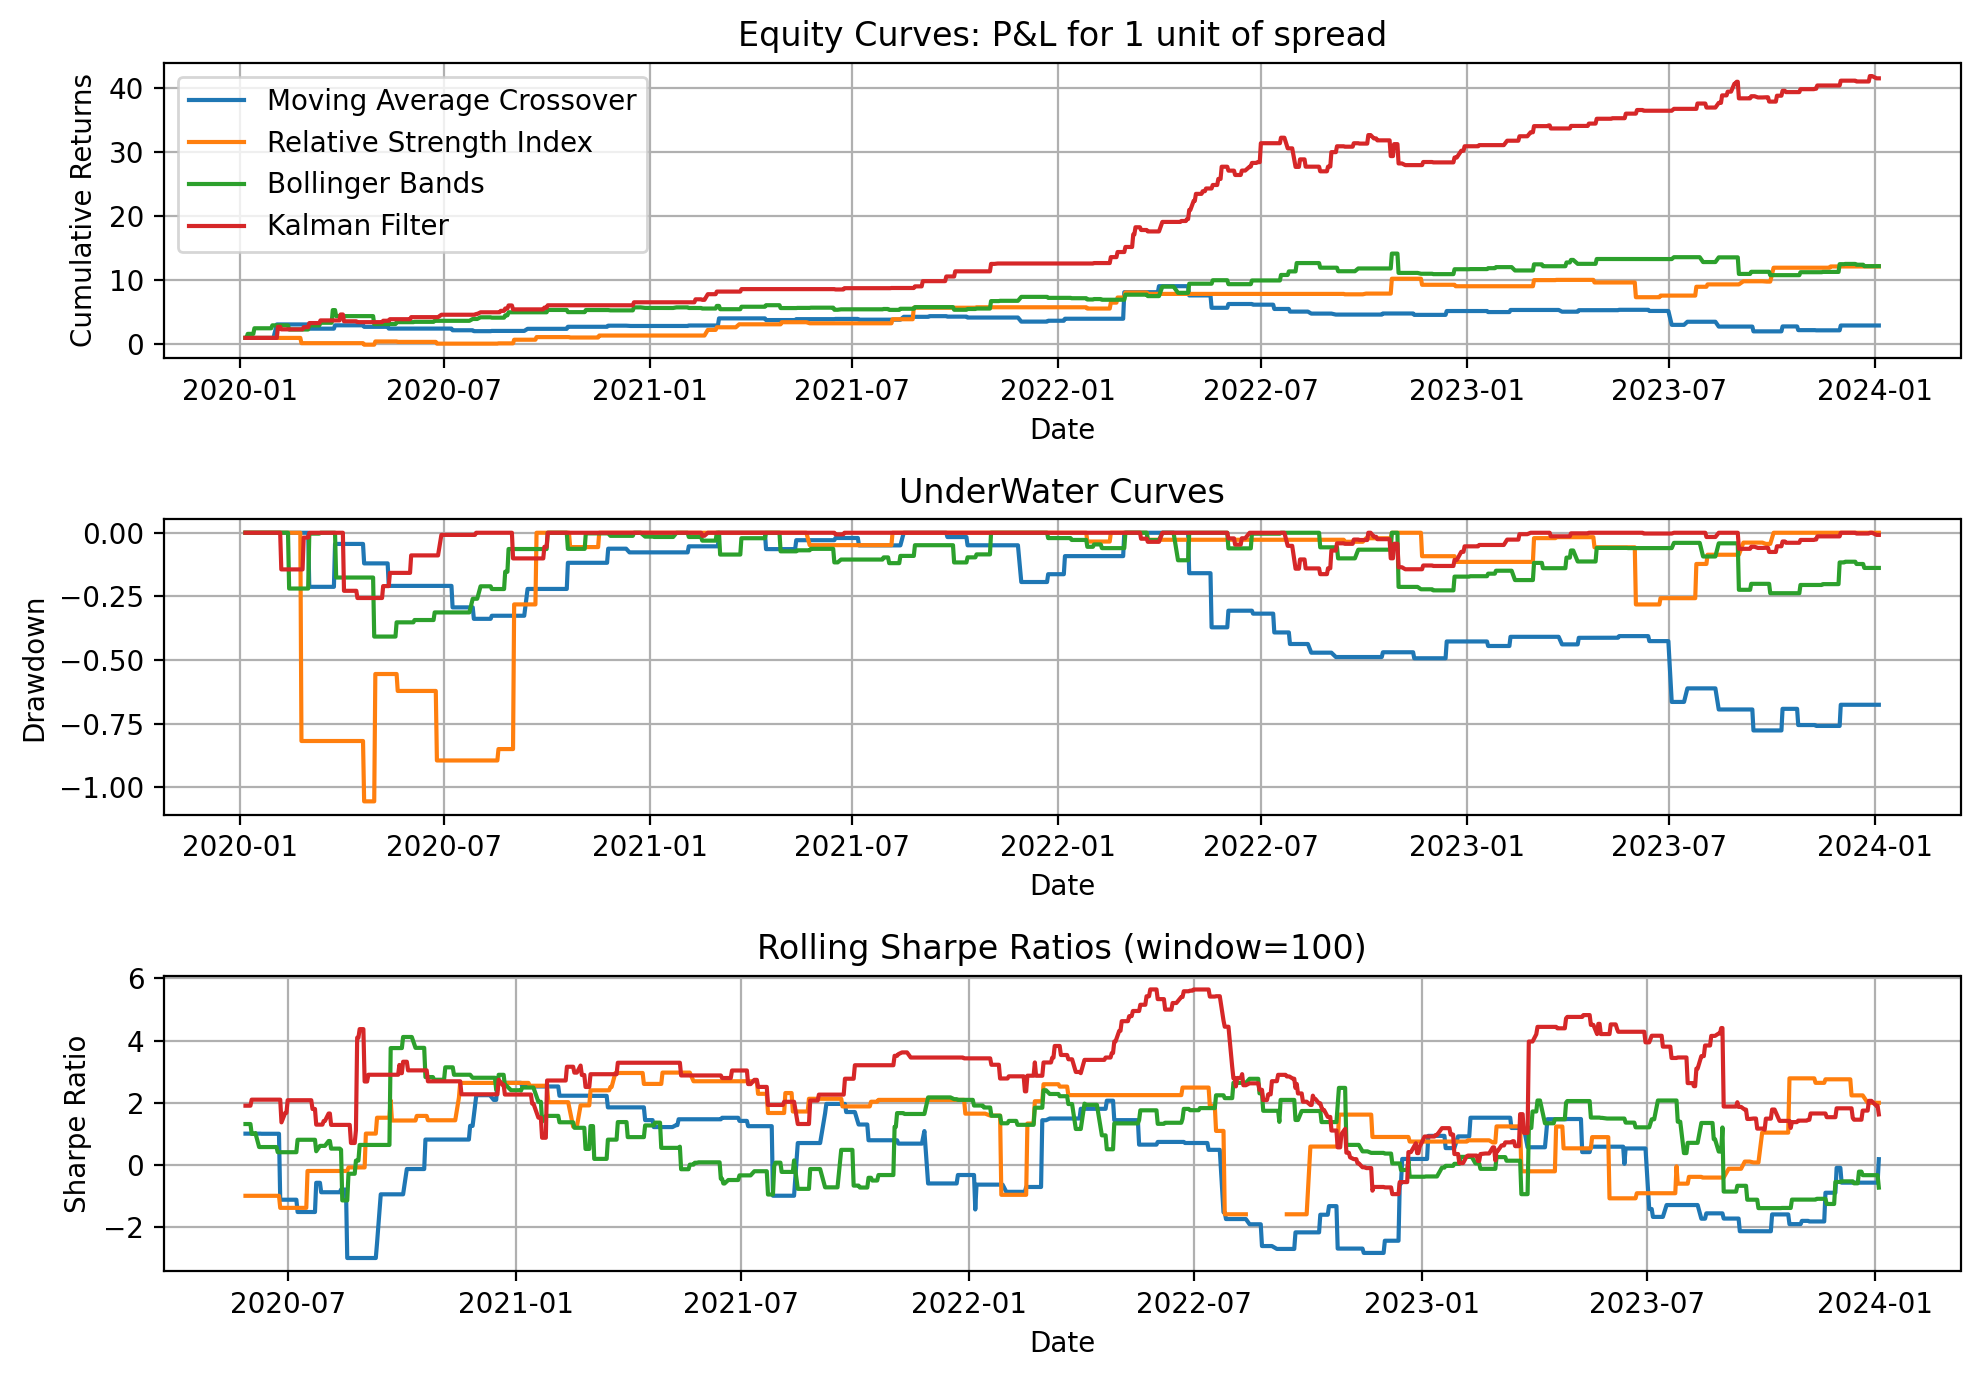

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Moving Average Crossover      0.151333       0.055582      0.002471   
Relative Strength Index       1.044966       0.291239      0.010465   
Bollinger Bands               0.781207       0.272887      0.027202   
Kalman Filter                 1.963229       0.736305      0.156531   

                          Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Moving Average Crossover      0.777084                    425     0.355539   
Relative Strength Index       1.055856                    214     0.301201   
Bollinger Bands               0.408061                    296     0.136431   
Kalman Filter                 0.256482                     95     0.063568   

                          Average Win  Average Loss  Profit Factor  
Moving Average Crossover     0.551791     -0.480115       1.149288  
Relative Strength Index      0.687105     -0.431374       2.844337  
Bollinger Bands              0.509068     -0.495226       1.627589  
Kalman Filter                0.694720     -0.733904       2.778755

In [61]:
strategy_kf = KalmanFilterStrategy(kf, entry_threshold=1, exit_threshold=1)
backtester_kf = Backtester(crack_pairs_outsample, strategy_kf, hedge_ratio_des)
backtester_kf.run_backtest()

backtest_kf = {"Kalman Filter": backtester_kf}
perf_strat.add_backtests(backtest_kf)
perf_strat.plot_results()
perf_strat.get_metrics()

#### **Ornstein-Uhlenbeck**

The Ornstein-Uhlenbeck (OU) process models the spread as a mean-reverting stochastic process, where the dynamics of the spread (\(S_t\)) are governed by the following Stochastic Differential Equation (SDE):
   $$
   dS_t = \kappa (\mu - S_t) dt + \sigma dW_t
   $$
   
Where:
- $\mu$: Long-term mean of the spread.
- $\kappa > 0$: Speed of mean reversion (how quickly the spread reverts to \(\mu\)).
- $\sigma$: Volatility of the spread.
- $dW_t$: Wiener process (random noise).

Instead of a purely backward-looking approach, this strategy incorporates a predictive element by optionally using the forecasted spread:
$$
\hat{S}_t = S_t + \theta (\mu - S_t)
$$
where $\hat{S}_t$ accounts for the expected mean reversion. Alternatively, the current spread ($S_t$) can be used directly, avoiding the forecast adjustment.

Signals are then generated based on the Z-score of the spread using a standard Z-score trading approach:
$$
z_t = \frac{\hat{S}_t - \mu}{\sigma}
$$
or
$$
z_t = \frac{S_t - \mu}{\sigma}
$$
depending on whether the forecast is used.


Similar to the Kalman Filter, this strategy is **forward-looking** when the forecast is applied, as it anticipates future spread movements. If the forecast is not used, the strategy operates more like traditional backward-looking approaches.

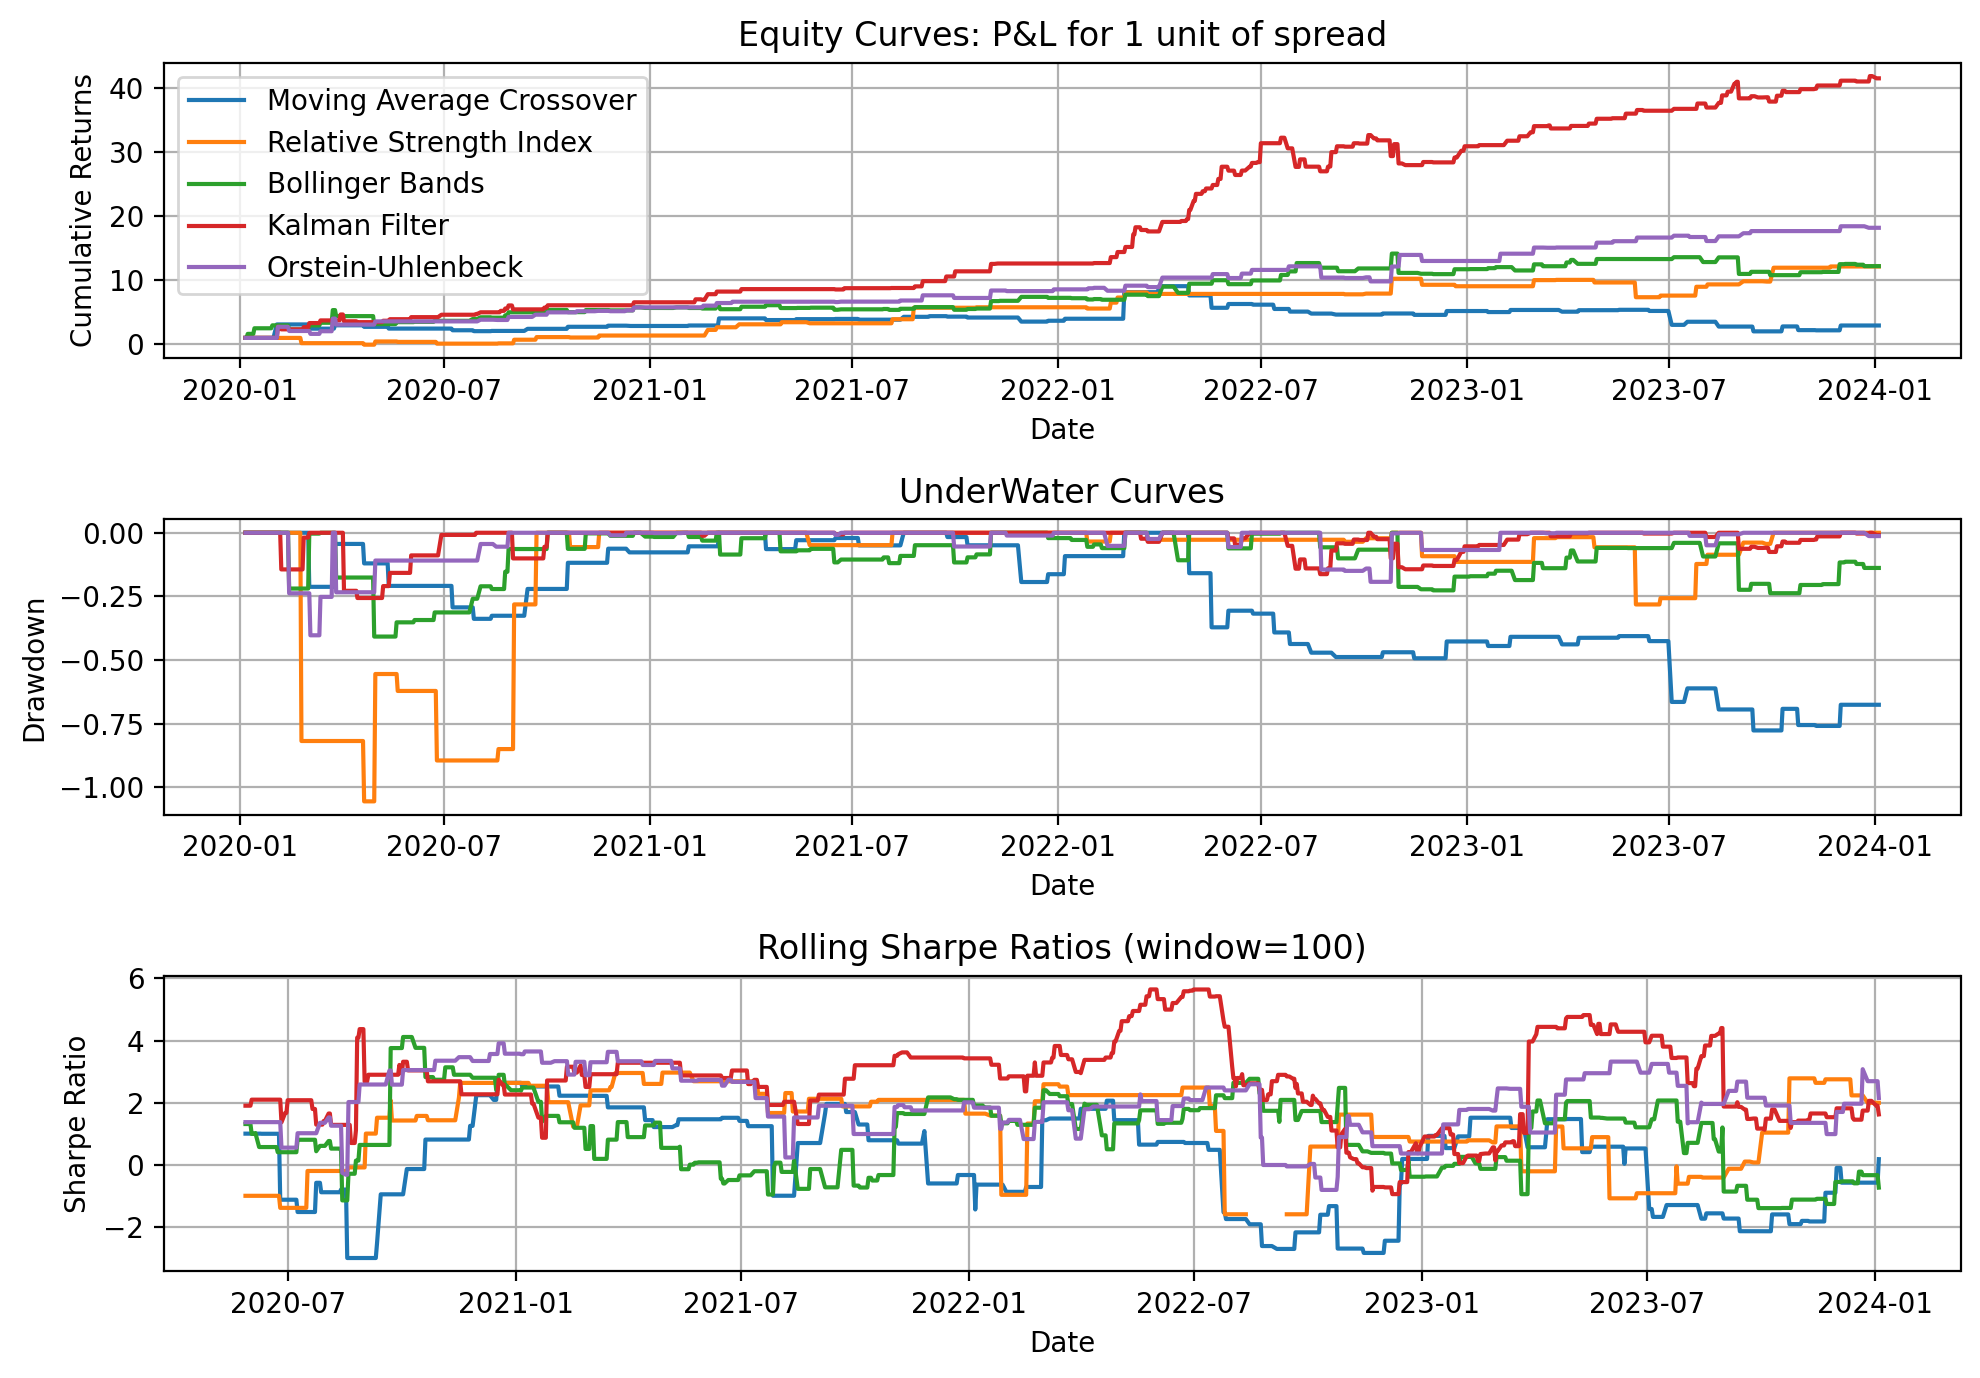

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Moving Average Crossover      0.151333       0.055582      0.002471   
Relative Strength Index       1.044966       0.291239      0.010465   
Bollinger Bands               0.781207       0.272887      0.027202   
Kalman Filter                 1.963229       0.736305      0.156531   
Orstein-Uhlenbeck             1.449857       0.621251      0.042256   

                          Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Moving Average Crossover      0.777084                    425     0.355539   
Relative Strength Index       1.055856                    214     0.301201   
Bollinger Bands               0.408061                    296     0.136431   
Kalman Filter                 0.256482                     95     0.063568   
Orstein-Uhlenbeck             0.403056                    107     0.076468   

                          Average Win  Average Loss  Profit Factor  
Moving Average Crossover     0.551791     -0.480115       1.149288  
Relative Strength Index      0.687105     -0.431374       2.844337  
Bollinger Bands              0.509068     -0.495226       1.627589  
Kalman Filter                0.694720     -0.733904       2.778755  
Orstein-Uhlenbeck            0.596718     -0.424549       3.021902

In [62]:
strategy_ou = OrnsteinUhlenbeckStrategy(use_forecast=True)
backtester_ou = Backtester(crack_pairs_outsample, strategy_ou, hedge_ratio_des)
backtester_ou.run_backtest()

backtest_ou = {"Orstein-Uhlenbeck": backtester_ou}
perf_strat.add_backtests(backtest_ou)
perf_strat.plot_results()
perf_strat.get_metrics()

#### **Hidden Markov Model (HMM)**

The Hidden Markov Model (HMM) assumes that the spread transitions between a set of **unobservable (hidden) states**, each characterized by:

- **Mean ($\mu_\text{state}$)**: The expected value of the spread within a specific state.
- **Variance ($\sigma^2_\text{state}$)**: The volatility or uncertainty of the spread in that state.

These hidden states capture the latent dynamics of the spread, such as market regimes (e.g., low volatility, high volatility, trending behavior). The transitions between these states are governed by a **transition matrix $P$**, which describes the probabilities of moving from one state to another in the next time step.

The **transition probability** from state $i$ to state $j$ is given by:
$$
p_{i,j} = P(X_{n+1} = j \mid X_n = i)
$$
Where:
- $p_{i,j}$ is the probability of transitioning to state $j$ at time $n+1$ given the system is currently in state $i$ at time $n$.
- $P$ is a square matrix of size $(\text{n\_states} \times \text{n\_states})$, where $\sum_j p_{i,j} = 1$ for each state $i$ (rows sum to 1).

The HMM dynamically estimates the hidden states and their parameters over a rolling window, enabling real-time signal generation. Optionally, predicted state probabilities can be used to anticipate future movements based on the transition matrix.

Signals are generated using a Z-score trading strategy:
$$
z_t = \frac{S_t - \mu_\text{state}}{\sigma_\text{state}} \quad \text{(current state)} \quad \text{or} \quad z_t = \frac{\hat{S}_t - \mu_\text{state}}{\sigma_\text{state}} \quad \text{(predicted state)}
$$

Only states with probabilities exceeding a defined threshold are considered for trading. This strategy is forward-looking when prediction is applied, leveraging the HMM’s ability to infer and anticipate hidden market regimes.

In [63]:
strategy_hmm = HMMZScoreStrategy(use_predicted_prob=True)
backtester_hmm = Backtester(crack_pairs_outsample, strategy_hmm, hedge_ratio_des)
backtester_hmm.run_backtest()

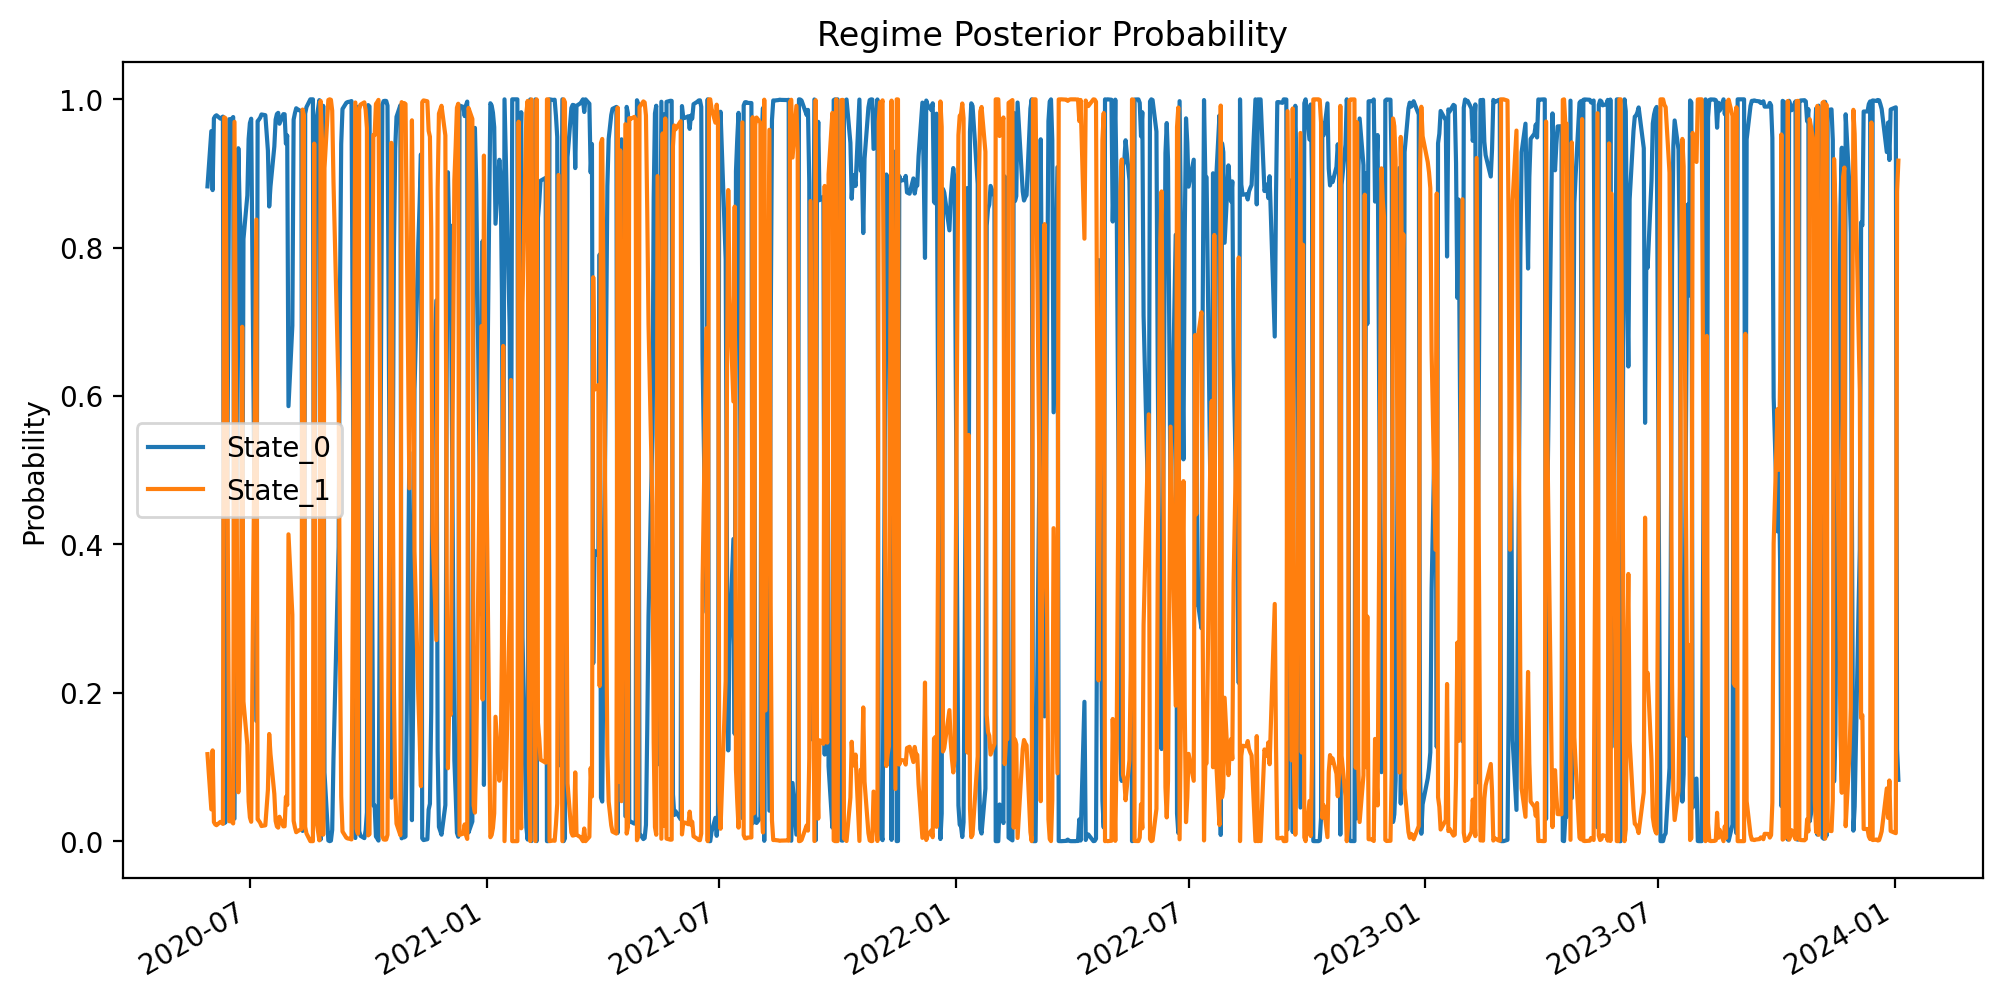

<Axes: xlabel='Date'>

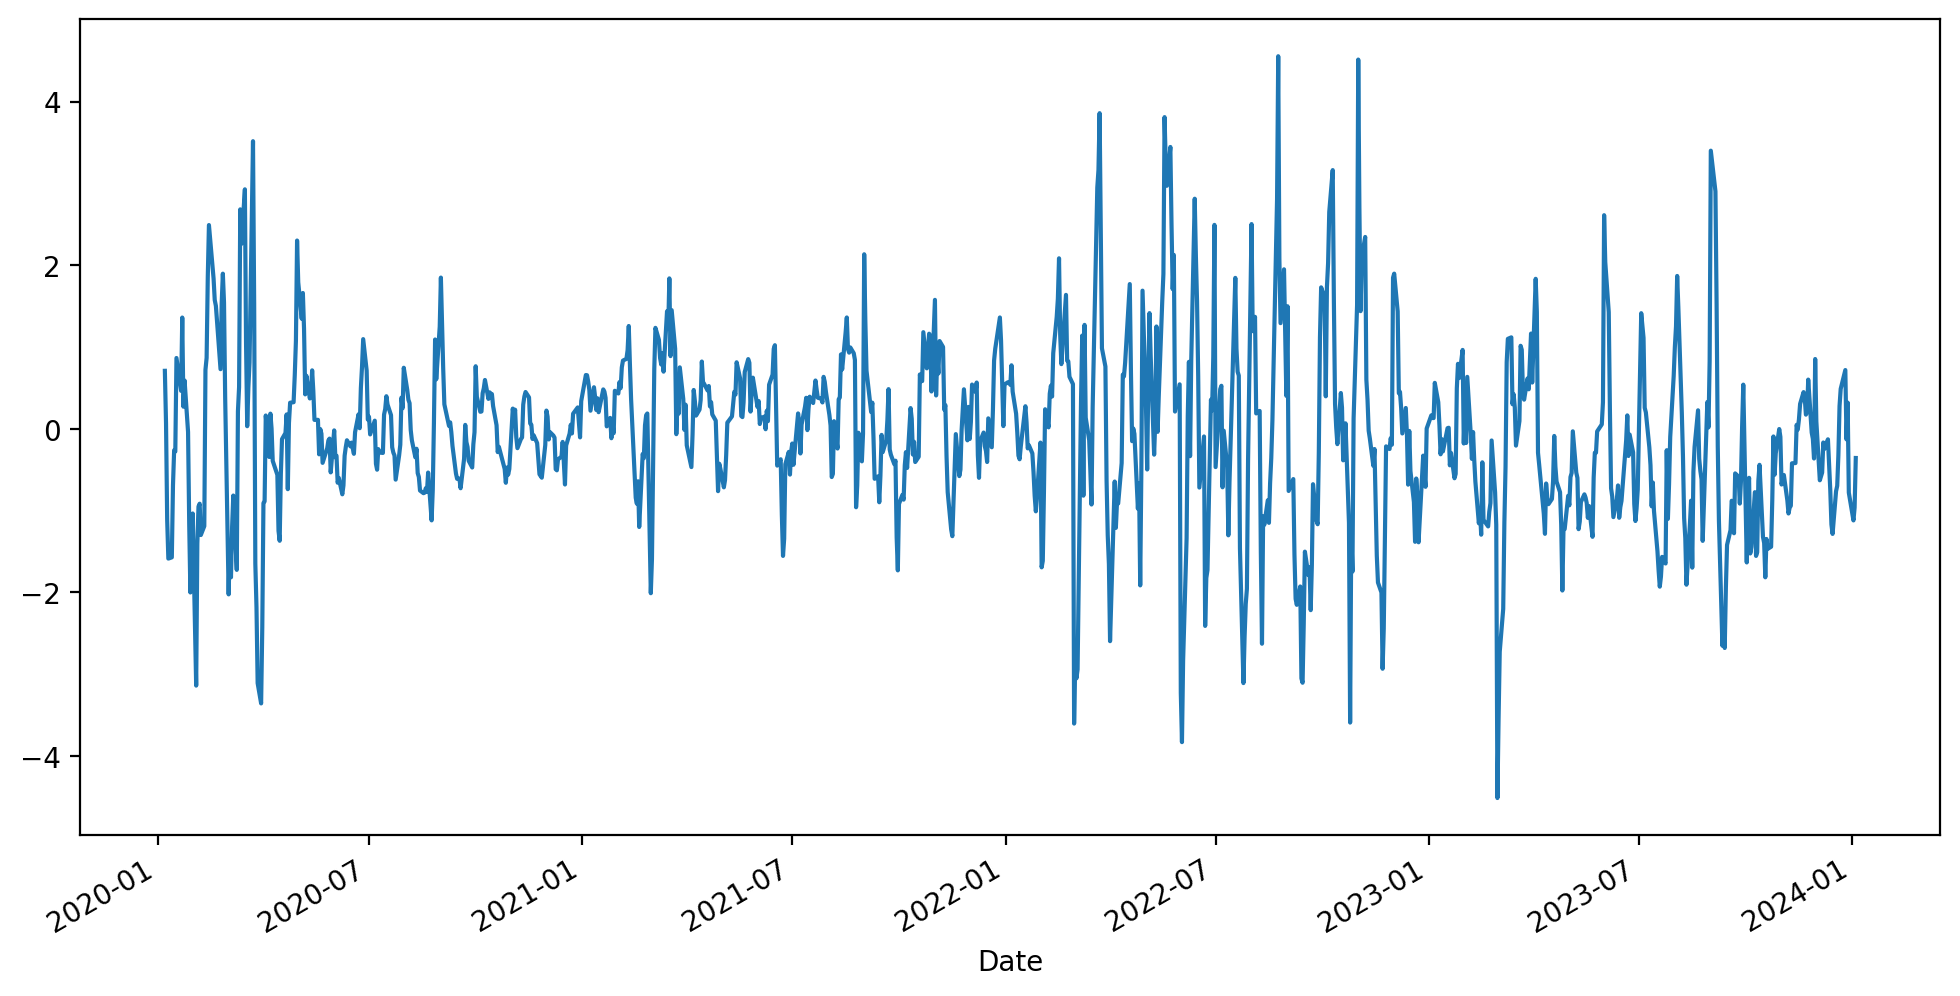

In [64]:
strategy_hmm.state_probs.plot(figsize=(12, 6))
plt.ylabel("Probability")
plt.title("Regime Posterior Probability")
plt.show()
backtester_hmm.spreads.plot(figsize=(12, 6))

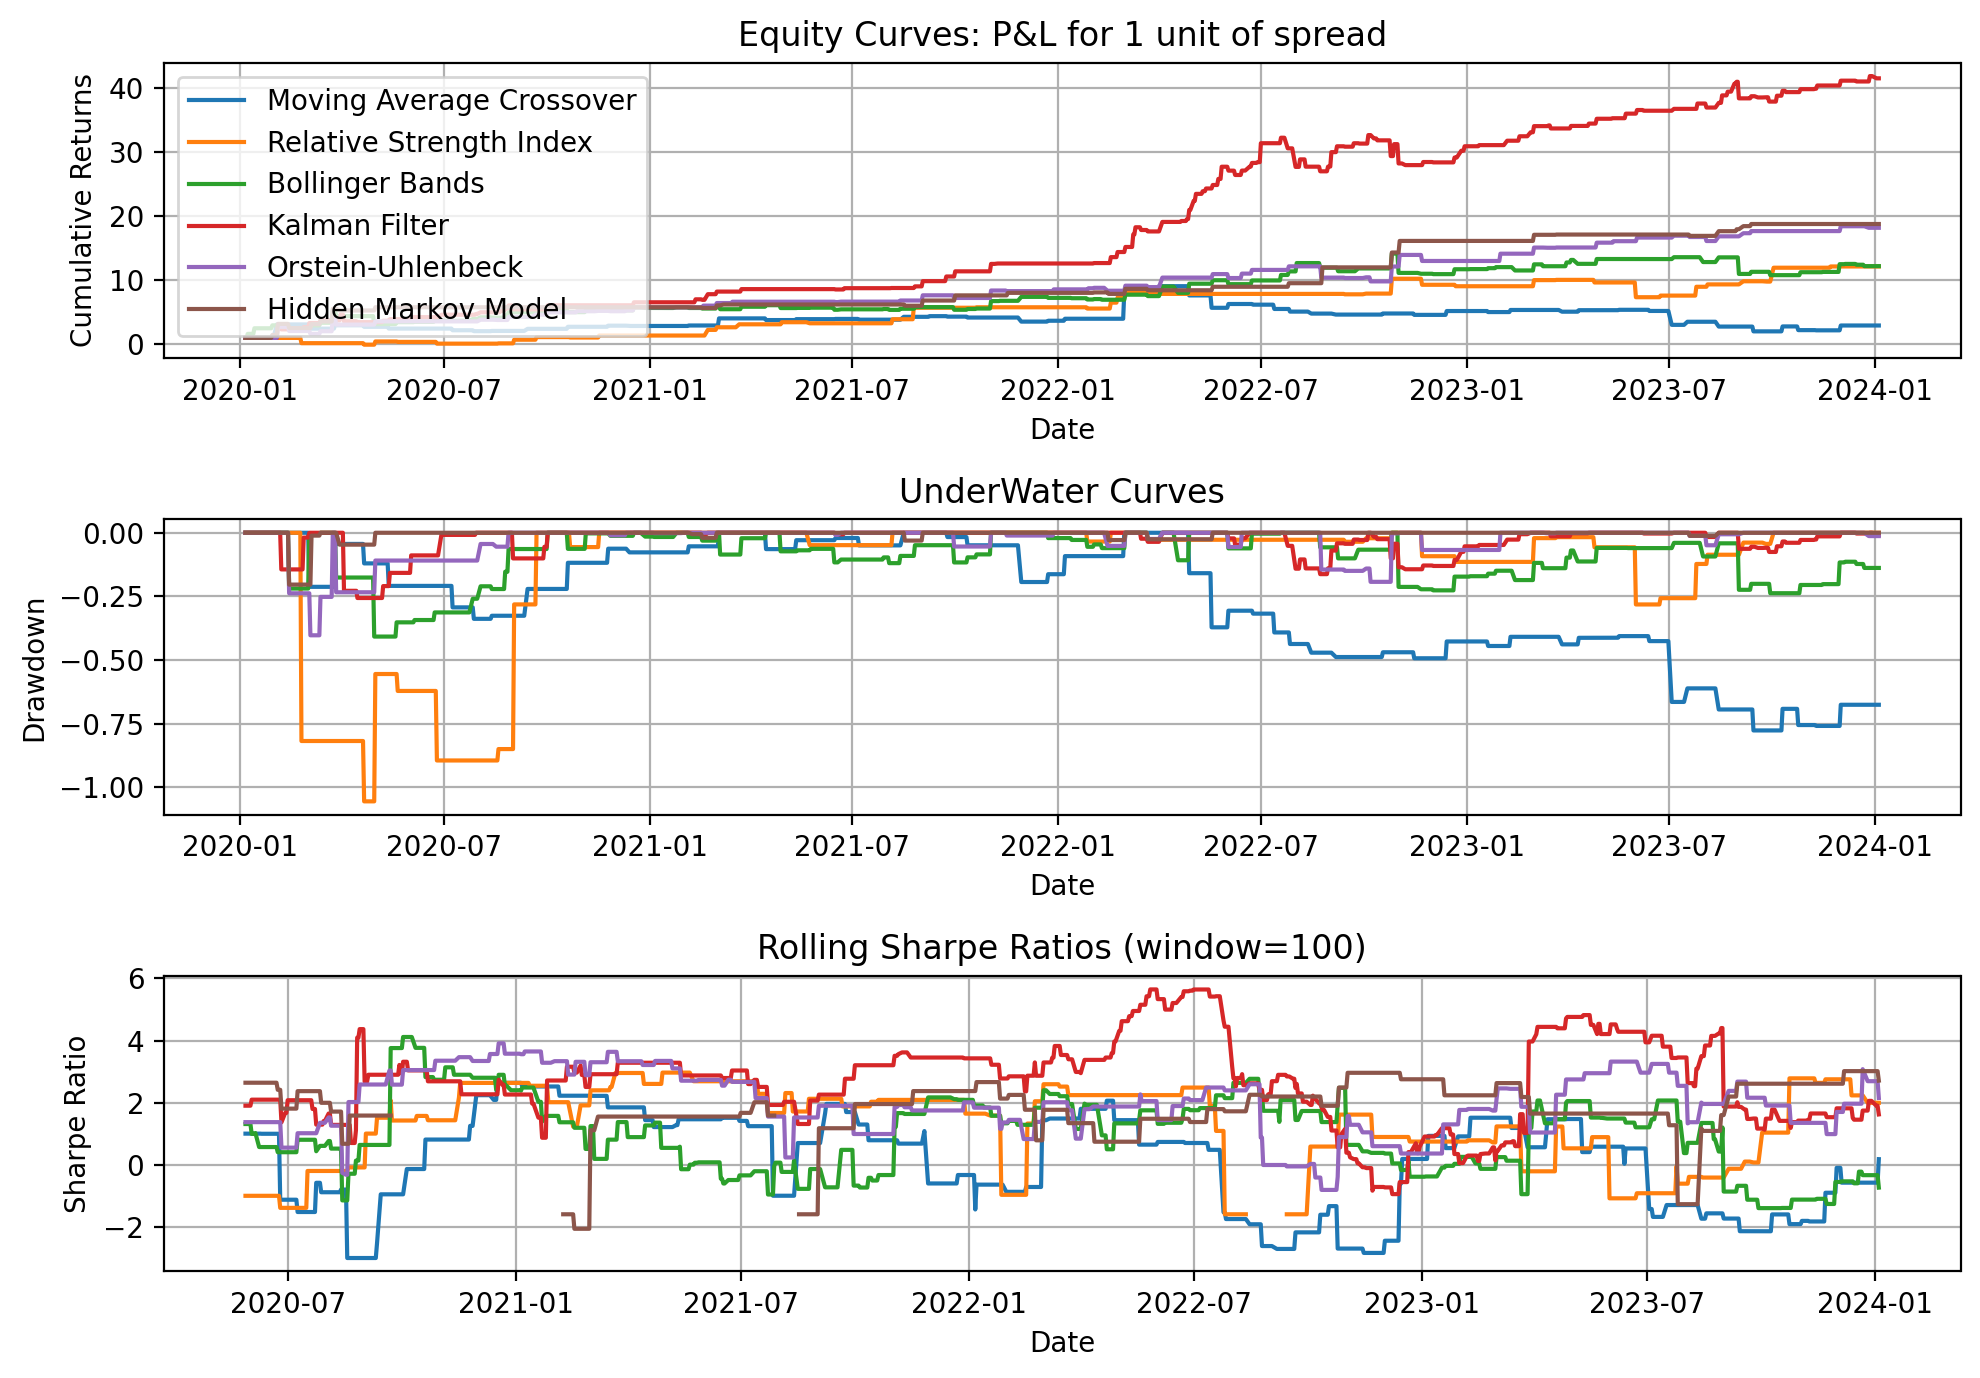

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Moving Average Crossover      0.151333       0.055582      0.002471   
Relative Strength Index       1.044966       0.291239      0.010465   
Bollinger Bands               0.781207       0.272887      0.027202   
Kalman Filter                 1.963229       0.736305      0.156531   
Orstein-Uhlenbeck             1.449857       0.621251      0.042256   
Hidden Markov Model           1.685124       1.511347      0.086466   

                          Max Drawdown  Max Drawdown Duration  Ulcer Index  \
Moving Average Crossover      0.777084                    425     0.355539   
Relative Strength Index       1.055856                    214     0.301201   
Bollinger Bands               0.408061                    296     0.136431   
Kalman Filter                 0.256482                     95     0.063568   
Orstein-Uhlenbeck             0.403056                    107     0.076468   
Hidden Markov Model           0.203746                     41     0.025265   

                          Average Win  Average Loss  Profit Factor  
Moving Average Crossover     0.551791     -0.480115       1.149288  
Relative Strength Index      0.687105     -0.431374       2.844337  
Bollinger Bands              0.509068     -0.495226       1.627589  
Kalman Filter                0.694720     -0.733904       2.778755  
Orstein-Uhlenbeck            0.596718     -0.424549       3.021902  
Hidden Markov Model          0.817936     -0.234046      10.484325

In [65]:
backtest_hmm = {"Hidden Markov Model": backtester_hmm}
perf_strat.add_backtests(backtest_hmm)
perf_strat.plot_results()
perf_strat.get_metrics()


---

### 3.5. **Cross Validation: The Danger of Overfitting**

Cross-validation is essential for evaluating whether a trading strategy generalizes well to unseen data, helping prevent **overfitting**, a common issue where models capture noise instead of meaningful patterns. In trading, this is particularly critical due to noisy, non-stationary data and the financial risks of poor out-of-sample performance.

Overfitting often results from excessive tuning of parameters. A key rule of thumb is that each parameter requires at least **252** data points (one year of daily data) to ensure robust learning. Unlike standard machine learning, cross-validation in trading must respect the temporal order of data to avoid **look-ahead bias**. For that, we incorporate cross validation into the walk-froward method by adding a validation window in-between  the training and testing ones.

<img src="images/walk_forward_cv.png" style="width: 700px;" />

The **training set** (blue) is used to estimate model parameters (compute the hedge ratio), while the **validation set** (orange) evaluates the performance of different parameter combinations (such as Sharpe ratio or another chosen metric). The best-performing parameters are then applied to the **test set** (green), ensuring that the final evaluation is performed on unseen data, reducing the risk of overfitting.

#### **Backtest Example: Tuning the Ornstein-Uhlenbeck strategy hyperprameters**

We continue the analsyis of the previous part by now comapring the results we obtain when tuning strategy compared to default settings.

For comparative performance with the default strategy, we set the beginning og training data to 2016 because cross-validation has a valdiation window of 1 year.

In [78]:
crack_pairs_outsample_cv = crack_pairs.loc[start_outsample_cv:end_outsample]

params_ou = {
    "strategy__window": [21, 30, 50, 65], 
    "strategy__exit_threshold": [0, 0.5, 1],
    "strategy__entry_threshold": [1.5, 2, 2.5],
}

backtester_ou_opt = Backtester(crack_pairs_outsample_cv, strategy_ou, hedge_ratio_des, param_grid=params_ou)
backtester_ou_opt.run_backtest()

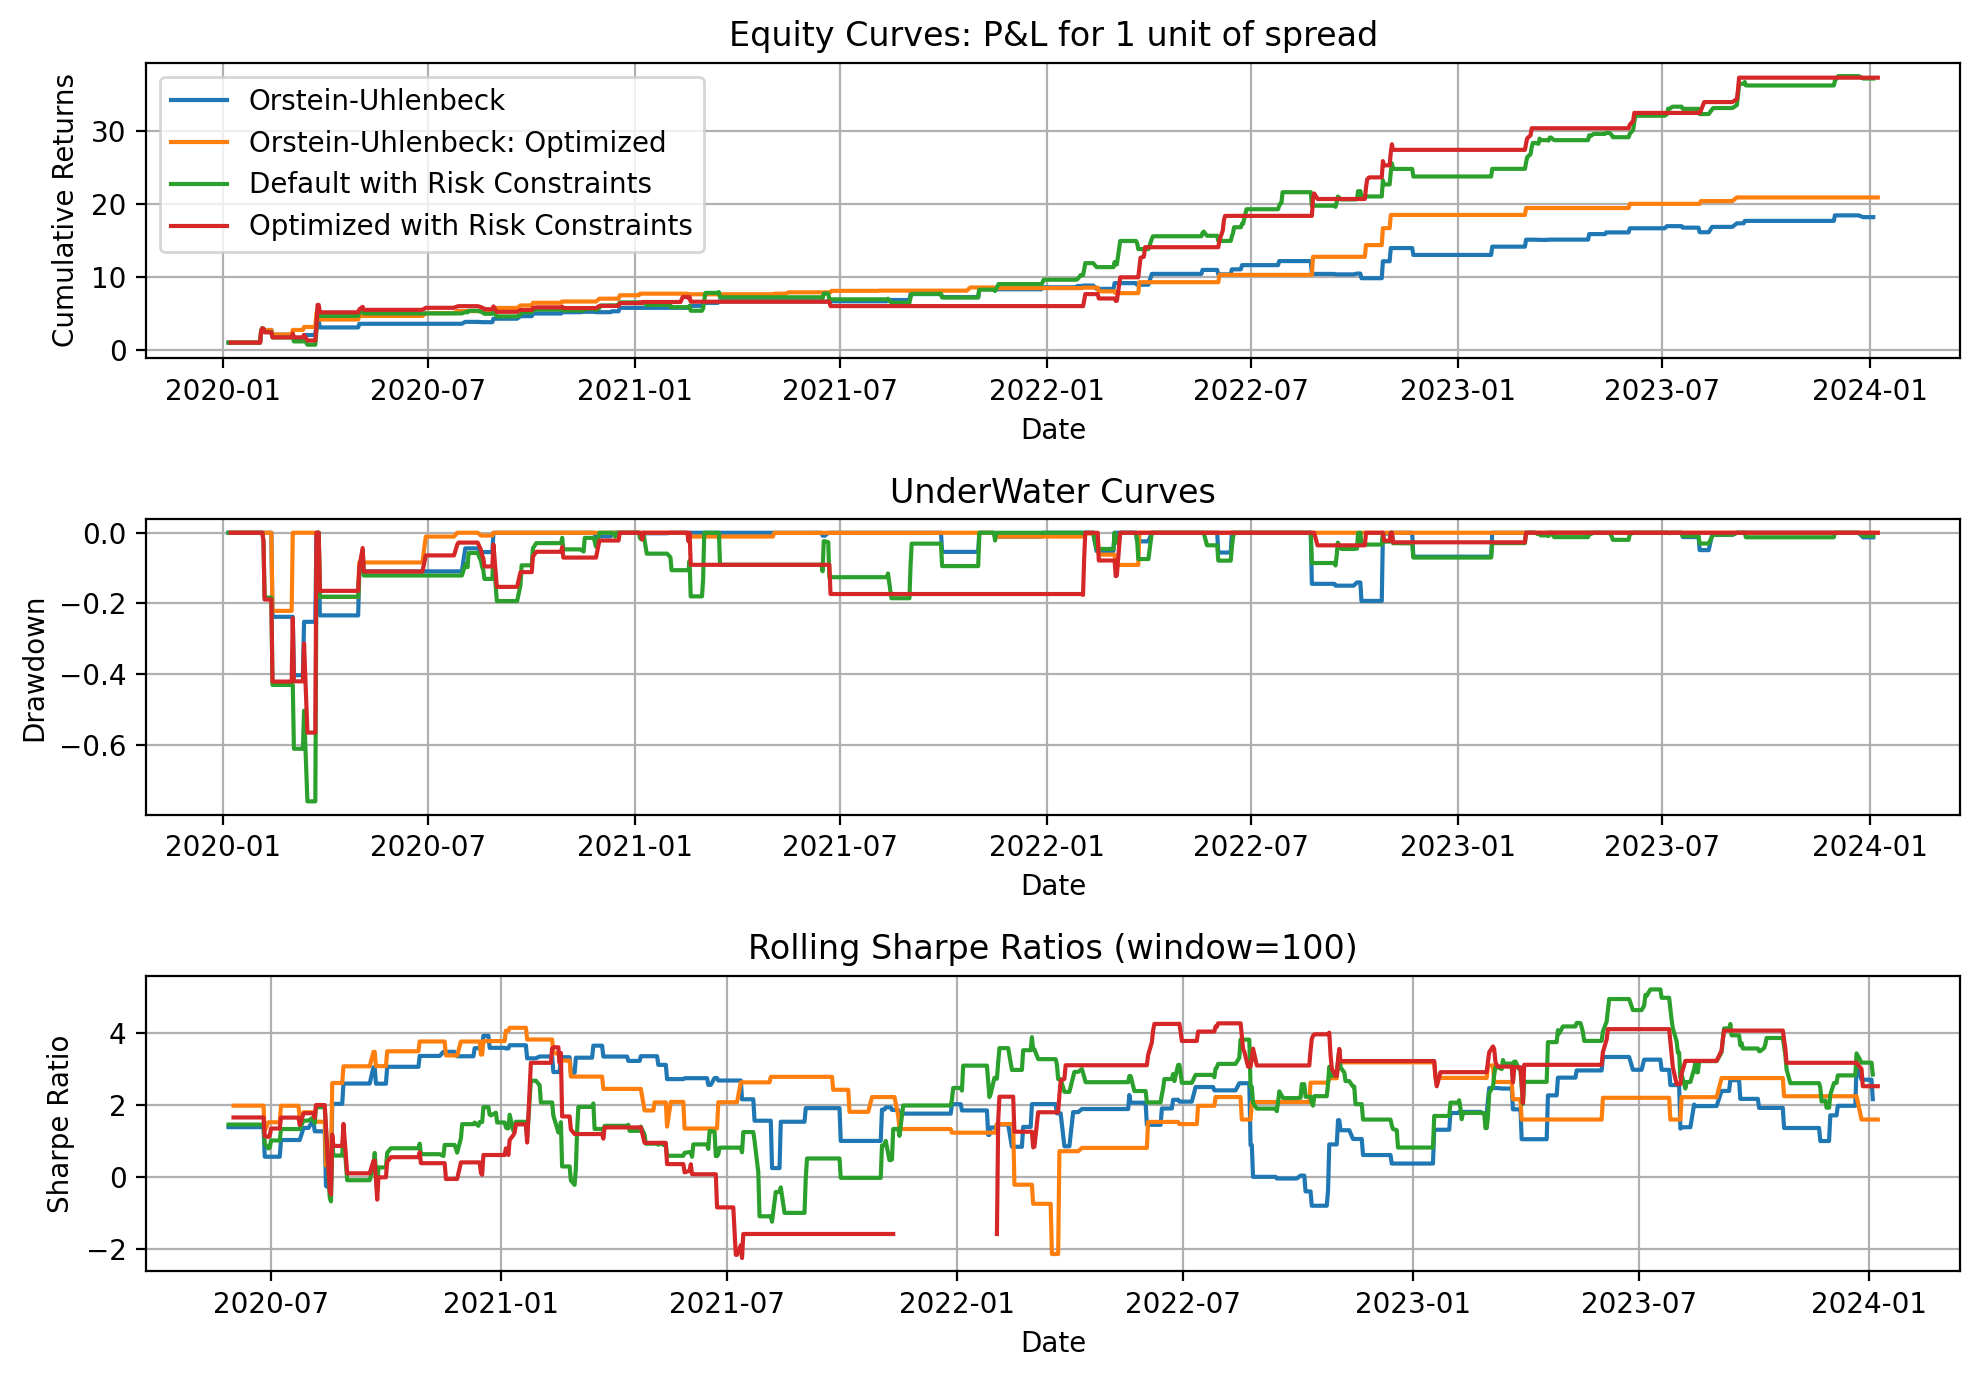

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Orstein-Uhlenbeck                    1.449857       0.621251      0.042256   
Orstein-Uhlenbeck: Optimized         1.747977       0.944143      0.089126   
Default with Risk Constraints        1.963186       1.640729      0.047154   
Optimized with Risk Constraints      2.117825       1.888596      0.063579   

                                 Max Drawdown  Max Drawdown Duration  \
Orstein-Uhlenbeck                    0.403056                    107   
Orstein-Uhlenbeck: Optimized         0.221093                     88   
Default with Risk Constraints        0.760294                    171   
Optimized with Risk Constraints      0.565671                    243   

                                 Ulcer Index  Average Win  Average Loss  \
Orstein-Uhlenbeck                   0.076468     0.596718     -0.424549   
Orstein-Uhlenbeck: Optimized        0.042138     0.745300     -0.356609   
Default with Risk Constraints       0.118302     0.626972     -0.369516   
Optimized with Risk Constraints     0.113234     0.824274     -0.412793   

                                 Profit Factor  
Orstein-Uhlenbeck                     3.021902  
Orstein-Uhlenbeck: Optimized          8.956999  
Default with Risk Constraints         2.629942  
Optimized with Risk Constraints       4.659249

In [79]:
backtest_ou_opt = {"Orstein-Uhlenbeck: Optimized": backtester_ou_opt}
backtest_ou.update(backtest_ou_opt)
perf_ou = PerformanceAnalyzer(backtest_ou)
perf_ou.plot_results()
perf_ou.get_metrics()

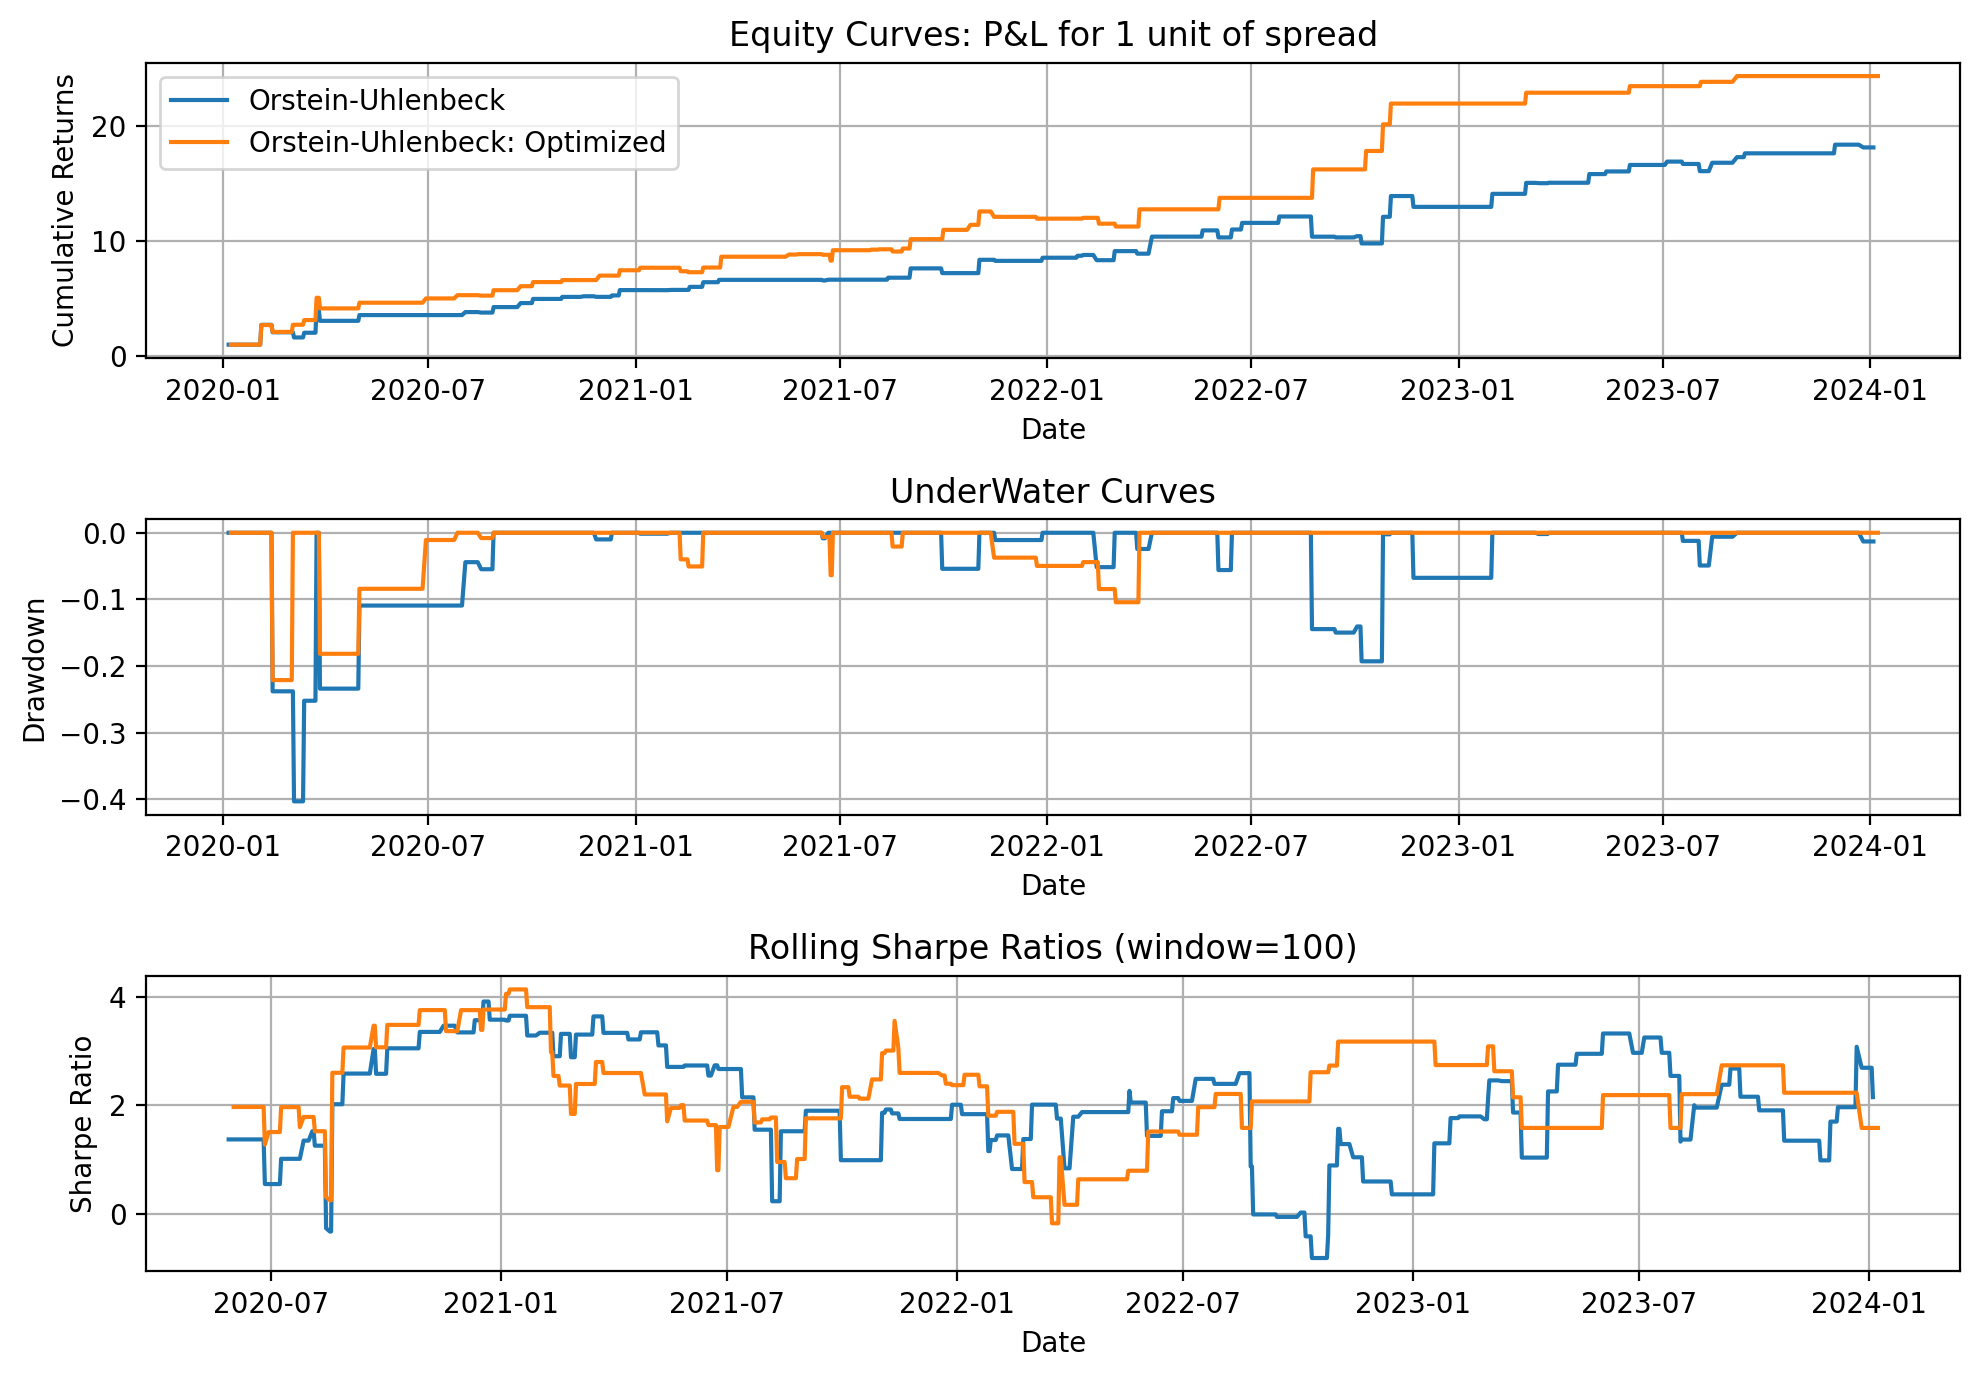

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Orstein-Uhlenbeck                 1.449857       0.621251      0.042256   
Orstein-Uhlenbeck: Optimized      1.912521       1.380397      0.104895   

                              Max Drawdown  Max Drawdown Duration  \
Orstein-Uhlenbeck                 0.403056                    107   
Orstein-Uhlenbeck: Optimized      0.221093                     89   

                              Ulcer Index  Average Win  Average Loss  \
Orstein-Uhlenbeck                0.076468     0.596718     -0.424549   
Orstein-Uhlenbeck: Optimized     0.044698     0.742512     -0.341330   

                              Profit Factor  
Orstein-Uhlenbeck                  3.021902  
Orstein-Uhlenbeck: Optimized       6.707331

In [67]:
backtest_ou_opt = {"Orstein-Uhlenbeck: Optimized": backtester_ou_opt}
backtest_ou.update(backtest_ou_opt)
perf_ou = PerformanceAnalyzer(backtest_ou)
perf_ou.plot_results()
perf_ou.get_metrics()

The comparison highlights an outperfromance in the default strategy from **January 2020** to **March 2023** in terms of equity curve however not in terms of drawdown as they show very similar ones. After this period, the default parameters strategy remains underwater wile the adpative optmized strategy cotninues to show a positve trend its equity curve with no drawdown.

Lastly, the rolling Sharpe ratio for the optimized strategy demonstrates consistent performance without signs of decay, however for the default one we can observe a slight decline in performance of the strategy compared to the begining of the backtest.

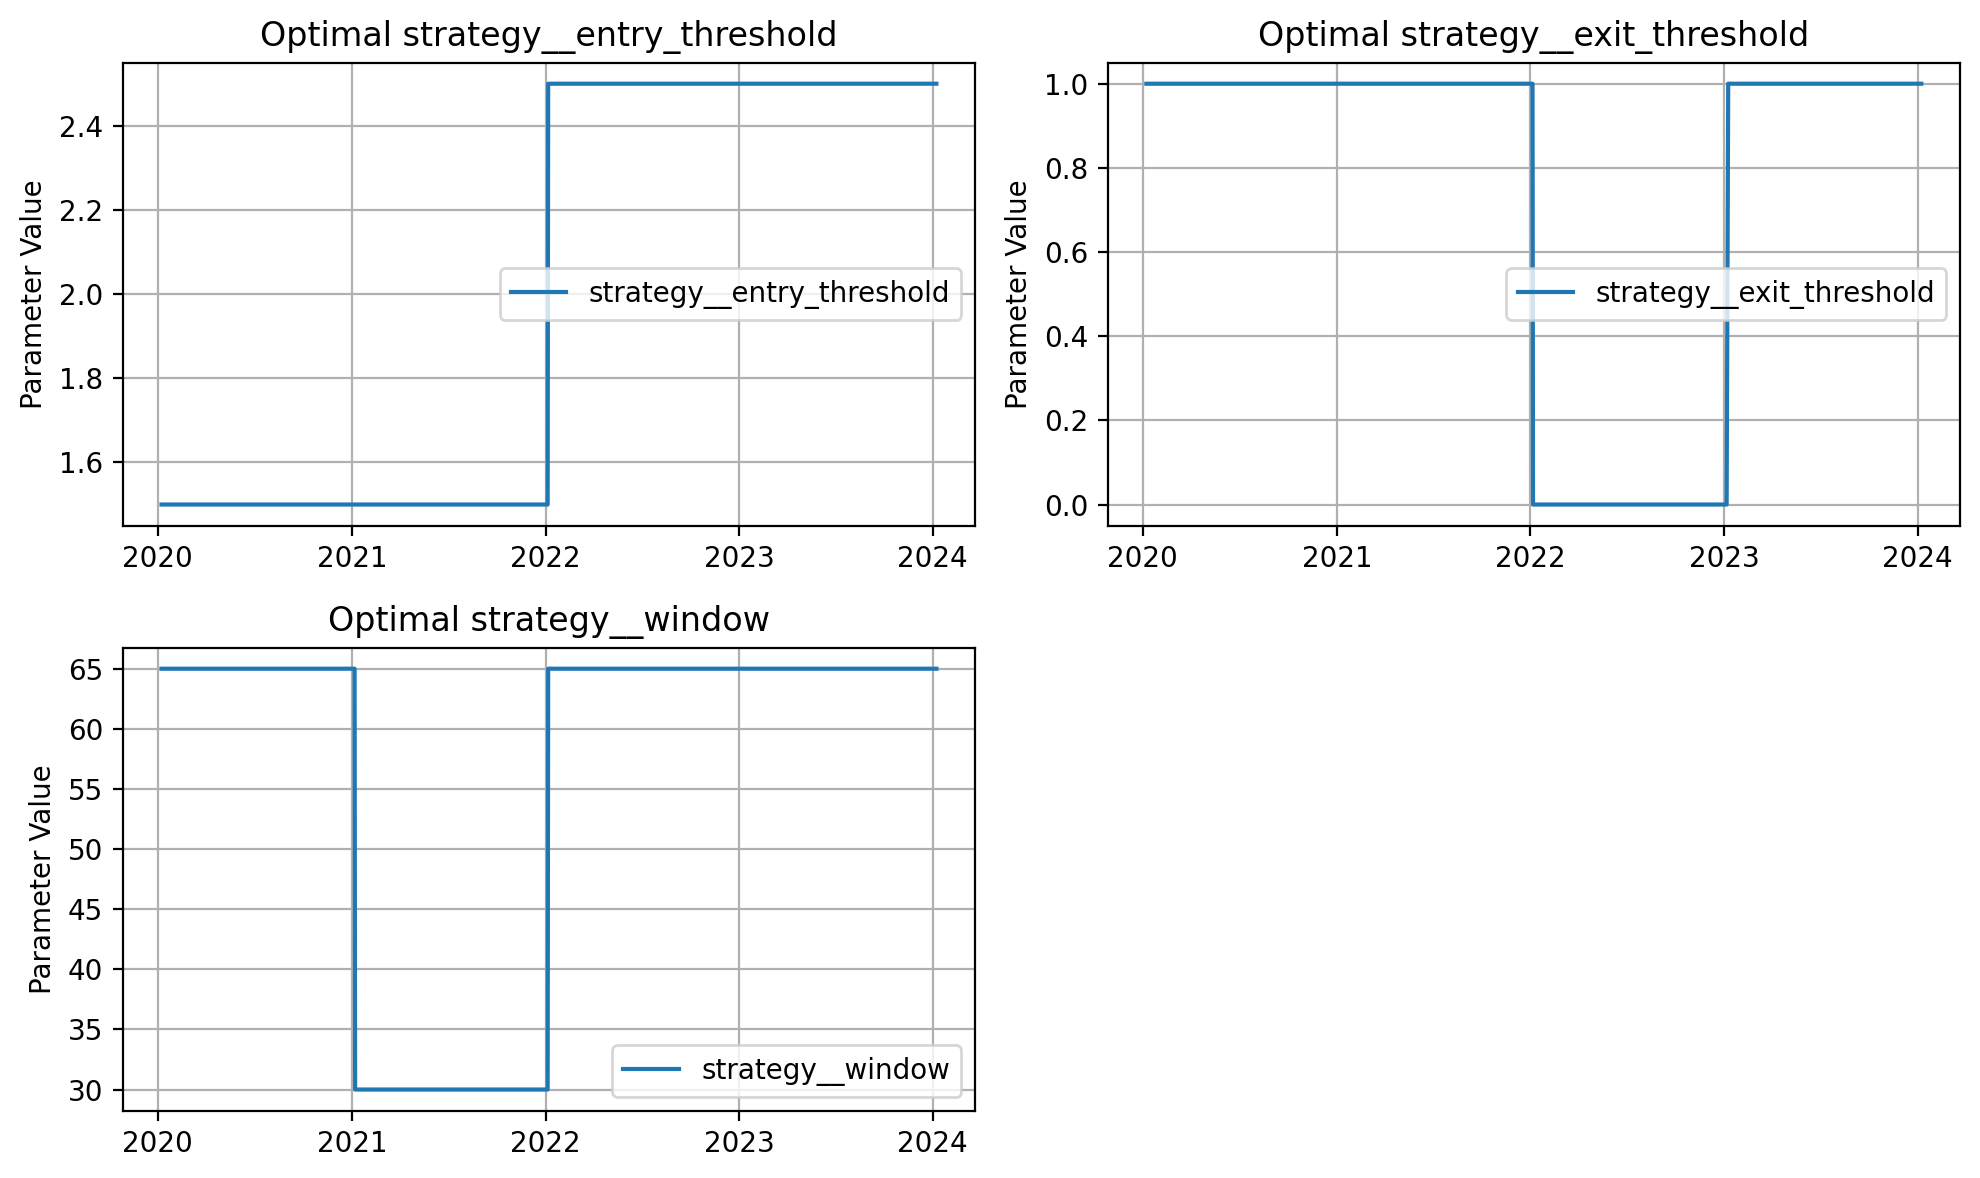

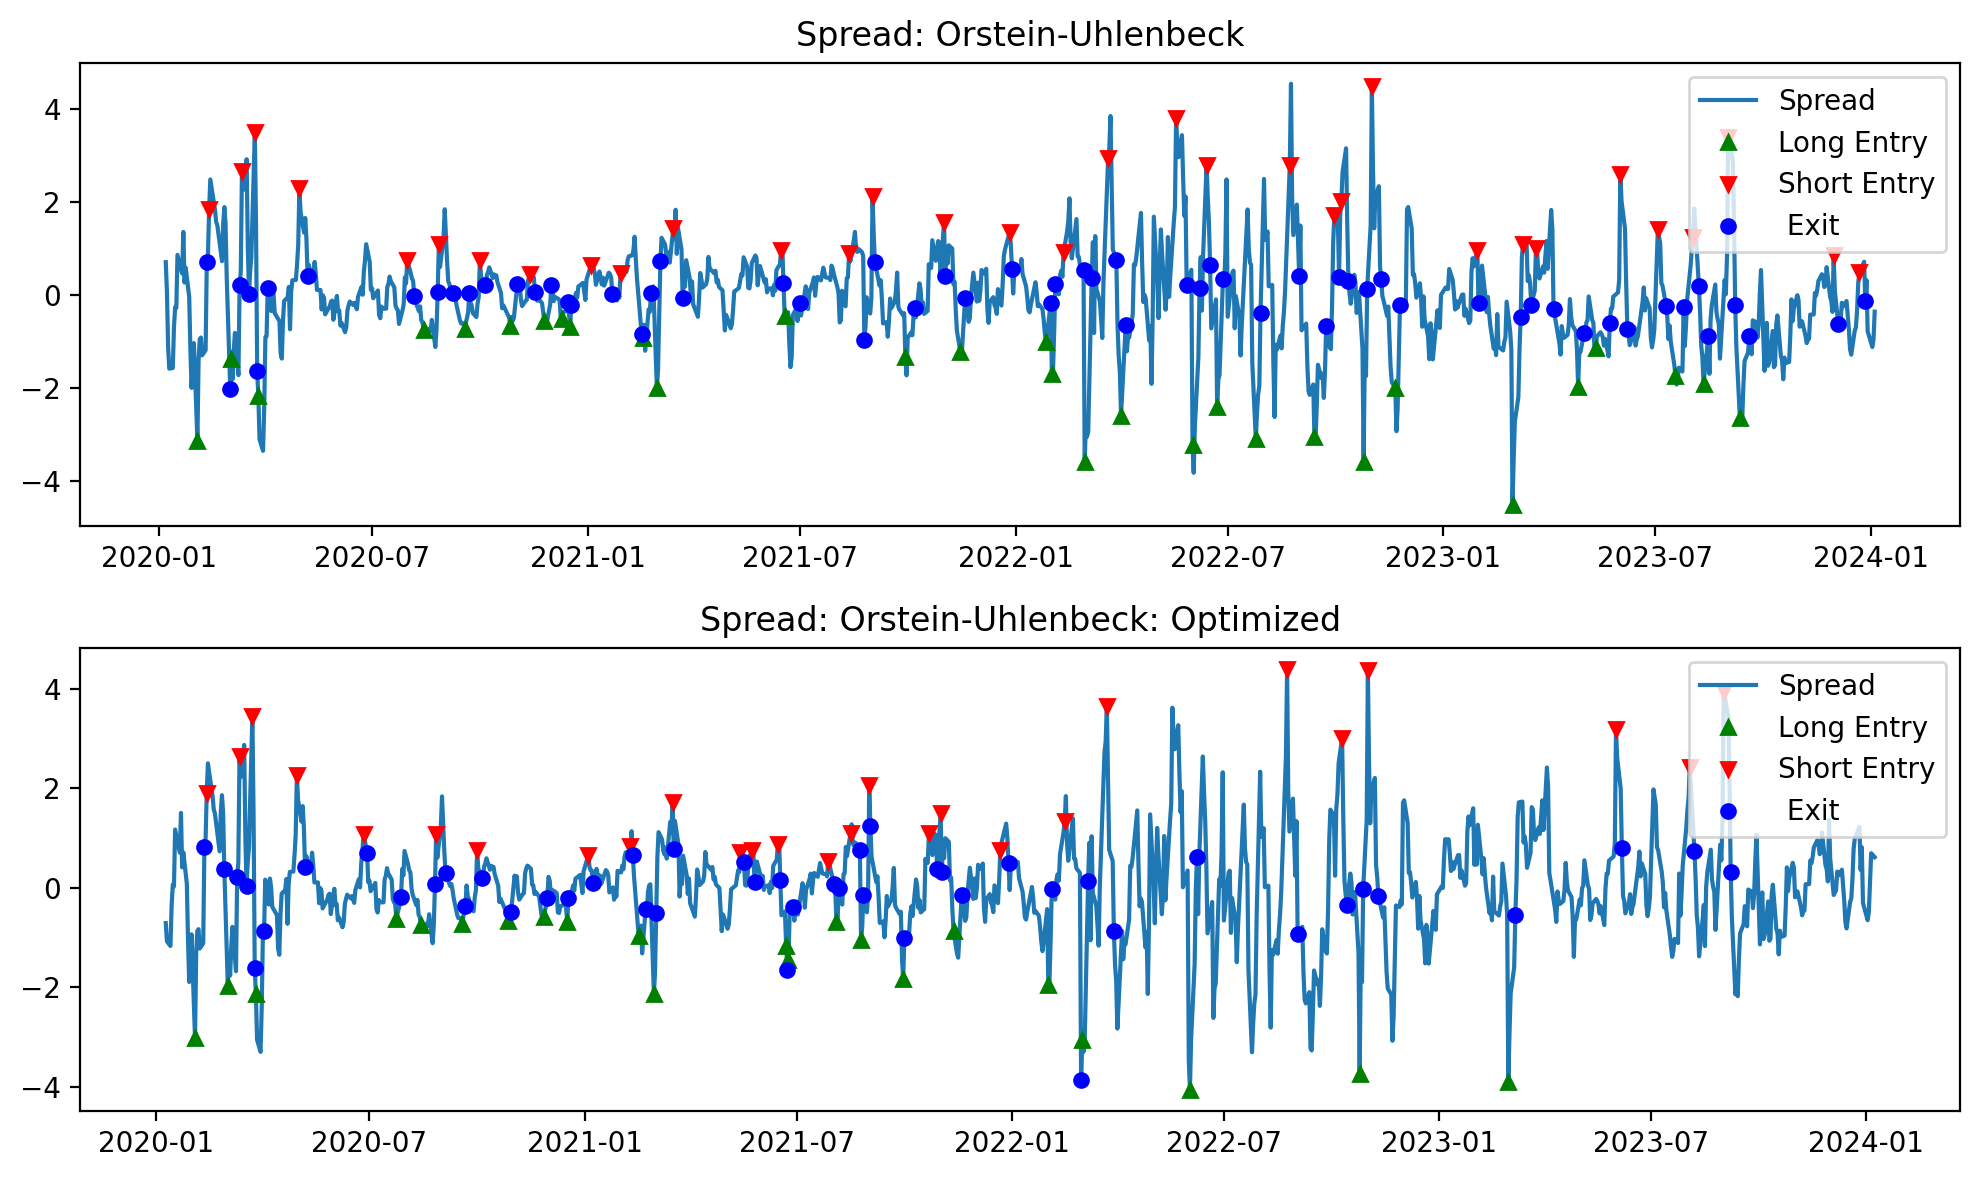

In [68]:
perf_ou.plot_params("Orstein-Uhlenbeck: Optimized", height=6)
perf_ou.plot_signals(height=6, width=10)

Here we can see that the trading frequency of the default strategy is much larger than the optimized one, particularly when there is no volatility in the spread from **July 2020** to **January 2022**. However, from 2022 to 2023 the optimized strategy did not raised its entry threhsold which could have been beneficial given the high volailtiy of the spread during this period. Actually, this behaviour is normal because it has been optimized on the validaiton set appearing the year before which did not show high volailtity in the spread.


---

### 3.6. **Risk Considerations: Practical Constraints for Real-World Trading**

Risk management is essential to ensure that a theoretically profitable strategy is viable in real-world trading. Two critical constraints are **drawdown limits** and **maximum trade duration**. Significant drawdowns, such as the 27.2% drawdown and 283-day duration observed earlier, are unacceptable in institutional settings, where strict mandates are in place to limit financial and reputational risks.

Trade duration limits help prevent capital from being tied up in underperforming trades. In pairs trading, this is often determined using the **half-life** of the spread, calculated from the **Ornstein-Uhlenbeck (OU) process**:

$$
dS_t = \theta (\mu - S_t) dt + \sigma dW_t
$$

$$
\text{Half-Life} = \frac{\ln(2)}{\theta}
$$

where:
- $\theta$: speed of mean reversion,
- $\mu$: long-term mean of the spread,
- $\sigma$ volatility of the process,
- $W_t$: standard Brownian motion.

The half-life represents the time for the spread to revert halfway to its mean after a shock. In practice, trade durations are often set as multiples of the half-life (e.g., 1x, 2x, or 3x), with shorter multiples offering more conservative risk management.

Additionally, **transaction costs** are a critical consideration, particularly in pairs or basket trading, where every entry and exit incurs costs across multiple legs. Ignoring these costs can lead to overly optimistic backtest results that fail to materialize in live trading.

By incorporating drawdown limits, trade duration constraints, and transaction costs, backtests can better reflect real-world conditions, improving the robustness and practicality of trading strategies.

#### **Setting Risk Management constraints and Transaction Costs**

We continue the analsyis of the previous part but this time setting a maximim drawdown limit of **10%** and a half-life multiple of **2** for the maximum trade duration.

Since we are trading the spread directly, we cannot apply the conservative transaction costs of 0.08% estimated by [Do and Faff 2012](https://onlinelibrary.wiley.com/doi/10.1111/j.1475-6803.2012.01317.x) for each buy or selling order on the asset involved in the spread. However we still add a penalization of 10% on each transaction that we take.

In [69]:
max_drawdown_limit = 0.10
max_trade_duration_multiplier = 2
transaction_cost_per_unit = 0.1


# Using default strategy
backtester_dflt_risk = Backtester(
    crack_pairs_outsample,
    strategy_ou,
    hedge_ratio_des,
    param_grid=None, # No cross validation
    max_drawdown_limit=max_drawdown_limit,
    max_trade_duration_multiplier=max_trade_duration_multiplier,
    transaction_cost_per_unit=transaction_cost_per_unit
)
backtester_dflt_risk.run_backtest()

# Using optimized strategy
backtester_opt_risk = Backtester(
    crack_pairs_outsample_cv,
    strategy_ou,
    hedge_ratio_des,
    param_grid=params_ou,
    max_drawdown_limit=max_drawdown_limit,
    max_trade_duration_multiplier=max_trade_duration_multiplier,
    transaction_cost_per_unit=transaction_cost_per_unit
)
backtester_opt_risk.run_backtest()

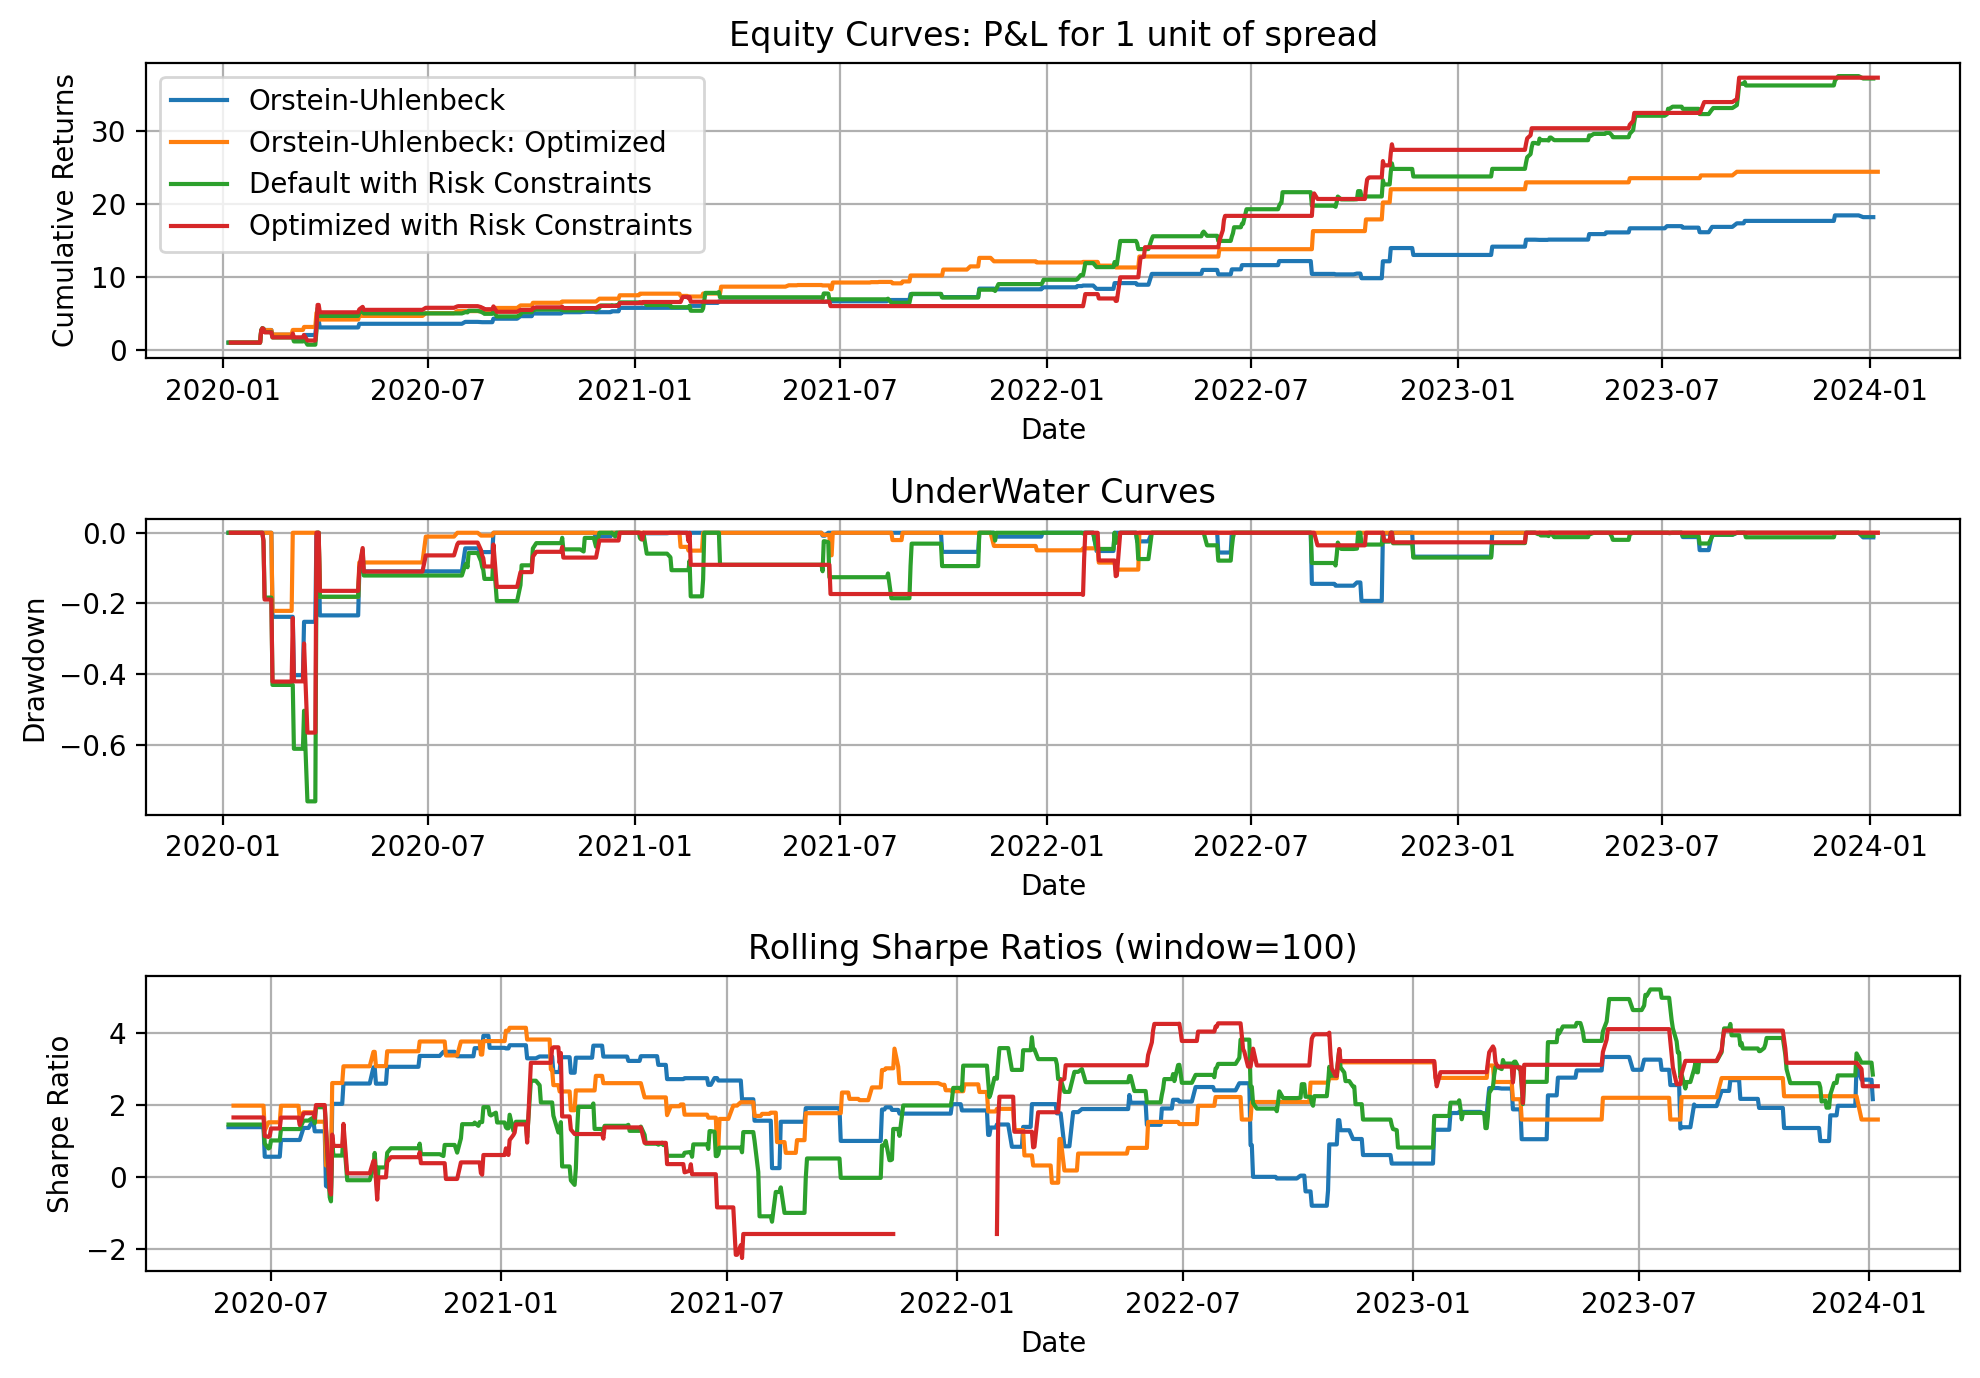

In [70]:
backtest_result_risk = {
    "Default with Risk Constraints": backtester_dflt_risk,
    "Optimized with Risk Constraints": backtester_opt_risk,
}
perf_ou.add_backtests(backtest_result_risk)
perf_ou.plot_results()

In [324]:
perf_ou.get_metrics()

Sharpe Ratio  Sortino Ratio  Calmar Ratio  \
Orstein-Uhlenbeck                    1.449857       0.621251      0.042256   
Orstein-Uhlenbeck: Optimized         1.747977       0.944143      0.089126   
Default with Risk Constraints        1.963186       1.640729      0.047154   
Optimized with Risk Constraints      2.117825       1.888596      0.063579   

                                 Max Drawdown  Max Drawdown Duration  \
Orstein-Uhlenbeck                    0.403056                    107   
Orstein-Uhlenbeck: Optimized         0.221093                     88   
Default with Risk Constraints        0.760294                    171   
Optimized with Risk Constraints      0.565671                    243   

                                 Ulcer Index  Average Win  Average Loss  \
Orstein-Uhlenbeck                   0.076468     0.596718     -0.424549   
Orstein-Uhlenbeck: Optimized        0.042138     0.745300     -0.356609   
Default with Risk Constraints       0.118302     0.626972     -0.369516   
Optimized with Risk Constraints     0.113234     0.824274     -0.412793   

                                 Profit Factor  
Orstein-Uhlenbeck                     3.021902  
Orstein-Uhlenbeck: Optimized          8.956999  
Default with Risk Constraints         2.629942  
Optimized with Risk Constraints       4.659249

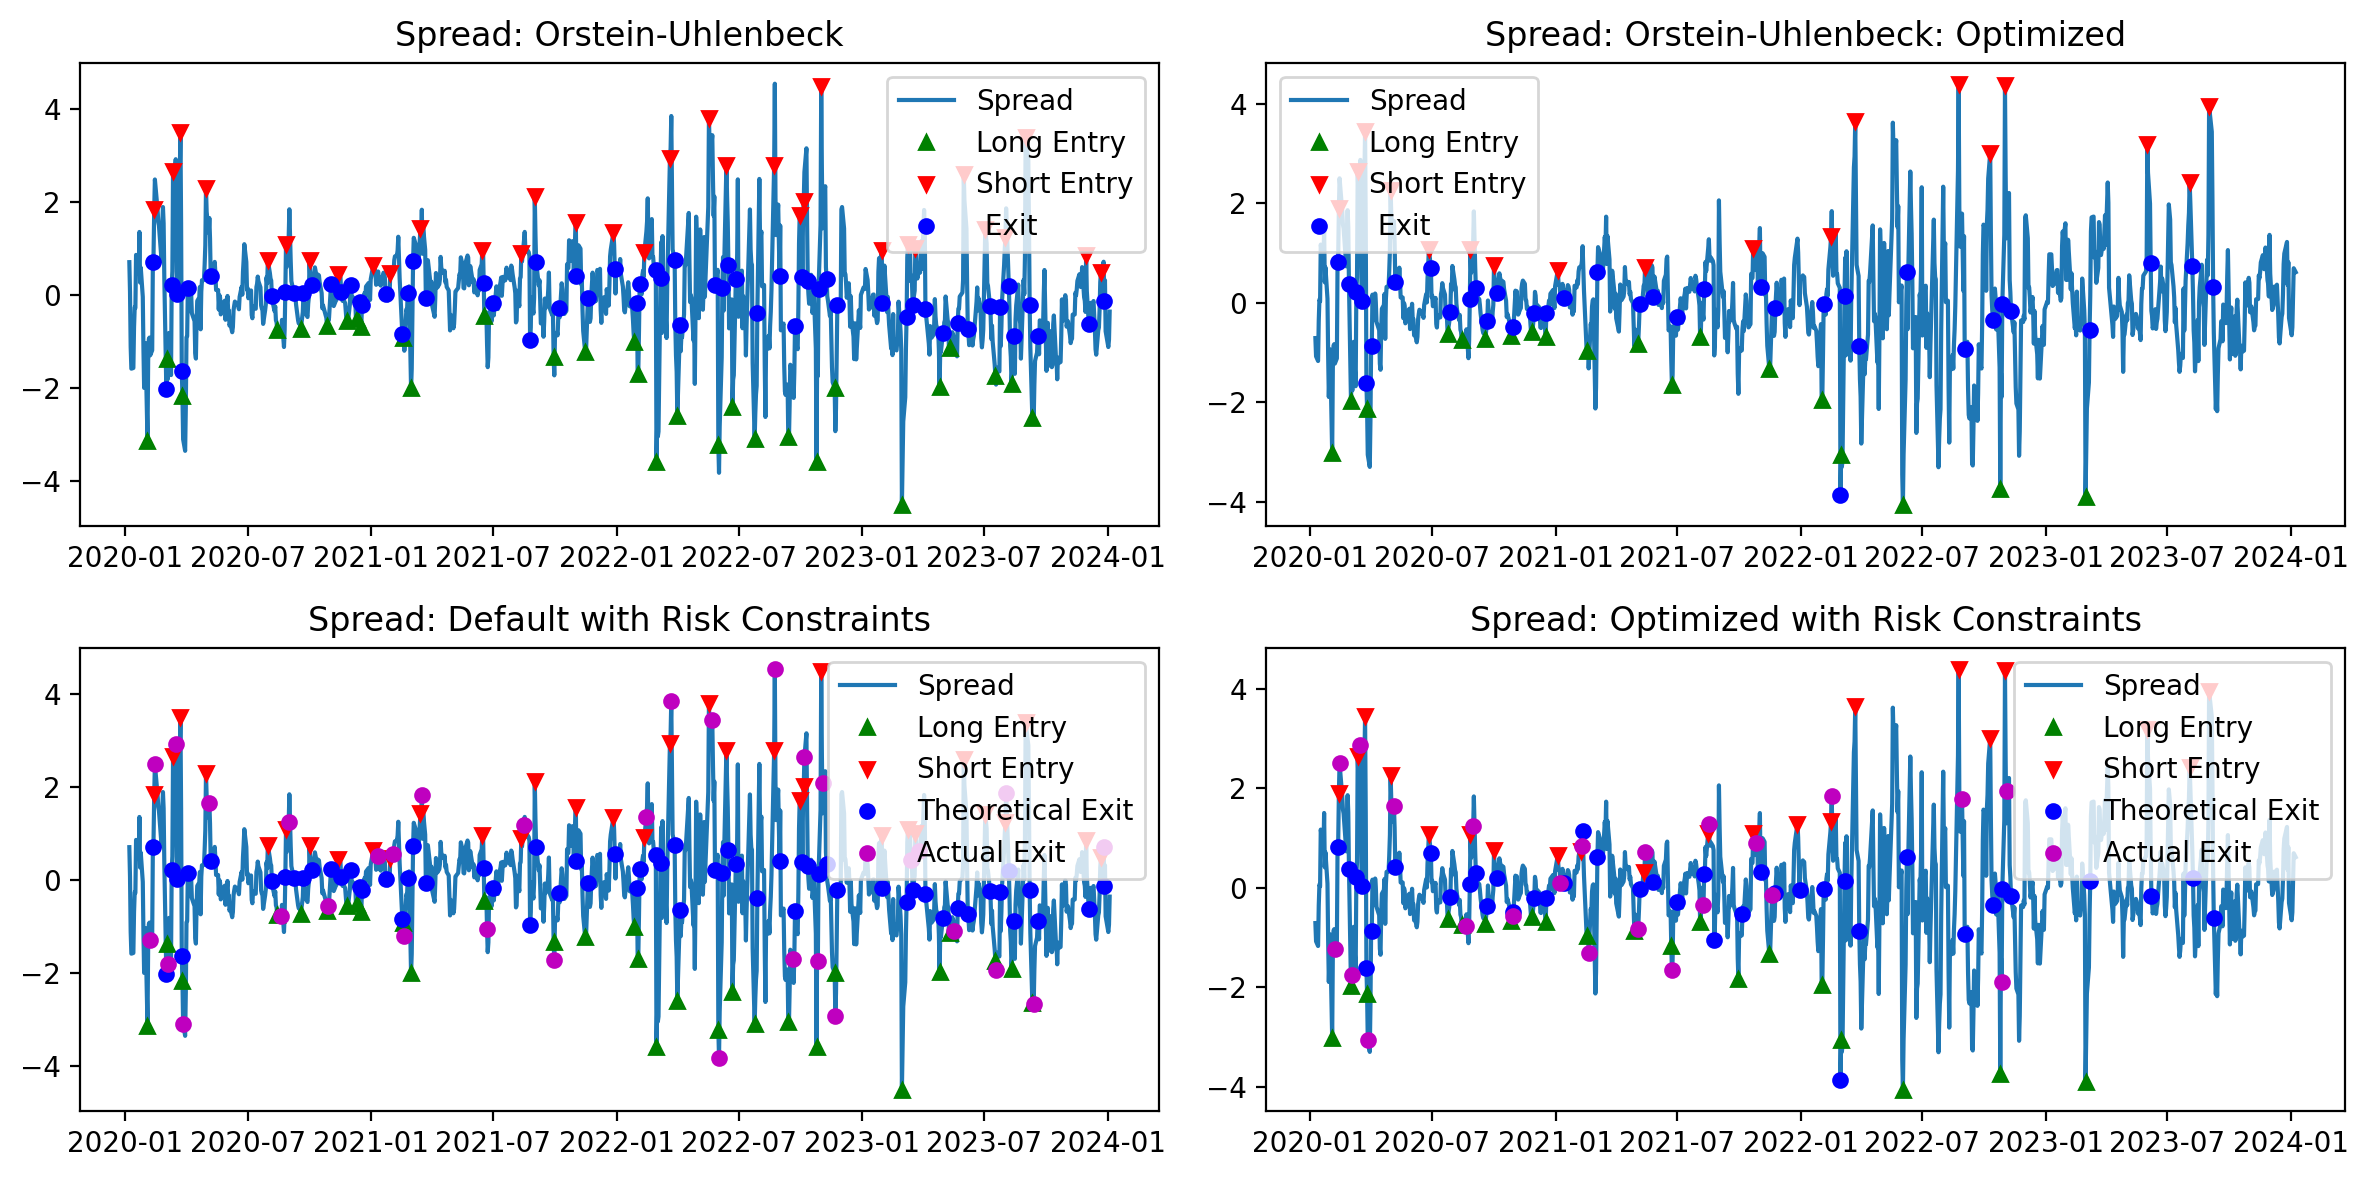

In [321]:
perf_ou.plot_signals()

#### **Backtest Example: Comparison Economic vs Statistical pairs**

As a final assessment, we can comapre the performance between the pairs selected based on economical relationships and those slected based on statistical criterias folowing [**pairs_selection.ipynb**](pairs_selection.ipynb).

For the purpose of compariosn, for the economic-based pairs we add those that were not validated in-sample from **2011 to 2020** namely, CL=F VS USO, ALI=F VS NF=F, CL=F VS NG=G VS XOP in order to asseess wether despite not passing the ADF test they that pass teh backtest.

In [ ]:
with open('valid_pairs.json', 'r') as file:
    pairs = json.load(file)

eco_pairs = []
for pair in pairs["economic_pairs"].values():
    eco_pairs.append(pair)

stat_pairs = []
for pair in pairs["statistical_pairs"].values():
    stat_pairs.append(pair)

unique_tickers = set()
for pair_type in pairs.keys():
    for pair in pairs[pair_type].values():
        unique_tickers.update(pair)

unique_tickers = list(unique_tickers)
prices = fetch_data(unique_tickers, start=start_outsample_cv, end=end_outsample, how="outer")
prices

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Ticker             XOP    RB=F        XLE         BP       BZ=F        TAN  \
Date                                                                         
2016-01-04  121.480003  1.2907  60.299999  31.059999  37.220001  30.770000   
2016-01-05  121.080002  1.2567  60.529999  30.930000  36.419998  30.299999   
2016-01-06  112.760002  1.1618  58.200001  30.299999  34.230000  29.709999   
2016-01-07  109.959999  1.1460  56.779999  29.430000  33.750000  26.990000   
2016-01-08  110.480003  1.1277  56.049999  28.910000  33.549999  27.299999   
...                ...     ...        ...        ...        ...        ...   
2024-11-29  145.479996  1.9437  95.529999  29.309999  72.940002  36.830002   
2024-12-02  143.830002  1.9172  94.519997  28.990000  71.830002  37.470001   
2024-12-03  143.940002  1.9624  94.510002  29.450001  73.620003  36.869999   
2024-12-04  139.410004  1.9391  92.230003  29.129999  72.309998  36.020000   
2024-12-05  138.979996  1.9325  92.589996  29.139999  72.089996  35.430000   

Ticker            USO   NG=F        TTE    ALI=F    HO=F        URA  \
Date                                                                  
2016-01-04  87.839996  2.334  44.369999  1601.50  1.1264  13.900000   
2016-01-05  85.279999  2.325  43.419998  1593.25  1.1253  13.820000   
2016-01-06  80.879997  2.267  42.650002  1607.00  1.0807  13.500000   
2016-01-07  79.199997  2.382  41.630001  1607.75  1.0656  12.980000   
2016-01-08  78.400002  2.472  40.610001  1624.50  1.0521  13.150000   
...               ...    ...        ...      ...     ...        ...   
2024-11-29  71.610001  3.363  57.990002  2562.00  2.1930  32.349998   
2024-12-02  71.040001  3.213  56.480000  2559.00  2.1777  31.910000   
2024-12-03  73.040001  3.042  57.070000  2590.50  2.2177  31.889999   
2024-12-04  71.879997  3.043  56.700001  2625.25  2.1674  31.680000   
2024-12-05  71.470001  3.079  57.450001  2614.25  2.1557  31.950001   

Ticker           CL=F        UGA    HG=F       SHEL  
Date                                                 
2016-01-04  36.759998  29.719999  2.0705  45.830002  
2016-01-05  35.970001  28.990000  2.0885  45.610001  
2016-01-06  33.970001  27.020000  2.0805  44.020000  
2016-01-07  33.270000  26.549999  2.0155  42.119999  
2016-01-08  33.160000  25.950001  2.0165  40.380001  
...               ...        ...     ...        ...  
2024-11-29  68.000000  60.290001  4.0805  64.739998  
2024-12-02  68.099998  60.180000  4.0755  64.339996  
2024-12-03  69.940002  61.740002  4.1460  65.279999  
2024-12-04  68.540001  61.000000  4.1420  64.209999  
2024-12-05  68.300003  60.900002  4.1350  64.349998  

[2209 rows x 16 columns]

In [120]:
import copy

def run_backtests(pair_names, prices):
    backtests = {}
    params_bb = {
        "strategy__window": [13, 21, 30, 50],
        "strategy__entry_threshold": [1.5, 2, 2.5],
        "strategy__exit_threshold": [0, 0.5, 1],
    }
    
    for pair_name in pair_names:
        pair_name = list(pair_name)
        pair_prices = prices[pair_name].dropna()
        #params = copy.deepcopy(params_ou)
        #kf = KalmanFilterModel(pair_prices)
        
        if len(pair_name) == 2:
            hedge_ratio = DoubleExponentialSmoothingHedgeRatio()
            #params["delta"] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        elif len(pair_name) > 2:
            hedge_ratio = JohansenHedgeRatio()
        else:
            raise ValueError("Invalid number of pairs, should be at least 2")
        
        backtester = Backtester(
            prices=pair_prices,
            trading_strategy=strategy_bb,
            hedge_ratio_model=hedge_ratio,
            param_grid=params_bb,
            max_drawdown_limit=max_drawdown_limit,
            max_trade_duration_multiplier=max_trade_duration_multiplier,
            transaction_cost_per_unit=transaction_cost_per_unit
        )
        backtests[" VS ".join(pair_name)] = backtester

    valid_backtests = {}
    invalid_backtests = {}
    
    pbar = tqdm(backtests.items(), total=len(backtests))
    for backtest_name, backtester in pbar:
        pbar.set_description(f"Running Backtest: {backtest_name}")
        backtester.run_backtest()
        if all(backtester.valid_backtests):
            valid_backtests[backtest_name] = backtester
        else:
            invalid_backtests[backtest_name] = backtester
    
    return valid_backtests, invalid_backtests

In [121]:
backtests_stat_valid, backtests_stat_invalid = run_backtests(stat_pairs, prices)
backtests_eco_valid, backtests_eco_invalid = run_backtests(eco_pairs, prices)

  0%|          | 0/17 [00:00<?, ?it/s]

Running Backtest: BZ=F VS SHEL: 100%|██████████| 5/5 [02:49<00:00, 33.98s/it]        


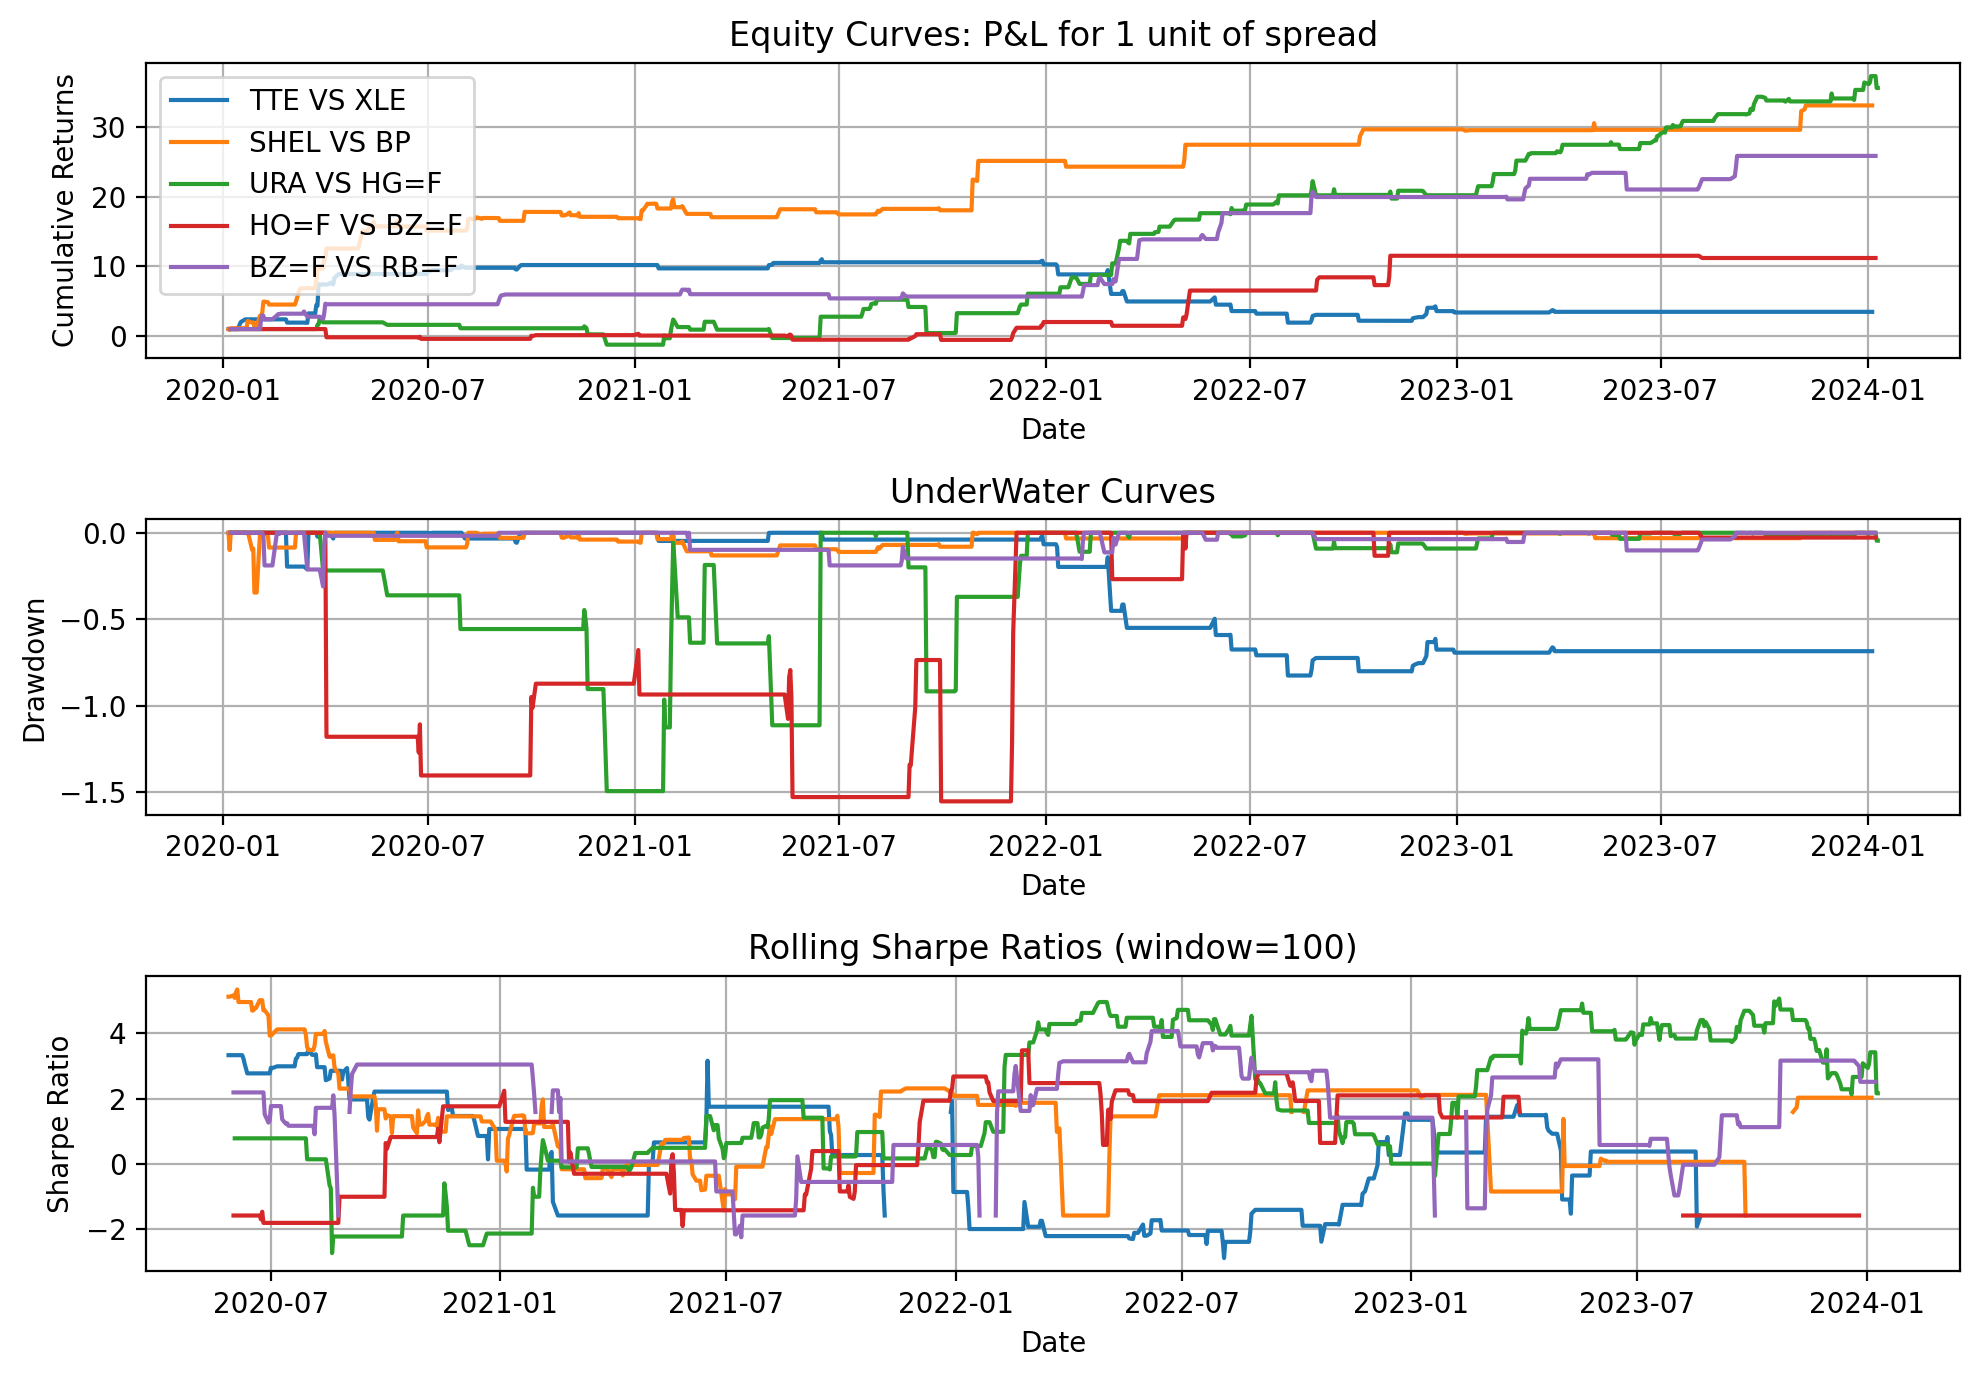

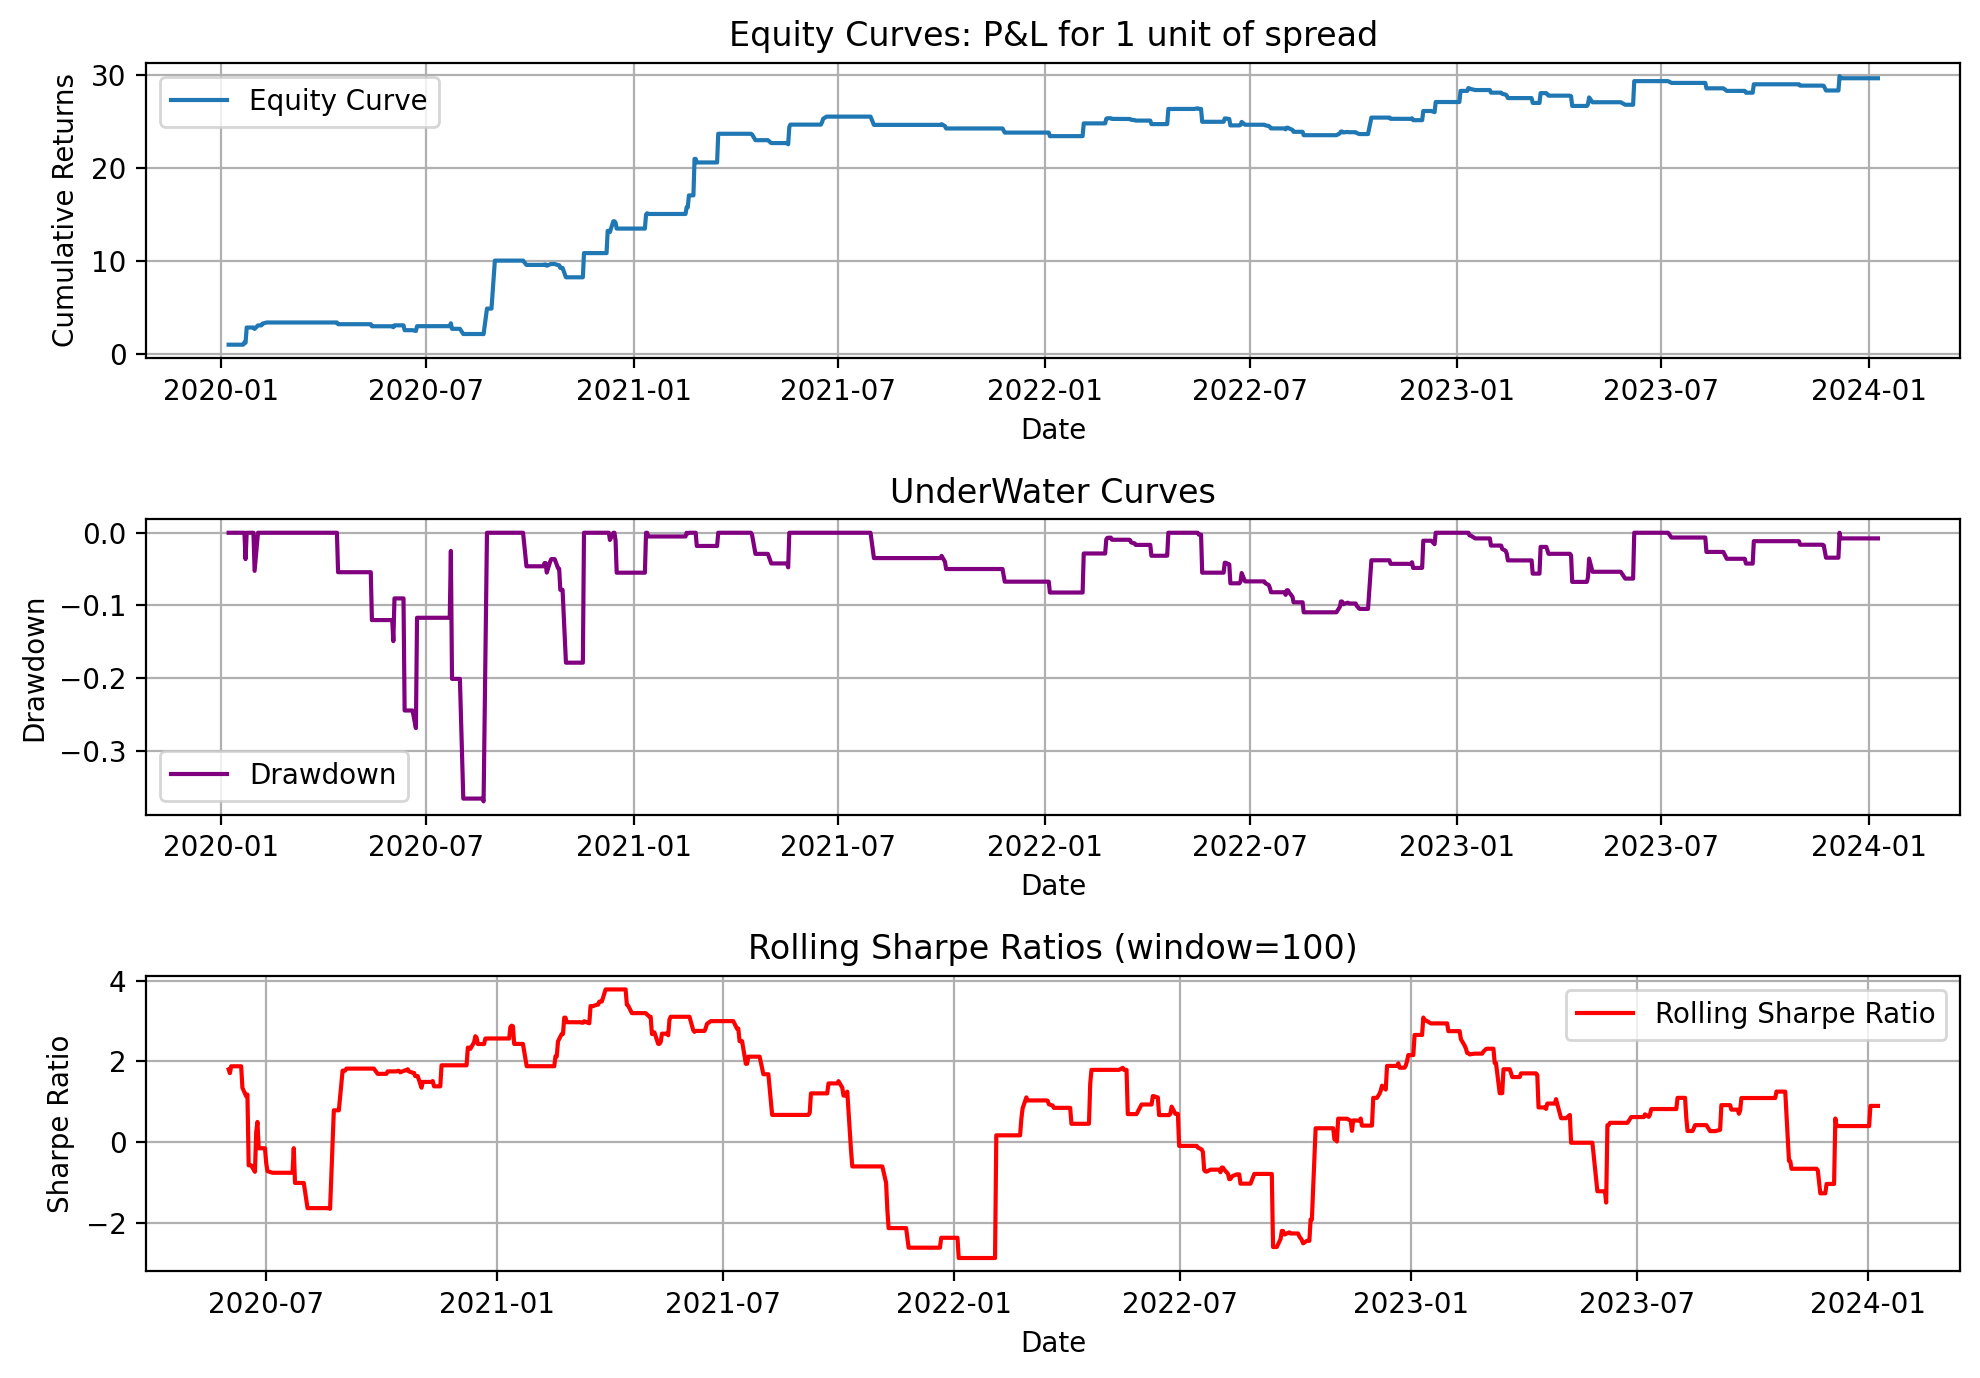

In [122]:
backtests_stat_names = list(dict(backtests_stat_valid).keys())
backtests_eco_names = list(dict(backtests_eco_valid).keys())
perf_2 = PerformanceAnalyzer({**backtests_stat_valid, **backtests_eco_valid})
perf_2.plot_results(backtests_stat_names)
perf_2.plot_results(backtests_eco_names)

In [123]:
perf_2.get_metrics()

Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max Drawdown  \
TTE VS XLE                0.195451       0.054106      0.002971      0.825641   
SHEL VS BP                1.766797       1.571252      0.092045      0.345978   
URA VS HG=F               1.699656       0.798490      0.022975      1.494194   
HO=F VS BZ=F              0.887139       0.419912      0.006514      1.553367   
BZ=F VS RB=F              1.707847       0.714897      0.079494      0.310205   
CL=F VS HO=F VS RB=F      1.320839       1.739807      0.076964      0.369689   

                      Max Drawdown Duration  Ulcer Index  Average Win  \
TTE VS XLE                              643     0.467352     0.456763   
SHEL VS BP                              184     0.053314     0.831648   
URA VS HG=F                             305     0.447094     0.731301   
HO=F VS BZ=F                            423     0.797048     0.667014   
BZ=F VS RB=F                            243     0.080202     0.740270   
CL=F VS HO=F VS RB=F                    181     0.072709     0.860265   

                      Average Loss  Profit Factor  
TTE VS XLE               -0.551264       1.166143  
SHEL VS BP               -0.337071       3.506131  
URA VS HG=F              -0.576433       2.364330  
HO=F VS BZ=F             -0.414962       2.755560  
BZ=F VS RB=F             -0.510868       3.703114  
CL=F VS HO=F VS RB=F     -0.239467       2.409029

For the statistical pairs, only 5 out of the 17 identifeid has have passed the validity tests inside the backtest with a correlation filter of 8.7, a ADF pvalue of 0.05 and a half life between 1 and 5 (for quick reversion). Among those that passed the backtest only 2 higher performance results, namely the pair SHEL VS BP and BZ=F vs RB=F (which is the benchmakr that we have used for the crack spread so far).

On the other hand, for the pairs selected base don economic rationale only 1 pair has been passe dthe valdity tests during the bakctest and it clearly outperforms all the pairs that were selected based on statistical relationship only. It is not surprising that it is the basket CL=F VS HO=F VS RB=F whose teh spread spread constructed fromt this backets was the one showing the msot statioanrty and mean reverison property.